# Сборный проект — 2

# Задача. 
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.

Компания предоставила данные с характеристиками сотрудников компании, уровнем удовлетворённости сотрудника работой в компании: 
0 — совершенно неудовлетворён
1 — полностью удовлетворён. 

# Первая задача
Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Обоснование: 
-удовлетворённость работой напрямую влияет на отток сотрудников
-предсказание оттока — одна из важнейших задач HR-аналитиков
-внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

# Вторая задача 
Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Задача 1: Предсказание уровня удовлетворённости сотрудника
Заказчик предоставил данные с признаками:
•	id — уникальный идентификатор сотрудника;
•	dept — отдел, в котором работает сотрудник;
•	level — уровень занимаемой должности;
•	workload — уровень загруженности сотрудника;
•	employment_years — длительность работы в компании (в годах);
•	last_year_promo — показывает, было ли повышение за последний год;
•	last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
•	supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
•	salary — ежемесячная зарплата сотрудника;
•	job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

#  Шаг 1. Загрузка данных

Загрузите файлы с данными:
Тренировочная выборка:
train_job_satisfaction_rate.csv
Входные признаки тестовой выборки:
test_features.csv
Целевой признак тестовой выборки:
test_target_job_satisfaction_rate.csv

In [250]:
!pip install -q phik
!pip install -q --upgrade scikit-learn

In [251]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os

from phik import phik_matrix
from scipy.stats import mstats, pearsonr

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, QuantileTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, mean_squared_error, mean_absolute_percentage_error, r2_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel

from sklearn.datasets import make_classification

In [252]:
# Пути к файлам
local_path = 'C:/GitProjects/supervised_learning_project/data/task1/train1/train_job_satisfaction_rate.csv'
server_path = '/datasets/train_job_satisfaction_rate.csv'

# Инициализация переменной для хранения данных
data_train = None

# Проверка существования файлов и загрузка данных
try:
    if os.path.exists(local_path):
        data_train = pd.read_csv(local_path)
        print("Данные загружены с локального пути.")
    elif os.path.exists(server_path):
        data_train = pd.read_csv(server_path)
        print("Данные загружены с серверного пути.")
    else:
        raise FileNotFoundError("Файл не найден ни по локальному, ни по серверному пути.")
    
    # Выводим имена столбцов
    print("Имена столбцов:", data_train.columns.tolist())

    # нет столбца с датами, просто загружаем данные без parse_dates
    # используем index_col для индекса
    data_train = pd.read_csv(local_path, index_col='id')
    
except Exception as e:
    print(f"Произошла ошибка: {e}")

# Вывод первых 5 строк данных, если данные были загружены
if data_train is not None:
    display(data_train.head())
else:
    print("Нет данных для отображения.")

Данные загружены с локального пути.
Имена столбцов: ['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


dept   level workload  employment_years last_year_promo  \
id                                                                      
155278       sales  junior   medium                 2              no   
653870          hr  junior     high                 2              no   
184592       sales  junior      low                 1              no   
171431  technology  junior      low                 4              no   
693419          hr  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
155278                   no                      1   24000   
653870                   no                      5   38400   
184592                   no                      2   12000   
171431                   no                      2   18000   
693419                   no                      3   22800   

        job_satisfaction_rate  
id                             
155278                   0.58  
653870                   0.76  
184592                   0.11  
171431                   0.37  
693419                   0.20

In [253]:
# Изучение структуры данных
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB
None


Тренировочная выборка data_train состоит из 4000 записей с 10 признаками, содержит пропущенные значения в столбцах dept - 6 и level - 4, их можно обработать с помощью методов заполнения, таких как среднее или мода. Все признаки являются категориальными или числовыми. 

Анализ категориальных признаков: dept имеет 5 уникальных значения, level - 3, workload - 3, last_year_promo и last_year_violations - по  2 уникальных значения.

Анализ числовых признаков: employment_years варьируется от 1 до 10 лет, supervisor_evaluation - от 1 до 5, salary - от 10000 до 100000, job_satisfaction_rate - от 0 до 1,0.

Набор данных хорошо структурирован и содержит минимальное количество пропущенных значений. Категориальные признаки имеют ограниченное количество уникальных значений, что упрощает их обработку. Числовые признаки имеют разумные диапазоны и распределения. Нет явных проблем с корреляцией между признаками. В целом, набор данных находится в хорошем состоянии и готов к дальнейшему анализу.

In [254]:
# Входные признаки тестовой выборки
data_test = pd.read_csv('C:/GitProjects/supervised_learning_project/data/task1/test1//test_features.csv')

# Выводим первые 5 строк данных
display(data_test.head())

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [255]:
# Изучение структуры данных
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


Тестовая выборка data_test состоит из 2000 записей с 9 признаками, содержит пропущенные значения в столбцах dept - 2 и level - 1, их можно обработать с помощью методов заполнения, таких как среднее или мода. Все признаки являются категориальными или числовыми. 

Анализ категориальных признаков: dept имеет 5 уникальных значения, level - 3, workload - 3, last_year_promo и last_year_violations - по  2 уникальных значения.

Анализ числовых признаков: employment_years варьируется от 1 до 10 лет, supervisor_evaluation - от 1 до 5, salary - от 10000 до 100000.

Набор данных хорошо структурирован и содержит минимальное количество пропущенных значений. Категориальные признаки имеют ограниченное количество уникальных значений, что упрощает их обработку. Числовые признаки имеют разумные диапазоны и распределения. Нет явных проблем с корреляцией между признаками. В целом, набор данных находится в хорошем состоянии и готов к дальнейшему анализу.

In [256]:
# Целевой признак тестовой выборки
data_target = pd.read_csv('C:/GitProjects/supervised_learning_project/data/task1/test1//test_target_job_satisfaction_rate.csv')

# Выводим первые 5 строк данных
display(data_target.head())

id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

In [257]:
# Изучение структуры данных
print(data_target.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


Целевой признак тестовой выборки data_target состоит из 2000 записей с 2 признаками, не содержит пропущенных значений. 

Анализ числовых признаков: job_satisfaction_rate варьируется  от 0 до 1,0.

Набор данных хорошо структурирован и не содержит пропущенных значений. Числовые признаки имеют определенный диапазон и распределение, целевой признак тестовой выборки находится в хорошем состоянии и готов к дальнейшему анализу.

#  Шаг 2. Предобработка данных

Изучите данные и сделайте выводы. При необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [258]:
# Проверяем наличие дубликатов в data_train
data_train.duplicated().sum()

np.int64(245)

In [259]:
# Проверяем наличие дубликатов data_test
data_test.duplicated().sum()

np.int64(0)

In [260]:
# Проверяем наличие дубликатов data_target
data_target.duplicated().sum()

np.int64(0)

In [261]:
# Проверка на наличие пропусков в data_train
missing_values = data_train.isnull().sum()
display("Пропуски в данных:\n", missing_values)

'Пропуски в данных:\n'

dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Признаки dept и level имеют небольшое количество пропусков (15% и 10% соответственно), что не может сильно повлиять на анализ. Для признаков dept и level можно рассмотреть возможность обработки готовыми реализованными инструментами библиотек с методом fit transform.

In [262]:
# Проверка на наличие пропусков в data_test
missing_values = data_test.isnull().sum()
display("Пропуски в данных:\n", missing_values)

'Пропуски в данных:\n'

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [263]:
# Проверка на наличие пропусков в data_target
missing_values = data_target.isnull().sum()
display("Пропуски в данных:\n", missing_values)

'Пропуски в данных:\n'

id                       0
job_satisfaction_rate    0
dtype: int64

In [264]:
# Получаем уникальные значения для категориальных признаков data_train
for col in data_train.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(data_train[col].unique())
    display()

Уникальные значения для столбца dept:
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения для столбца level:
['junior' 'middle' 'sinior' nan]
Уникальные значения для столбца workload:
['medium' 'high' 'low']
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']


In [265]:
# Заменяем 'sinior' на 'senior' в столбце 'level'
data_train['level'] = data_train['level'].replace('sinior', 'senior')

# Проверяем изменения
print(data_train['level'].value_counts())

level
junior    1894
middle    1744
senior     358
Name: count, dtype: int64


In [266]:
# Получаем уникальные значения для категориальных признаков data_test
for col in data_test.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(data_test[col].unique())
    display()

Уникальные значения для столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения для столбца level:
['junior' 'middle' 'sinior' nan]
Уникальные значения для столбца workload:
['medium' 'low' 'high' ' ']
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']


In [267]:
# Заменяем 'sinior' на 'senior' в столбце 'level'
data_test['level'] = data_test['level'].replace('sinior', 'senior')

# Проверяем изменения
print(data_test['level'].value_counts())

# Заменяем пробелы на np.nan для всех категориальных признаков
for col in data_test.select_dtypes(include=['object']).columns:
    data_test[col] = data_test[col].replace(' ', np.nan)

# Проверяем уникальные значения после замены
for col in data_test.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(data_test[col].unique())

level
junior    974
middle    854
senior    171
Name: count, dtype: int64
Уникальные значения для столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения для столбца level:
['junior' 'middle' 'senior' nan]
Уникальные значения для столбца workload:
['medium' 'low' 'high' nan]
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']


# Проведена проверка на пропуски и дубликаты
Пропуски в data_train: dept - 6, level - 4, в data_test: dept - 2, level - 1 и дубликатов нет. В уникальных значениях для категориальных признаков data_train dept - nan, level - nan, в data_test: dept - ' ', level - nan, workload - ' '.

#  Шаг 3. Исследовательский анализ данных

Исследуйте все признаки и сделайте выводы о том, как их нужно подготовить.

In [268]:
# Исключаем столбец 'id' из описательной статистики
data_train = data_train.drop(columns=['id'], errors='ignore')

# Выполняем описательный анализ
display(data_train.describe())

employment_years  supervisor_evaluation        salary  \
count       4000.000000            4000.000000   4000.000000   
mean           3.718500               3.476500  33926.700000   
std            2.542513               1.008812  14900.703838   
min            1.000000               1.000000  12000.000000   
25%            2.000000               3.000000  22800.000000   
50%            3.000000               4.000000  30000.000000   
75%            6.000000               4.000000  43200.000000   
max           10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            4000.000000  
mean                0.533995  
std                 0.225327  
min                 0.030000  
25%                 0.360000  
50%                 0.560000  
75%                 0.710000  
max                 1.000000

# employmentyears
Средний стаж работы составляет немного более 3.5 лет - высокая текучесть кадров, многие сотрудники относительно новички. Максимальный стаж в 10 лет говорит о наличии и опытных работников в компании.

# supervisorevaluation
Переменная имеет значения в диапазоне от 1 до 5, где средняя оценка составляет примерно 3.5 - в компании есть некоторые проблемы с оценкой сотрудников, если большинство оценок сосредоточено около средней отметки.

# salary
Средняя зарплата значительно ниже максимального значения, что указывает на большую вариативность в уровнях заработной платы среди сотрудников. Наличие зарплат на уровне 12000 может свидетельствовать о более низких должностях или о значительном разбросе по уровням квалификации.

# jobsatisfactionrate
Средний уровень удовлетворенности работой составляет 0.53, что может быть интерпретировано как умеренный уровень удовлетворенности. Однако наличие минимального значения 0.03 указывает на то, что некоторые сотрудники крайне недовольны своей работой.

Данные показывают разнообразие в стаже работы, зарплатах и удовлетворенности сотрудников. Вариативность зарплат и низкий уровень удовлетворенности подтверждают необходимость исследовать причины такого положения.

C:\Users\Tatyana\AppData\Local\Temp\ipykernel_3448\3893844411.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='employment_years', data=data_train, palette='viridis')
C:\Users\Tatyana\AppData\Local\Temp\ipykernel_3448\3893844411.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='supervisor_evaluation', data=data_train, palette='viridis')


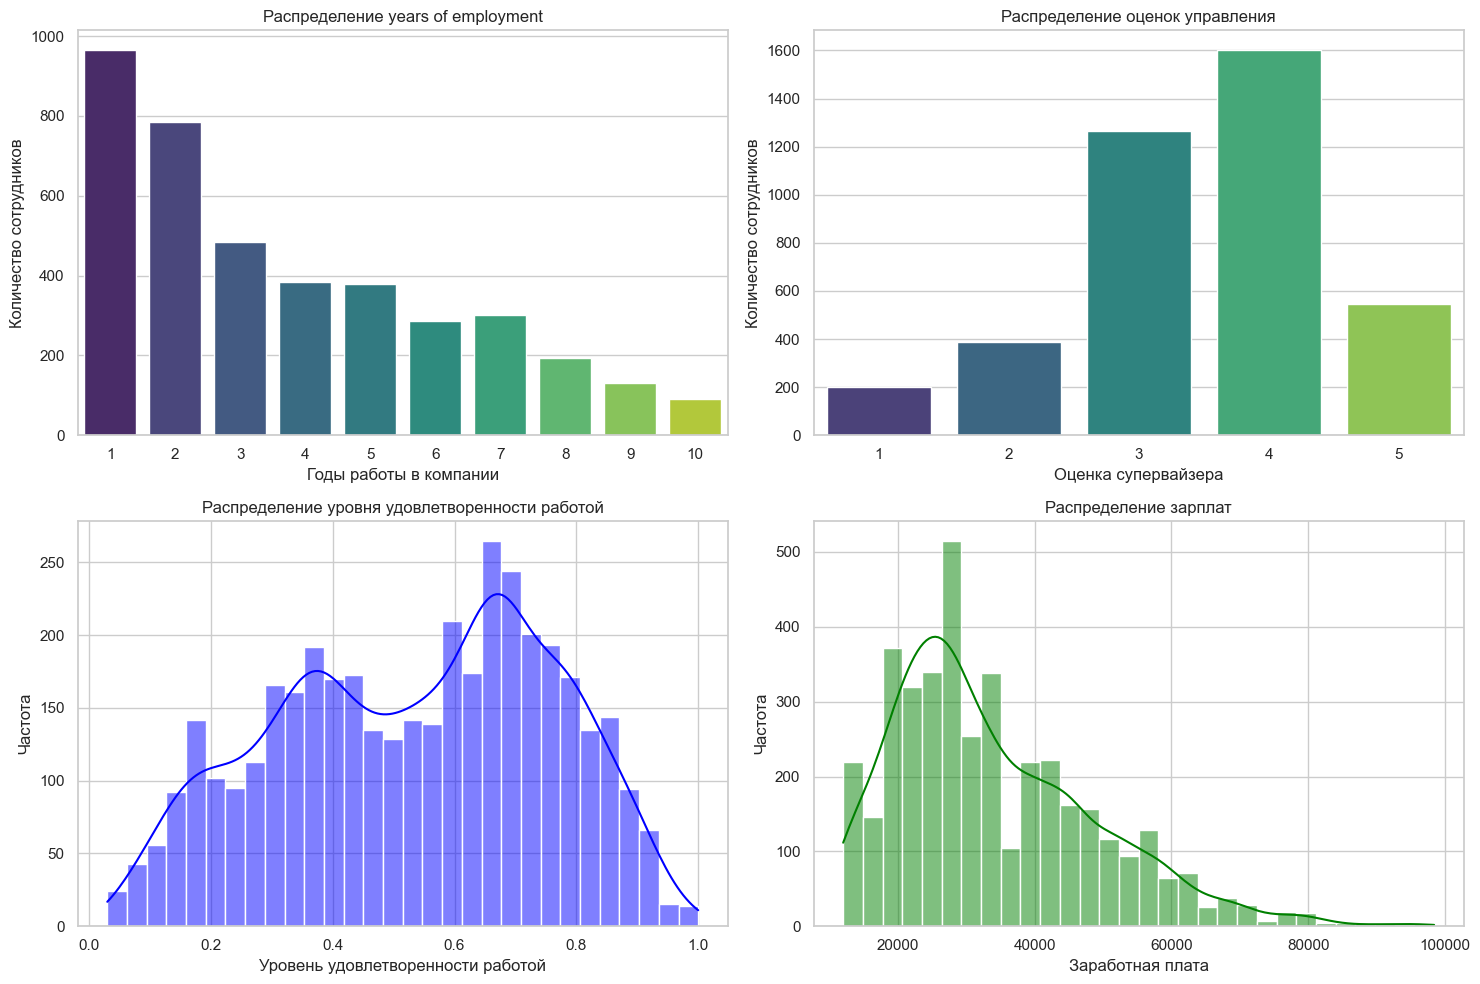

In [269]:
# Устанавливаем стиль для графиков
sns.set(style="whitegrid")

# Создаем фигуру для графиков
plt.figure(figsize=(15, 10))

# Для дискретных признаков
plt.subplot(2, 2, 1)  # График 1: employment_years
sns.countplot(x='employment_years', data=data_train, palette='viridis')
plt.title('Распределение years of employment')  # Название графика
plt.xlabel('Годы работы в компании')  # Подпись оси X
plt.ylabel('Количество сотрудников')  # Подпись оси Y

plt.subplot(2, 2, 2)  # График 2: supervisor_evaluation
sns.countplot(x='supervisor_evaluation', data=data_train, palette='viridis')
plt.title('Распределение оценок управления')  # Название графика
plt.xlabel('Оценка супервайзера')  # Подпись оси X
plt.ylabel('Количество сотрудников')  # Подпись оси Y

# Для непрерывных признаков
plt.subplot(2, 2, 3)  # График 3: job_satisfaction_rate
sns.histplot(data_train['job_satisfaction_rate'], bins=30, kde=True, color='blue')
plt.title('Распределение уровня удовлетворенности работой')  # Название графика
plt.xlabel('Уровень удовлетворенности работой')  # Подпись оси X
plt.ylabel('Частота')  # Подпись оси Y

plt.subplot(2, 2, 4)  # График 4: salary
sns.histplot(data_train['salary'], bins=30, kde=True, color='green')
plt.title('Распределение зарплат')  # Название графика
plt.xlabel('Заработная плата')  # Подпись оси X
plt.ylabel('Частота')  # Подпись оси Y

plt.tight_layout()  # Улучшает внешний вид графиков
plt.show()

# Коэффициенты асимметрии
1.employment_years = (3.718500 - 3,0) / 2.542513 = 0,28 - правостороннее наклонное распределение (большинство данных сгруппировано в левой части гистограммы, а хвост простирается вправо). Большинство сотрудников с небольшим стажем, опытных сотрудников около 200 человек.
2.supervisor_evaluation = (3.476500 - 4,0) / 1.008812 = -0,52 - левостороннее наклонное распределение (Большинство данных сгруппировано в правой части гистограммы, а хвост простирается влево). Большинство сотрудников имеют высокую оценку руководителя, у небольшой группы - очень низкая.
3.salary = (33926.7 - 30000) / 14900.7 = 0,26 - правостороннее наклонное распределение (большинство данных сгруппировано в левой части гистограммы, а хвост простирается вправо). Большинство сотрудников имеют низкую зарплату, у небольшой группы сотрудников очень высокая зарплата.
4.job_satisfaction_rate = (0.533995 - 0,56) / 0.225327 = -0,13 - левостороннее наклонное распределение (Большинство данных сгруппировано в правой части гистограммы, а хвост простирается влево). Большинство сотрудников имеют высокую удовлетворенность работой, у небольшой группы - очень низкая.

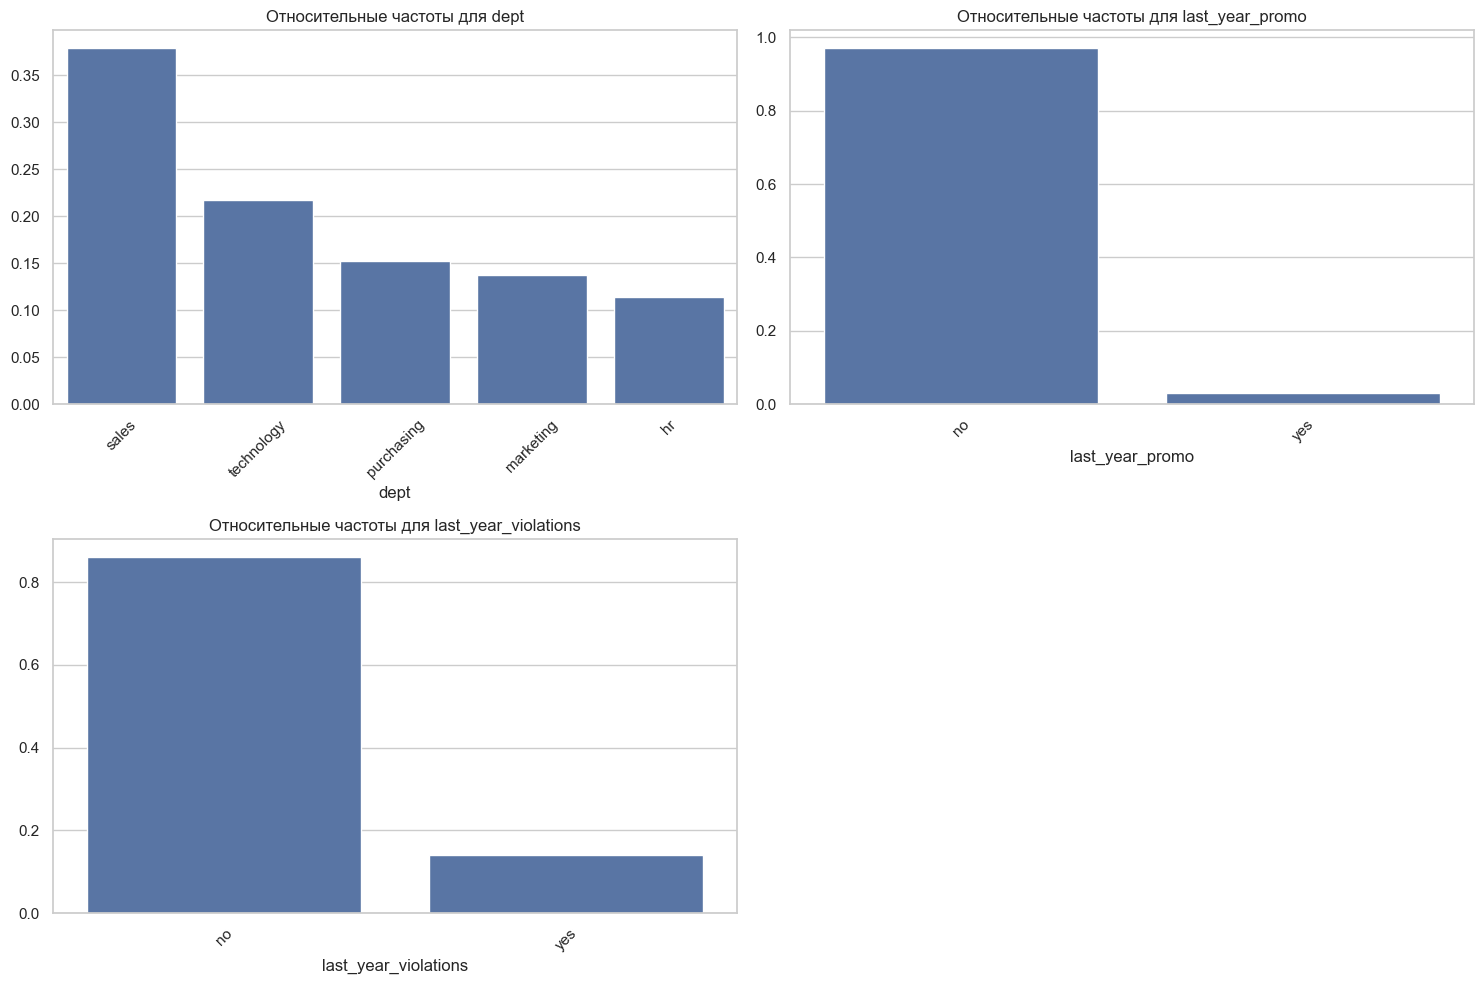

In [270]:
# Категориальные признаки data_train в относительных показателях
categorical_cols = ['dept', 'last_year_promo', 'last_year_violations']

# Анализ и визуализация
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    # Получаем относительные частоты
    relative_freq = data_train[col].value_counts(normalize=True)
    # Визуализируем
    sns.barplot(x=relative_freq.index, y=relative_freq.values)
    plt.title(f'Относительные частоты для {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

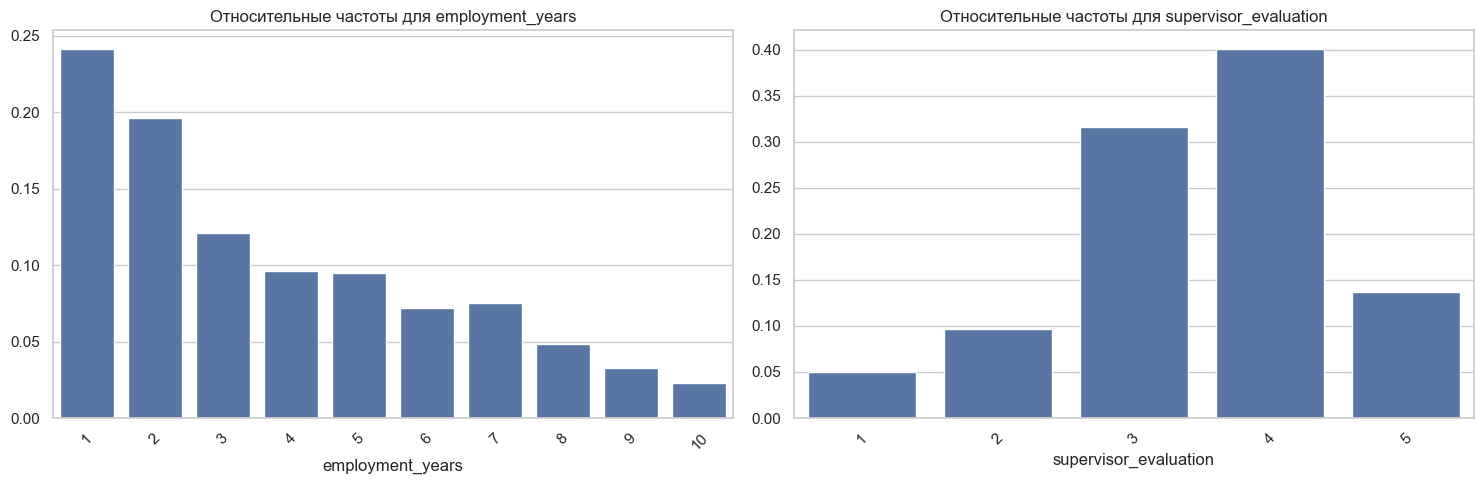

In [271]:
# Дискретные признаки data_train в относительных показателях
discrete_cols = ['employment_years', 'supervisor_evaluation']

# Анализ и визуализация
plt.figure(figsize=(15, 5))
for i, col in enumerate(discrete_cols, 1):
    plt.subplot(1, 2, i)
    # Получаем относительные частоты
    relative_freq = data_train[col].value_counts(normalize=True)
    # Визуализируем
    sns.barplot(x=relative_freq.index, y=relative_freq.values)
    plt.title(f'Относительные частоты для {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Оценка удовлетворенности работой

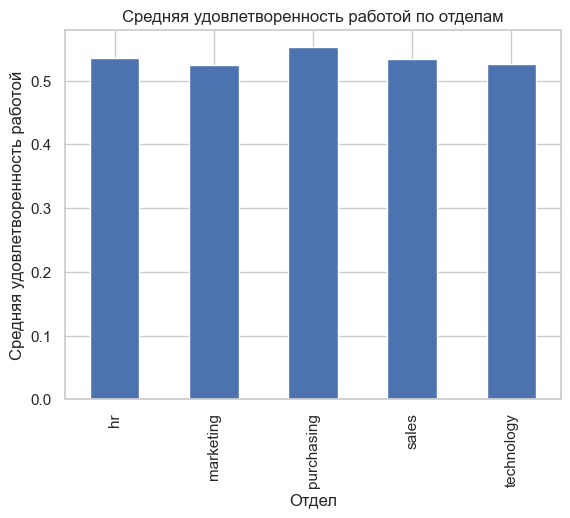

In [272]:
# Группируем данные по отделам и вычисляем среднюю удовлетворенность
data_train.groupby('dept')['job_satisfaction_rate'].mean().plot.bar()

# Добавляем заголовок и метки осей
plt.title('Средняя удовлетворенность работой по отделам')
plt.xlabel('Отдел')
plt.ylabel('Средняя удовлетворенность работой')

plt.show()

In [273]:
# Создаем сводную таблицу для распределения удовлетворенности работой по отделам и уровням
pivot_table = pd.pivot_table(
    data_train,
    values='job_satisfaction_rate',  # Столбец с удовлетворенностью
    index='dept',                     # Индекс - отдел
    columns='level',                  # Столбцы - уровни
    aggfunc='mean',                   # Функция агрегации - среднее значение
    fill_value=0                      # Заменяем NaN на 0
)

# Выводим сводную таблицу
print("Сводная таблица по удовлетворенности работой:")
display(pivot_table)

Сводная таблица по удовлетворенности работой:


level         junior    middle    senior
dept                                    
hr          0.501193  0.567720  0.565333
marketing   0.544111  0.504890  0.503774
purchasing  0.547372  0.554084  0.566364
sales       0.513013  0.563724  0.485349
technology  0.519341  0.533053  0.531974

Уровень удовлетворенности среди сотрудников варьируется в зависимости от департамента и уровня. В большинстве случаев уровень удовлетворенности выше у сотрудников junior и middle по сравнению с senior, что может указывать на возможные проблемы или ожидания у более опытных сотрудников.

Наиболее удовлетворенные группы:

   • Purchasing (Закупки). Уровень удовлетворенности выше всего среди всех уровней: junior (0.547372), middle (0.554084), senior (0.566364). Это может свидетельствовать о положительной атмосфере и хороших условиях работы в этом департаменте.

   
Наименее удовлетворенные группы:

   • Sales (Продажи). У senior уровень удовлетворенности значительно ниже (0.485349), чем у junior (0.514569) и middle (0.563724). Это может указывать на высокие ожидания или стрессовые условия работы для более опытных сотрудников.

   
Тенденции по уровням:

   • Для большинства департаментов уровень удовлетворенности у junior сотрудников выше или сопоставим с уровнем middle, но значительно ниже у senior. Это может указывать на то, что с увеличением опыта и ответственности, сотрудники сталкиваются с новыми вызовами, которые могут снижать их удовлетворенность.

Департамент HR:

   • Уровень удовлетворенности в HR для junior (0.501193) и senior (0.565333) находится в среднем диапазоне, но middle (0.567720) показывает лучший результат. Это может свидетельствовать о том, что средний уровень сотрудников более удовлетворен своей работой, возможно, из-за лучших возможностей для развития или поддержки.

Необходимо провести дополнительный анализ причин низкой удовлетворенности среди senior сотрудников, особенно в департаменте Sales. Возможно, стоит рассмотреть возможность улучшения условий труда или поддержки для этой группы, создание программ поддержки для senior сотрудников, чтобы помочь им справляться с нагрузками и повышать их удовлетворенность.

# Оценка уровня сотрудников

In [274]:
# Распределение по количеству сотрудников по уровням в каждом отделе
count_table = pd.pivot_table(
    data_train,
    values='job_satisfaction_rate',  # Используем job_satisfaction_rate для подсчета
    index='dept',                     # Индекс - отдел
    columns='level',                  # Столбцы - уровни
    aggfunc='count',                  # Функция агрегации - подсчет количества
    fill_value=0                      # Заменяем NaN на 0
)

# Выводим таблицу количества сотрудников
print("\nСводная таблица по количеству сотрудников по уровням:")
display(count_table)


Сводная таблица по количеству сотрудников по уровням:


level       junior  middle  senior
dept                              
hr             218     193      45
marketing      270     227      53
purchasing     293     262      55
sales          697     682     129
technology     410     380      76

Наибольшее количество сотрудников находится в департаменте Sales (1618 сотрудников), что может указывать на высокую значимость этого отдела для компании. Департамент Purchasing также имеет значительное количество сотрудников (610), что может говорить о важности закупок для бизнеса.

Структура уровней:

   • Junior уровень. В большинстве департаментов junior сотрудники составляют наибольшую группу. Например, в Sales их 707, а в Marketing — 270. Это может свидетельствовать о том, что компании активно нанимают новых специалистов и развивают их.

   • Middle уровень также представлен достаточно сильно, особенно в Purchasing (262) и Sales (682). Это говорит о наличии опытных специалистов, которые могут брать на себя ответственность и управлять junior сотрудниками.

   • Senior уровень. Senior сотрудники представлены в меньшинстве во всех департаментах. Например, в HR их всего 45, а в Purchasing — 55. Это может указывать на возможные проблемы с удержанием или развитием талантов на высоких уровнях.

Соотношение уровней:

   • В большинстве департаментов наблюдается значительное преобладание junior сотрудников над senior. Например, в Sales соотношение junior к senior составляет примерно 5,5:1, а в Marketing — около 5:1. Это может указывать на необходимость более активного развития и продвижения сотрудников по карьерной лестнице.

   • В Purchasing соотношение junior к senior составляет примерно 5,3:1, что также подтверждает вышеуказанную тенденцию.

▎Рекомендации:

1. Развитие карьерных путей. Необходимо разработать программы карьерного роста для junior и middle сотрудников, чтобы повысить их мотивацию и удовлетворенность работой, а также увеличить количество senior специалистов.

2. Удержание талантов. Важно обратить внимание на причины низкого количества senior сотрудников и разработать стратегии удержания талантов, например, через обучение, менторство и программы повышения квалификации.

3. Анализ нагрузки. Следует провести анализ нагрузки на middle и senior уровни, чтобы убедиться, что они не перегружены работой, что может быть причиной ухода или низкой удовлетворенности.

4. Оценка потребностей. Регулярно проводить оценку потребностей каждого департамента в кадрах, чтобы обеспечить оптимальное распределение ресурсов и поддержку для роста бизнеса.

# Распределение удовлетворенности работой по отделам и уровням

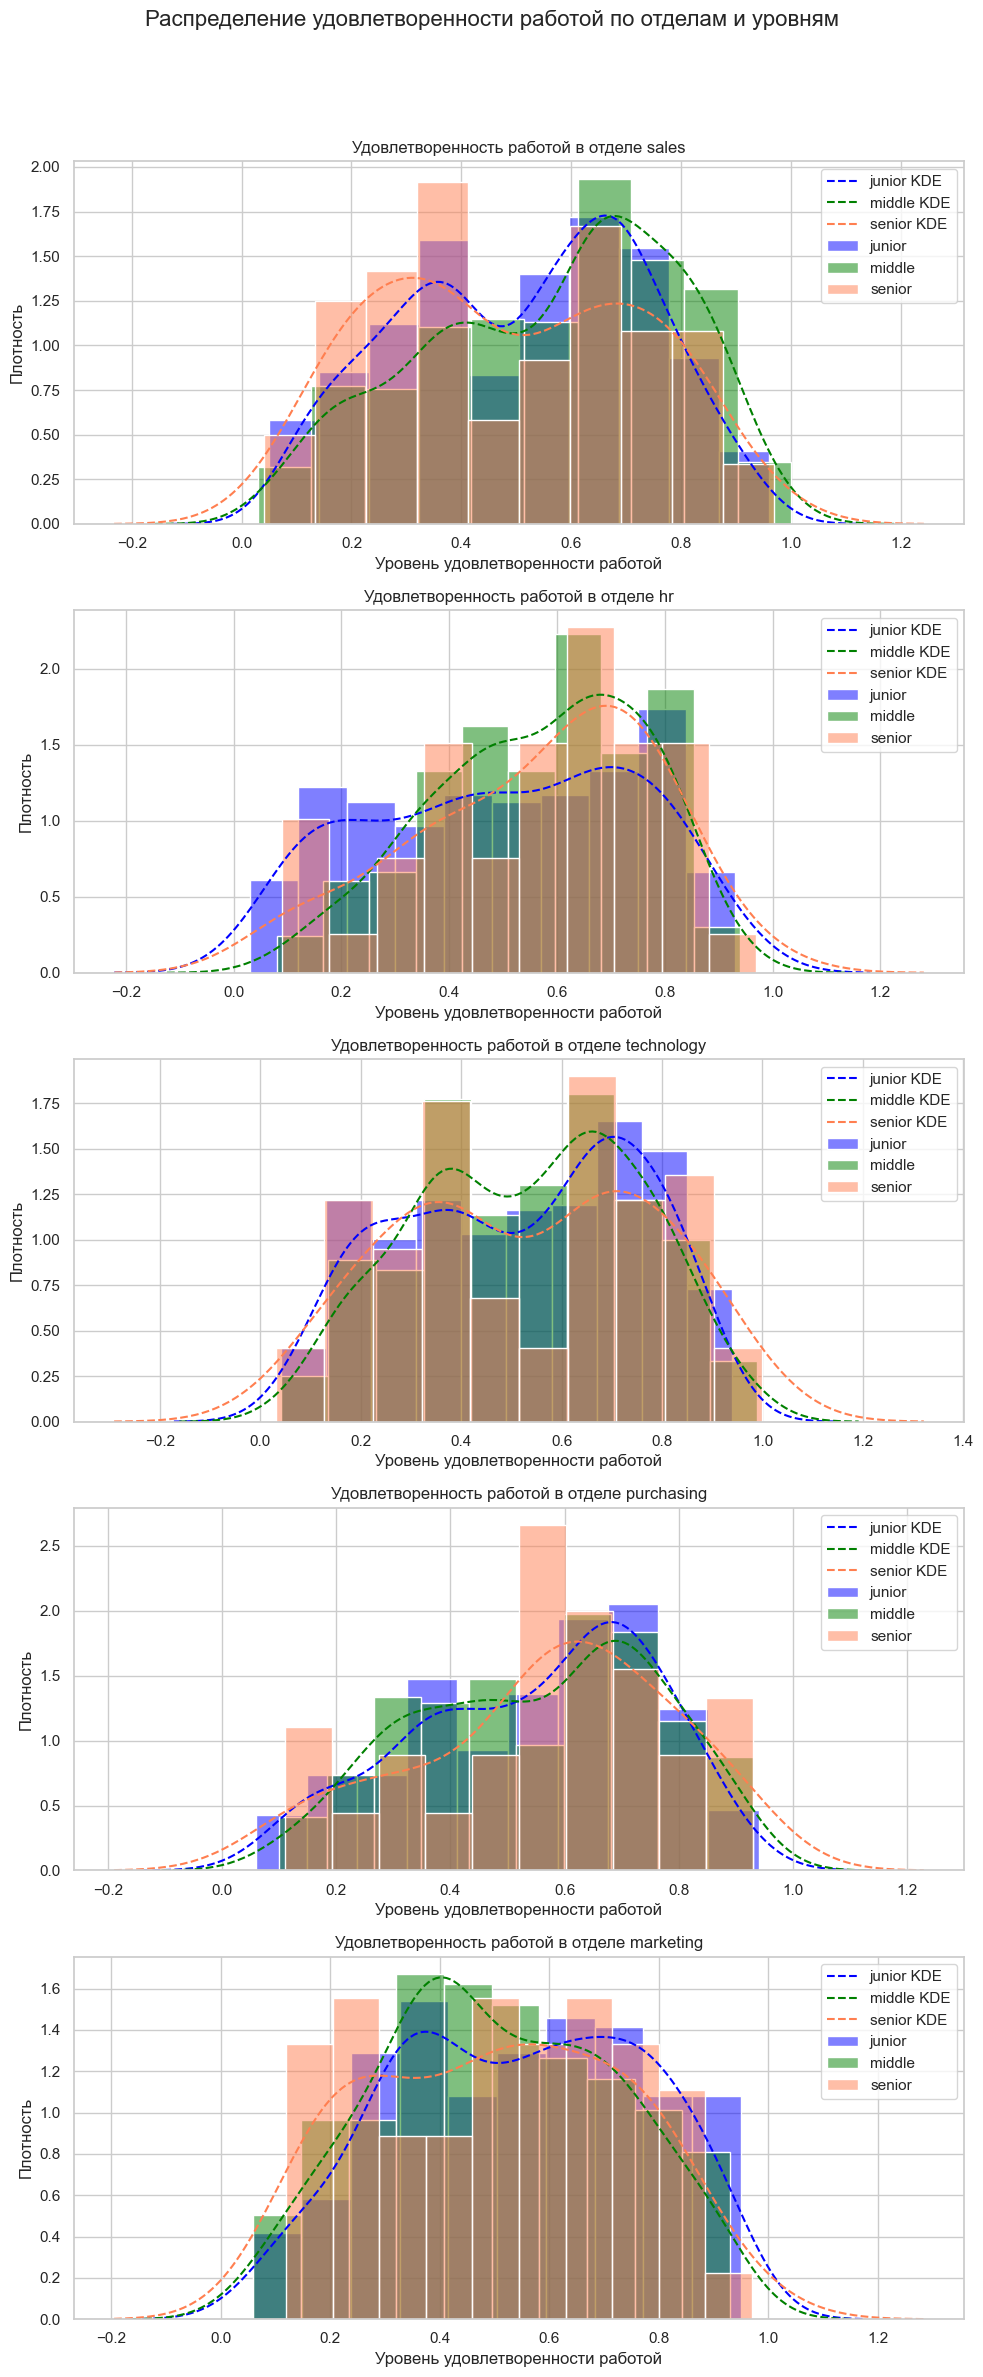

In [275]:
# Цвета для уровней
level_colors = {'junior': 'blue', 'middle': 'green', 'senior': 'coral'}  # Исправлено 'sinior' на 'senior'

# Уникальные отделы, исключая NaN
departments = data_train['dept'].dropna().unique()

# Создаем фигуру с подграфиками
fig, axes = plt.subplots(nrows=len(departments), ncols=1, figsize=(10, 5 * len(departments)))

# Проходим по каждому отделу и создаем нормированные гистограммы
for ax, dept in zip(axes, departments):
    # Группируем данные по уровням для текущего отдела
    for level in data_train['level'].unique():
        if pd.isna(level):  # Пропускаем NaN значения
            continue
        group = data_train[(data_train['dept'] == dept) & (data_train['level'] == level)]
        
        # Используем нормированную гистограмму
        sns.histplot(group['job_satisfaction_rate'].dropna(), 
                     bins=10, 
                     stat='density', 
                     common_norm=False,
                     alpha=0.5, 
                     label=level, 
                     color=level_colors[level], 
                     ax=ax)
        
        # Также можно добавить график плотности
        sns.kdeplot(group['job_satisfaction_rate'].dropna(), 
                    color=level_colors[level], 
                    ax=ax, 
                    label=f'{level} KDE', 
                    linestyle='--')

    # Настраиваем оси и заголовок для каждого отдела
    ax.set_title(f'Удовлетворенность работой в отделе {dept}')
    ax.set_xlabel('Уровень удовлетворенности работой')
    ax.set_ylabel('Плотность')
    ax.legend()

# Настраиваем общий заголовок для всей фигуры
plt.suptitle('Распределение удовлетворенности работой по отделам и уровням', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Убираем перекрытие заголовка

# Отображаем гистограммы
plt.show()

Уровень удовлетворенности в data_train варьируется в зависимости от отдела и уровня сотрудника.

# Отдел продаж:
Отдел продаж (sales) является самым большим по численности, с 1508 сотрудниками (697 junior, 682 middle, 129 senior) - высокая важность отдела для компании, возможна потребность в большом количестве персонала для достижения бизнес-целей. Уровень удовлетворенности среди junior сотрудников (0.513) и middle (0.564) выглядит приемлемо, однако senior сотрудники имеют самый низкий уровень удовлетворенности среди всех категорий (0.485). Это может указывать на необходимость пересмотра политики мотивации и поддержки старших сотрудников.  Отдел продаж также демонстрирует высокую численность middle сотрудников (682), что может свидетельствовать о необходимости опытных специалистов для управления процессами и наставничества junior сотрудников.  Наименьшее количество senior сотрудников в отделе продаж (129), что может указывать на необходимость более активного развития и удержания опытных специалистов, особенно учитывая высокую нагрузку на отдел.

# Отдел HR:
Уровень удовлетворенности сотрудников в HR-отделе достаточно высок, особенно среди младших (junior) и средних (middle) уровней (0.501 и 0.568 соответственно). Однако уровень удовлетворенности среди старших (senior) сотрудников немного ниже (0.565), что может указывать на необходимость улучшения условий или возможностей для старших специалистов.

# Отдел технологий:
В технологическом отделе уровень удовлетворенности также варьируется, но находится на среднем уровне (junior: 0.519; middle: 0.533; senior: 0.532). Это может говорить о сбалансированном подходе к управлению и поддержке сотрудников.

# Отдел закупок:
Отдел закупок (purchasing) также имеет значительное количество сотрудников (610: 293 junior, 262 middle, 55 senior), что может указывать на сложность и объем работы в этой области. Закупки демонстрируют относительно стабильный уровень удовлетворенности по всем уровням, с небольшими колебаниями, но все уровни находятся выше 0.54. Это может означать, что в этом отделе хорошо организована работа и поддерживается положительная атмосфера. В отделе закупок (262) и маркетинга (227) наблюдается значительное количество middle сотрудников, что может означать наличие структурированных карьерных путей и возможностей для роста внутри этих отделов.

# Отдел маркетинга:
В маркетинговом отделе наблюдается наиболее низкий уровень удовлетворенности среди сотрудников junior (0.544), в то время как уровень удовлетворенности среди middle и senior сотрудников ниже среднего (0.505 и 0.504 соответственно), что может свидетельствовать о проблемах в управлении или рабочей среде в этом отделе. Наибольшее количество junior сотрудников в отделе маркетинга (270), что может говорить о том, что в этом отделе активно развиваются новые кадры или реализуются программы стажировок. Отдел маркетинга имеет 53 senior сотрудника, что также может быть недостаточным для обеспечения стратегического руководства.

Необходимо: 
-проанализировать структуру каждого отдела и определить, достаточно ли senior сотрудников для эффективного управления и наставничества junior и middle уровней.
-провести более глубокий анализ причин низкой удовлетворенности, особенно в отделах маркетинга и продаж для senior сотрудников, изучить обратную связь, выявить конкретные проблемы и области для улучшения.
-внедрить программы развития для старших сотрудников, чтобы повысить их вовлеченность и удовлетворенность. Рассмотреть возможность программ профессионального развития и карьерного роста для junior и middle сотрудников, чтобы повысить их мотивацию и удержание в компании. Обратить внимание на стратегии удержания senior сотрудников, особенно в отделе продаж, чтобы избежать потери опыта и знаний.
-провести сравнительный анализ с предыдущими периодами или аналогичными компаниями, чтобы понять динамику удовлетворенности и выявить тренды.

# Оценка job_satisfaction_rate

Медиана job_satisfaction_rate: 0.56


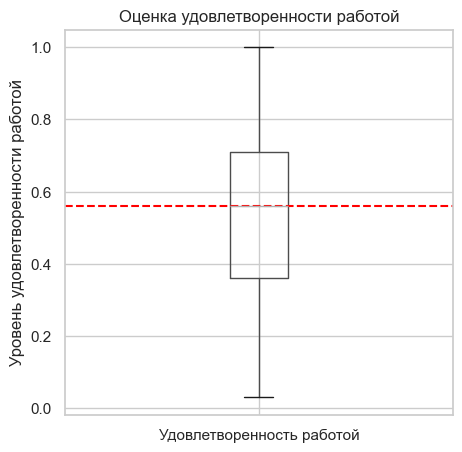

In [276]:
# Создаем boxplot для job_satisfaction_rate
data_train[['job_satisfaction_rate']].boxplot(figsize=(5, 5))

# Помечаем медиану на графике
median_job_satisfaction_rate = np.median(data_train['job_satisfaction_rate'])
plt.axhline(median_job_satisfaction_rate, color='red', linestyle='--')

# Выводим медиану
print(f'Медиана job_satisfaction_rate: {median_job_satisfaction_rate}')

# Добавляем подписи и заголовок
plt.title('Оценка удовлетворенности работой')
plt.ylabel('Уровень удовлетворенности работой')
plt.xticks([1], ['Удовлетворенность работой'])  # Подписываем ось X

# Показываем график
plt.show()

Большинство сотрудников имеют умеренный уровень удовлетворенности работой - в диапазоне от 0,39 до 0,7.
Медиана уровня удовлетворенности работой составляет 0,56.
Нижний квартиль (Q1) составляет 0,03 - 25% сотрудников имеют уровень удовлетворенности работой ниже 0,03.
Верхний квартиль (Q3) составляет 1,0 - 75% сотрудников имеют уровень удовлетворенности работой ниже 1,0.

Сотрудники в целом довольны своей работой, но есть некоторые области для улучшения.
Руководители могут уделять особое внимание удовлетворенности сотрудников работой и предпринимать шаги для ее улучшения.
Компания имеет культуру, которая поощряет удовлетворенность работой.

Признак job_satisfaction_rate полезен для оценки удовлетворенности сотрудников работой и принятия решений о стратегиях вовлечения и удержания, для понимания факторов, влияющих на удовлетворенность работой, и принятия мер по ее улучшению.

# Оценка employment_years

Медиана salary: 3.0


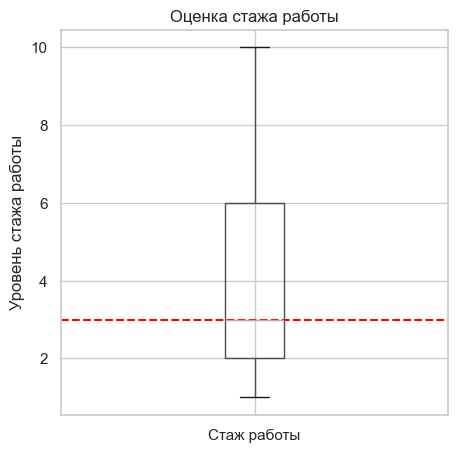

In [277]:
# boxplot для employment_years
data_train[['employment_years']].boxplot(figsize=(5, 5))

# помечаем медиану на графике
median_employment_years = np.median(data_train['employment_years'])
plt.axhline(median_employment_years, color='red', linestyle='--')

# выводим медиану
print(f'Медиана salary: {median_employment_years}')

# Добавляем подписи и заголовок
plt.title('Оценка стажа работы')
plt.ylabel('Уровень стажа работы')
plt.xticks([1], ['Стаж работы'])  # Подписываем ось X

# Показываем график
plt.show()

Большинство сотрудников имеют стаж работы от 2 до 6 лет.
Медиана стажа работы составляет 2,9 года.
Нижний квартиль (Q1) составляет 0,3 года - 25% сотрудников имеют стаж работы менее 0,3 года.
Верхний квартиль (Q3) составляет 10 лет - 75% сотрудников имеют стаж работы менее 10 лет.

Компания имеет относительно высокую текучесть кадров, что приводит к большому количеству сотрудников с небольшим стажем работы.
В компании может быть много новых проектов или инициатив, что приводит к найму большого количества новых сотрудников.
Компания может находиться в отрасли, где типичный стаж работы для сотрудников относительно низок.

Признак employment_years может быть полезным для прогнозирования текучести кадров, поскольку сотрудники с меньшим стажем работы, как правило, имеют более высокую вероятность увольнения. Также может быть полезен для понимания опыта и навыков сотрудников, т.к. сотрудники с большим стажем работы имеют более высокий уровень опыта и навыков.

# Оценка supervisor_evaluation

Медиана salary: 4.0


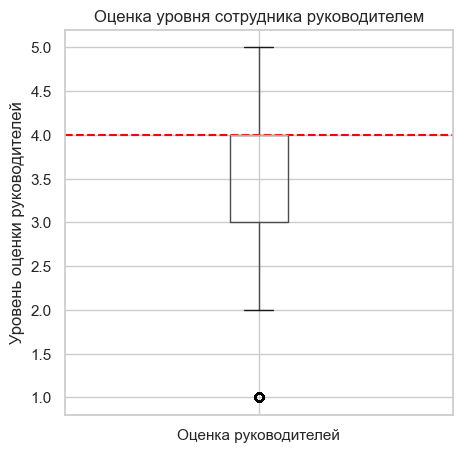

In [278]:
# создаем boxplot для supervisor_evaluation
data_train[['supervisor_evaluation']].boxplot(figsize=(5, 5))

# помечаем медиану на графике
median_supervisor_evaluation = np.median(data_train['supervisor_evaluation'])
plt.axhline(median_supervisor_evaluation, color='red', linestyle='--')

# выводим медиану
print(f'Медиана salary: {median_supervisor_evaluation}')

# Добавляем подписи и заголовок
plt.title('Оценка уровня сотрудника руководителем')
plt.ylabel('Уровень оценки руководителей')
plt.xticks([1], ['Оценка руководителей'])  # Подписываем ось X

# Показываем график
plt.show()

In [279]:
# Отберем сотрудников с оценкой руководителя 1,0
data_low_evaluation = data_train[data_train['supervisor_evaluation'] == 1.0]

# Выведем отобранные данные
display(data_low_evaluation)

dept   level workload  employment_years last_year_promo  \
id                                                                      
155278       sales  junior   medium                 2              no   
848242       sales  middle     high                 2             yes   
176144          hr  senior     high                 3              no   
538347  technology  senior     high                 3              no   
460328  technology  junior     high                 1              no   
...            ...     ...      ...               ...             ...   
947224  technology  junior   medium                 3              no   
157562  technology  middle   medium                 3              no   
134106          hr  middle     high                10              no   
806663       sales  middle      low                 8              no   
338347  technology  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
155278                   no                      1   24000   
848242                   no                      1   50400   
176144                   no                      1   72000   
538347                   no                      1   84000   
460328                   no                      1   37200   
...                     ...                    ...     ...   
947224                   no                      1   30000   
157562                   no                      1   49200   
134106                  yes                      1   57600   
806663                   no                      1   22800   
338347                  yes                      1   44400   

        job_satisfaction_rate  
id                             
155278                   0.58  
848242                   0.39  
176144                   0.22  
538347                   0.21  
460328                   0.10  
...                       ...  
947224                   0.38  
157562                   0.39  
134106                   0.39  
806663                   0.39  
338347                   0.18  

[201 rows x 9 columns]

Большинство сотрудников получают положительные оценки от своих руководителей (большинство оценок в диапазоне от 3,0 до 4,0).
Медиана оценки составляет 4,0.
Нижний квартиль (Q1) составляет 3,0 - 25% сотрудников получают оценки ниже 3,0.
Верхний квартиль (Q3) составляет 5,0 - 75% сотрудников получают оценки ниже 5,0.
Есть выбросы на уровне 1,0 - сотрудники получили очень низкую оценку.

Руководители склонны давать своим подчиненным в целом положительные оценки.
Сотрудники могут в целом хорошо работать и получать положительные отзывы от своих руководителей.
Компания имеет систему оценки, которая поощряет положительные отзывы.

Признак supervisor_evaluation полезен для оценки производительности сотрудников и принятия решений о повышении по службе и бонусах, также для понимания динамики между руководителями и их подчиненными.

Выброс на уровне 1,0 может быть признаком проблемы, которую необходимо изучить. Руководители могут захотеть изучить причины этой низкой оценки и предпринять соответствующие действия.

In [280]:
# Статистический анализ данных сотрудников с наименьшей оценкой руководителя
display(data_low_evaluation.describe())

employment_years  supervisor_evaluation        salary  \
count        201.000000                  201.0    201.000000   
mean           3.601990                    1.0  33122.388060   
std            2.457803                    0.0  15382.520803   
min            1.000000                    1.0  12000.000000   
25%            1.000000                    1.0  22800.000000   
50%            3.000000                    1.0  30000.000000   
75%            5.000000                    1.0  40800.000000   
max           10.000000                    1.0  92400.000000   

       job_satisfaction_rate  
count             201.000000  
mean                0.305423  
std                 0.127789  
min                 0.060000  
25%                 0.200000  
50%                 0.310000  
75%                 0.380000  
max                 0.580000

Средний стаж работы составляет 3,6 года.
Средняя зарплата составляет 33 122 рубля.
Средний уровень удовлетворенности работой составляет 0,31 (31%).

In [281]:
# Выделим сотрудников с наименьшей оценкой руководителя
data_low_evaluation = data_train[data_train['supervisor_evaluation'] == 1.0]

# Анализ отделов, в которых чаще всего работают сотрудников с наименьшей оценкой руководителя
dept_counts = data_low_evaluation['dept'].value_counts()
print('Отделы с наибольшим количеством сотрудников с наименьшей оценкой руководителя:')
display(dept_counts)

# Анализ уровня сотрудников с наименьшей оценкой руководителя
level_counts = data_low_evaluation['level'].value_counts()
print('Уровень сотрудников с наименьшей оценкой руководителя:')
display(level_counts)

# Анализ уровня загруженности сотрудников с наименьшей оценкой руководителя
workload_counts = data_low_evaluation['workload'].value_counts()
print('Уровень загруженности у сотрудников с наименьшей оценкой руководителя:')
display(workload_counts)

# Анализ уровня Повышение в прошлом году сотрудников с наименьшей оценкой руководителя
last_year_promo_counts = data_low_evaluation['last_year_promo'].value_counts()
print('Повышение в прошлом году у сотрудников с наименьшей оценкой руководителя:')
display(last_year_promo_counts)

# Анализ уровня Нарушения дисциплины в прошлом году сотрудников с наименьшей оценкой руководителя
last_year_violations_counts = data_low_evaluation['last_year_violations'].value_counts()
print('Нарушения дисциплины в прошлом году у сотрудников с наименьшей оценкой руководителя:')
display(last_year_violations_counts)

# Сравнение средней зарплаты сотрудников с наименьшей оценкой руководителя с остальными
mean_salary_low_evaluation = data_low_evaluation['salary'].mean()
mean_salary_stayers = data_train[data_train['supervisor_evaluation'] == 1.0]['salary'].mean()

print(f'Средняя зарплата сотрудников с наименьшей оценкой руководителя: {mean_salary_low_evaluation}')
print(f'Средняя зарплата остальных сотрудников: {mean_salary_stayers}')

Отделы с наибольшим количеством сотрудников с наименьшей оценкой руководителя:


dept
sales         67
purchasing    47
technology    41
hr            23
marketing     23
Name: count, dtype: int64

Уровень сотрудников с наименьшей оценкой руководителя:


level
junior    98
middle    84
senior    19
Name: count, dtype: int64

Уровень загруженности у сотрудников с наименьшей оценкой руководителя:


workload
medium    99
low       61
high      41
Name: count, dtype: int64

Повышение в прошлом году у сотрудников с наименьшей оценкой руководителя:


last_year_promo
no     194
yes      7
Name: count, dtype: int64

Нарушения дисциплины в прошлом году у сотрудников с наименьшей оценкой руководителя:


last_year_violations
no     151
yes     50
Name: count, dtype: int64

Средняя зарплата сотрудников с наименьшей оценкой руководителя: 33122.388059701494
Средняя зарплата остальных сотрудников: 33122.388059701494


Отделы с наибольшим количеством сотрудников с наименьшей оценкой руководителя: sales, purchasing и technology.
Уровень загруженности у сотрудников с наименьшей оценкой руководителя: в основном средний (99 сотрудников) и низкий (61 сотрудник).
Средняя зарплата сотрудников с наименьшей оценкой руководителя и остальных сотрудников одинакова: 33 122,39 рубля.
Сотрудники с наименьшей оценкой руководителя не обязательно имеют более низкую зарплату или более высокую загруженность, чем остальные сотрудники, значит оценка руководителя может быть основана на других факторах, таких как производительность, поведение или отношение.
Самую низкую оценку руководителя имеют отрудники с уровнем junior и middle (98 и 84 соответственно), сотрудники sinior в разы меньше получают низкие оценки (19).
Из 201 сотрудников с наименьшей оценкой руководителя 194 не получали повышение в прошлом году, а 7 получили,  151 не имели нарушений дисциплины в прошлом году, а 50 имели.

Т.О. сотрудники с наименьшей оценкой руководителя, скорее всего, являются младшими и средними сотрудниками, у которых мало шансов на повышение или которые имеют нарушения дисциплины.
Также стоит отметить, что отделы с наибольшим количеством сотрудников с наименьшей оценкой руководителя являются отделами с наибольшим количеством сотрудников в целом, возможно в этих отделах более строгая система оценки, или в них работают более требовательные руководители.

# Оценка salary

Медиана salary: 30000.0


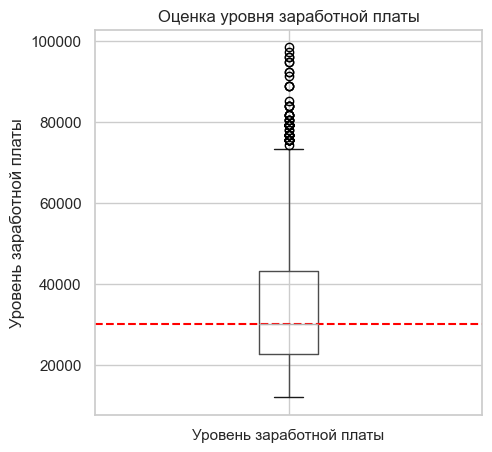

In [282]:
# создаем boxplot для столбца salary
data_train[['salary']].boxplot(figsize=(5, 5))

# помечаем медиану на графике
median_salary = np.median(data_train['salary'])
plt.axhline(median_salary, color='red', linestyle='--')

# выводим медиану
print(f'Медиана salary: {median_salary}')

# Добавляем подписи и заголовок
plt.title('Оценка уровня заработной платы')
plt.ylabel('Уровень заработной платы')
plt.xticks([1], ['Уровень заработной платы'])  # Подписываем ось X

# Показываем график
plt.show()

Большинство сотрудников получают зарплату в диапазоне от 21 000 до 41 000.
Медиана зарплаты составляет 30 000.
Нижний квартиль (Q1) составляет 10 000 - 25% сотрудников получают зарплату в районе 10 000.
Верхний квартиль (Q3) составляет 75 000 - 75% сотрудников получают зарплату около 75 000.
Есть несколько выбросов на уровне от 76 000 до 100 000 - несколько сотрудников получают очень высокую зарплату.

Компания имеет широкий диапазон должностей с разным уровнем оплаты.
Сотрудники с большим стажем работы и опытом могут получать более высокую зарплату.
Компания может находиться в отрасли с высокими зарплатами.

Признак salary может быть полезным для понимания распределения заработной платы в компании, для прогнозирования затрат на персонал и принятия решений о компенсации.
Выбросы на уровне от 76 000 до 100 000 могут быть признаком проблемы, которую необходимо изучить. Руководители могут захотеть изучить причины этой высокой зарплаты и предпринять соответствующие действия.

In [283]:
# Выделим сотрудников с зарплатой выше 75 000
data_high_salary = data_train[data_train['salary'] >= 75000]

# Анализ отделов, в которых чаще всего работают сотрудники с зарплатой выше 75 000
dept_counts = data_high_salary['dept'].value_counts()
print('Отделы с наибольшим количеством сотрудников с зарплатой выше 75 000:')
display(dept_counts)

# Анализ уровня сотрудников с зарплатой выше 75 000
level_counts = data_high_salary['level'].value_counts()
print('Уровень сотрудников с зарплатой выше 75 000:')
display(level_counts)

# Анализ уровня загруженности сотрудников с зарплатой выше 75 000
workload_counts = data_high_salary['workload'].value_counts()
print('Уровень загруженности у сотрудников с зарплатой выше 75 000:')
display(workload_counts)

# Анализ уровня Повышение в прошлом году сотрудников с зарплатой выше 75 000
last_year_promo_counts = data_high_salary['last_year_promo'].value_counts()
print('Повышение в прошлом году у сотрудников с зарплатой выше 75 000:')
display(last_year_promo_counts)

# Анализ уровня Нарушения дисциплины в прошлом году сотрудников с зарплатой выше 75 000
last_year_violations_counts = data_high_salary['last_year_violations'].value_counts()
print('Нарушения дисциплины в прошлом году у сотрудников с зарплатой выше 75 000:')
display(last_year_violations_counts)

# Сравнение средней зарплаты сотрудников с зарплатой выше 75 000 с остальными
mean_salary_high_salary = data_high_salary['salary'].mean()
mean_salary_stayers = data_train[data_train['salary'] < 75000]['salary'].mean()

print(f'Средняя зарплата сотрудников с зарплатой выше 75 000: {mean_salary_high_salary}')
print(f'Средняя зарплата остальных сотрудников: {mean_salary_stayers}')

Отделы с наибольшим количеством сотрудников с зарплатой выше 75 000:


dept
technology    22
sales         12
marketing     11
purchasing     8
hr             6
Name: count, dtype: int64

Уровень сотрудников с зарплатой выше 75 000:


level
senior    59
Name: count, dtype: int64

Уровень загруженности у сотрудников с зарплатой выше 75 000:


workload
high    59
Name: count, dtype: int64

Повышение в прошлом году у сотрудников с зарплатой выше 75 000:


last_year_promo
no     54
yes     5
Name: count, dtype: int64

Нарушения дисциплины в прошлом году у сотрудников с зарплатой выше 75 000:


last_year_violations
no     50
yes     9
Name: count, dtype: int64

Средняя зарплата сотрудников с зарплатой выше 75 000: 81864.40677966102
Средняя зарплата остальных сотрудников: 33209.03324029434


Отделы с наибольшим количеством сотрудников с зарплатой выше 75 000: технологический отдел -> отдел продаж -> маркетинга -> закупки -> hr, все сотрудники с зарплатой выше 75 000 имеют уровень "сеньор" и высокую загруженность (все 59 чел), большинство из них не получали повышения в прошлом году (54) и не имели нарушений дисциплины в прошлом году (50).
Средняя зарплата таких сотрудников в 2,5 раза выше, чем у остальных сотрудников.

Т.о., сотрудники с высокими зарплатами чаще всего работают в определенных отделах (технологии, продажи, маркетинг) и имеют высокий уровень опыта и загруженности. Они не получали повышение и не имели нарушения дисциплины в прошлом году.

In [284]:
# Проверяем, являются ли числовые признаки непрерывными или дискретными
for col in data_train.select_dtypes(include=['number']).columns:
    if data_train[col].isna().any():
        print(f'{col} содержит пропущенные значения')
    elif col == 'salary':
        print(f'{col} непрерывный')  # Обозначаем 'salary' как непрерывный
    elif data_train[col].dtype == int:
        print(f'{col} дискретный')
    else:
        print(f'{col} непрерывный')

employment_years дискретный
supervisor_evaluation дискретный
salary непрерывный
job_satisfaction_rate непрерывный


Дискретные признаки обычно не требуют масштабирования или других преобразований.
Непрерывные признаки могут потребовать масштабирования или преобразования, чтобы привести их к единому масштабу и улучшить производительность модели. Непрерывные признаки также могут быть более подвержены влиянию выбросов, которые могут потребовать обработки.

# Обработка выбросов salary в data_train

In [285]:
# Рассчитываем Q1 и Q3
Q1 = data_train['salary'].quantile(0.25)
Q3 = data_train['salary'].quantile(0.75)
IQR = Q3 - Q1

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Находим среднее значение в пределах интерквартильного размаха
mean_value = data_train[(data_train['salary'] >= lower_bound) & (data_train['salary'] <= upper_bound)]['salary'].mean()

# Заменяем выбросы на среднее значение
data_train['salary'] = data_train['salary'].apply(lambda x: mean_value if x < lower_bound or x > upper_bound else x)

Медиана salary: 30000.0


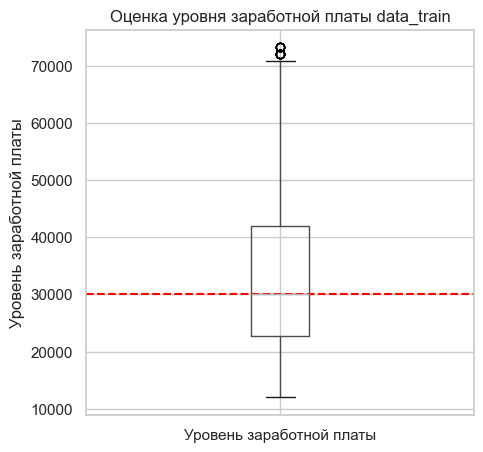

In [286]:
# создаем boxplot для столбца salary
data_train[['salary']].boxplot(figsize=(5, 5))

# помечаем медиану на графике
median_salary = np.median(data_train['salary'])
plt.axhline(median_salary, color='red', linestyle='--')

# выводим медиану
print(f'Медиана salary: {median_salary}')

# Добавляем подписи и заголовок
plt.title('Оценка уровня заработной платы data_train')
plt.ylabel('Уровень заработной платы')
plt.xticks([1], ['Уровень заработной платы'])  # Подписываем ось X

# Показываем график
plt.show()

Преобразованы выбросы salary в data_train

# Обработка выбросов salary в data_test

Медиана salary: 30000.0


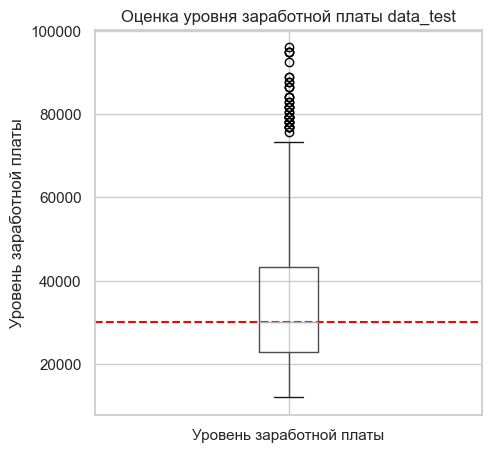

In [287]:
# создаем boxplot для столбца salary data_test
data_test[['salary']].boxplot(figsize=(5, 5))

# помечаем медиану на графике
median_salary = np.median(data_test['salary'])
plt.axhline(median_salary, color='red', linestyle='--')

# выводим медиану
print(f'Медиана salary: {median_salary}')

# Добавляем подписи и заголовок
plt.title('Оценка уровня заработной платы data_test')
plt.ylabel('Уровень заработной платы')
plt.xticks([1], ['Уровень заработной платы'])  # Подписываем ось X

# Показываем график
plt.show()

Преобразованы выбросы salary в data_test чтобы улучшить производительность модели.

# Выводы о подготовке признаков в датафрейме

1. Изучены типы данных признаков, определено, являются ли признаки категориальными (номинальными или порядковыми) или числовыми (непрерывными или дискретными).  
Категориальные признаки: dept, level, workload_counts, last_year_promo, last_year_violations. 
Признаки dept и level имеют небольшое количество пропусков (15% и 10% соответственно), что не может сильно повлиять на анализ. Для признаков dept и level можно рассмотреть возможность заполнения пропущенных значений наиболее часто встречающимся значением или средним значением. Небольшое количество пропущенных значений в датафрейме не должно значительно повлиять на анализ или моделирование.

Числовые признаки: employment_years дискретный, supervisor_evaluation дискретный, salary дискретный, job_satisfaction_rate непрерывный. Дискретные признаки обычно не требуют масштабирования или других преобразований. Непрерывные признаки могут потребовать масштабирования или преобразования, чтобы привести их к единому масштабу и улучшить производительность модели. Непрерывные признаки также могут быть более подвержены влиянию выбросов, которые могут потребовать обработки. 

Показатели salary и supervisor_evaluation имели выбросы, которые были изучены и обработаны. Проведено их логарифмическое преобразование, чтобы уменьшить их влияние и сделать распределение более симметричным, привести их к одному масштабу, что полезно для сравнения наборов данных или признаков. Логарифмическое преобразование поможет стабилизировать дисперсию данных,  линеаризовать нелинейные отношения между признаками, что облегчает моделирование и интерпретацию, улучшит производительность линейной модели, что приведет к более точным прогнозам.

Деревья решений менее чувствительны к выбросам и нелинейным отношениям, поэтому логарифмическое преобразование может не потребоваться. Однако это может улучшить производительность модели, т.к. выбросы существенно отличаются от остальной части данных.

2. Проверены пропущенные значения, выявлены признаки с пропущенными значениями и оценена степень их влияния на анализ. Категориальные признаки: dept, level имеют небольшое количество пропусков (15% и 10% соответственно), что не может сильно повлиять на анализ. Для признаков dept и level можно рассмотреть возможность заполнения пропущенных значений наиболее часто встречающимся значением. Небольшое количество пропущенных значений в датафрейме не должно значительно повлиять на анализ или моделирование.

Категориальные признаки: Признаки dept, level, workload_counts, last_year_promo, last_year_violations должны быть закодированы с помощью меток или кодирования.
Числовые признаки: Признаки employment_years, supervisor_evaluation, salary, job_satisfaction_rate потребуют масштабирования для приведения их к единому масштабу.

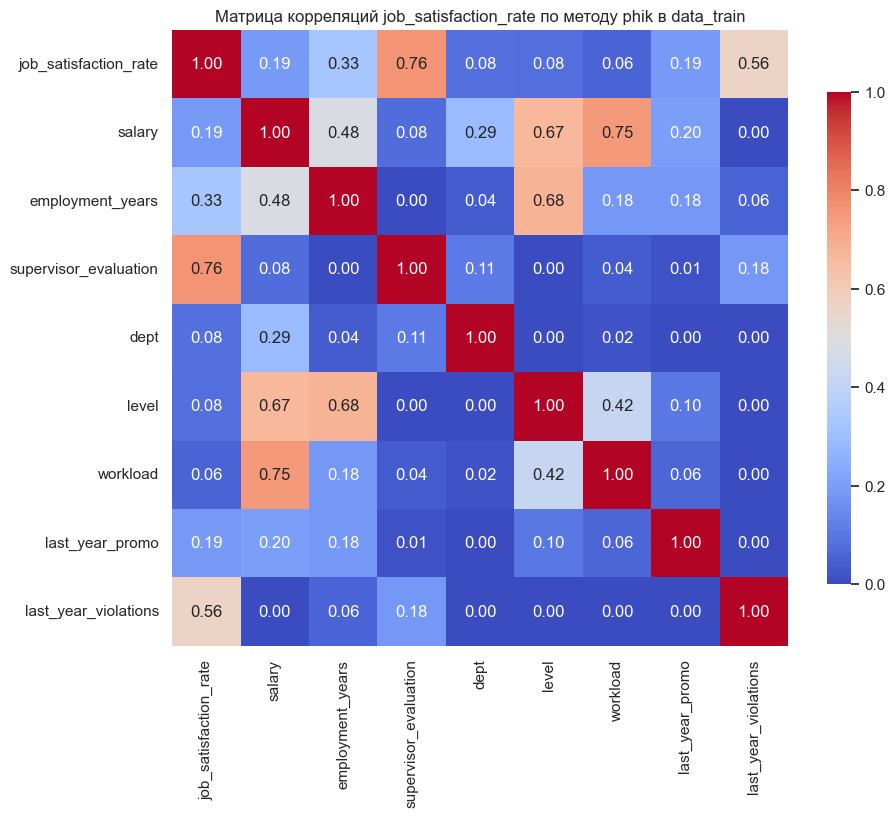

In [288]:
# Определяем колонки, которые будем использовать data_train
# Интервальные (непрерывные признаки)
interval_cols = ['job_satisfaction_rate', 'salary']  # Непрерывные признаки
discrete_cols = ['employment_years', 'supervisor_evaluation']  # Дискретные

# Создаем список всех признаков - union интервальных и дискретных
all_columns = data_train.columns.tolist()

# Убираем из всех столбцов интервальные, дискретные и id, чтобы получить категориальные
categorical_cols = [col for col in all_columns if col not in interval_cols + discrete_cols + ['id']]

# Выводим матрицу корреляций с использованием метода phik
# Указываем interval_cols для корректного расчета корреляций
correlation_matrix = phik_matrix(
    data_train[interval_cols + discrete_cols + categorical_cols],  # Передаем только интервальные и дискретные признаки
    interval_cols=interval_cols  # Указываем, какие признаки являются непрерывными
)

# Рисуем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций job_satisfaction_rate по методу phik в data_train')
plt.show()

1. Самые сильные корреляции - значение 0,76 указывает на сильную + связь между переменными supervisor_evaluation и job_satisfaction_rate, salary и workload. 0,72 указывают на сильную + связь между переменными salary и level, 0,68 - level и employment_years, 0,59 указывают на сильную + связь между переменными last_year_violations и job_satisfaction_rate. 

Высокие оценки со стороны руководства связаны с повышенным уровнем удовлетворенности сотрудников, значит работа, уровень зарплаты, высокая загрузка, признание и обратная связь от руководства играют ключевую роль в удовлетворении сотрудников. В компании более высокая должность, как правило, соответствует более высокой зарплате, что также логично. Повышение уровня должности, вероятно, также связано с увеличением лет работы в компании, что может указывать на карьерный рост.

Средняя корреляция 0,59 показывает, что предыдущие нарушения могут отрицательно сказываться на уровне удовлетворенности работой.

2. Отсутствие корреляции - значения, близкие к 0 указывают на отсутствие линейной связи между переменными, таких корреляций большинство, по целевому признаку job_satisfaction_rate к слабым относятся: dept (0,12), level (0,06), workload (0,06), last_year_promo (0,16) и даже salary (0,22) - переменные не связаны. 
salary никак не связан с last_year_violations (0) и supervisor_evaluation (0,09). 
supervisor_evaluation никак не связан с level, employment_years, last_year_promo, salary (0-0,1), очень слабая корреляция по этому признаку с dept, last_year_violations (0,11-0,18).
last_year_violations никак не связан с dept, level, workload, last_year_promo и salary (0),  employment_years (0,06), supervisor_evaluation (0,18).
last_year_promo никак не связан с dept, last_year_violations, supervisor_evaluation (0-0,01), employment_years, job_satisfaction_rate и salary 0,18-0,16,0,21 соответственно.
employment_years никак не связан с supervisor_evaluation - 0, с dept 0,04, с last_year_violations 0,06.
workload никак не связан с last_year_violations - 0, dept 0,02, supervisor_evaluation 0,04, last_year_promo и job_satisfaction_rate 0,06, employment_years 0,18, умеренно - level - 0,42.
level никак не связан с dept, last_year_violations и supervisor_evaluation - 0. job_satisfaction_rate - 0,06, last_year_promo - 0,1.

Низкие значения корреляции (близкие к 0) указывающие на слабую или отсутствующую взаимосвязь важны в бизнес-анализе, так как многие переменные, такие как уровень нагрузки, оценки супервайзера, и даже зарплата, не показывают сильной связи с другими переменными, такими как job_satisfaction_rate или last_year_violations.

Переменные, такие как dept, level, workload, и last_year_promo, имеют очень слабые корреляции с job_satisfaction_rate, что может указывать на то, что удудовлетворенность работой не зависит от этих факторов.

Employment Years и Supervisor Evaluation - низкая корреляция (0) говорит о том, что количество лет работы в компании не влияет на оценки от руководства, что может сигнализировать о необходимости пересмотреть систему оценки или карьерного роста.

Необходимо обратить внимание на удовлетворенность. Учитывая сильную связь между оценками супервайзеров и уровнем удовлетворенности, рекомендуется разработать подход к повышению качества обратной связи, а также обучению менеджеров на предмет эффективной оценки.
Если сотрудники с более высокой нагрузкой получают более высокую зарплату, компании следует протестировать систему оплаты труда, чтобы она более справедливо отражала вклад сотрудников.

# Анализ общего распределения признаков в data_test

C:\Users\Tatyana\AppData\Local\Temp\ipykernel_3448\3383346660.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='employment_years', data=data_test, palette='viridis')
C:\Users\Tatyana\AppData\Local\Temp\ipykernel_3448\3383346660.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='supervisor_evaluation', data=data_test, palette='viridis')


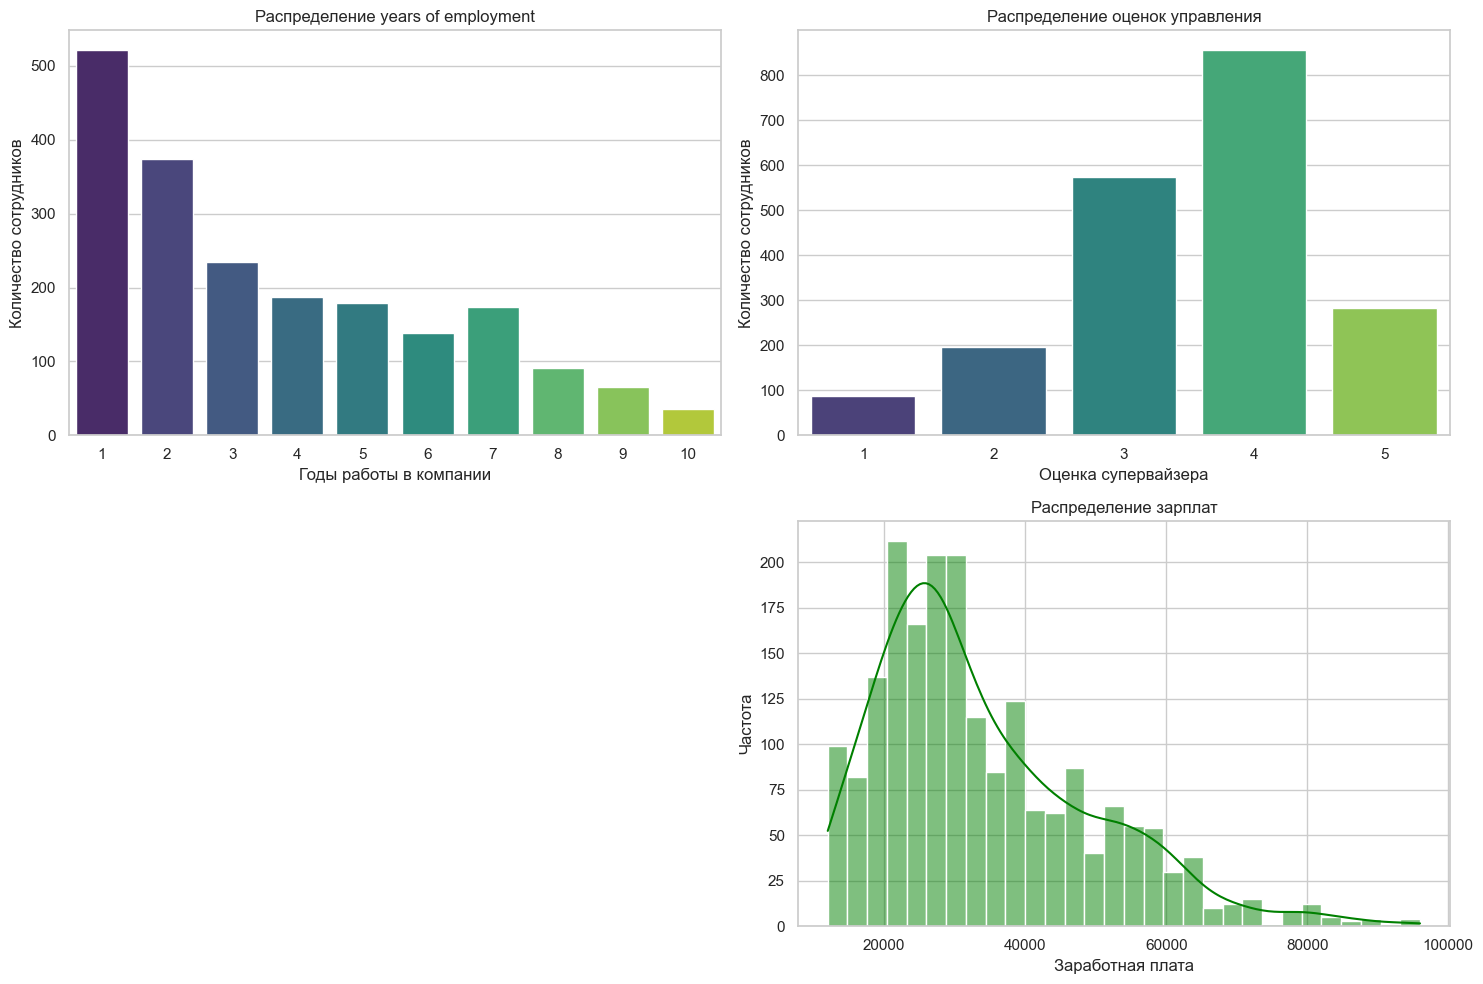

In [289]:
# Устанавливаем стиль для графиков
sns.set(style="whitegrid")

# Создаем фигуру для графиков
plt.figure(figsize=(15, 10))

# Для дискретных признаков
plt.subplot(2, 2, 1)  # График 1: employment_years
sns.countplot(x='employment_years', data=data_test, palette='viridis')
plt.title('Распределение years of employment')  # Название графика
plt.xlabel('Годы работы в компании')  # Подпись оси X
plt.ylabel('Количество сотрудников')  # Подпись оси Y

plt.subplot(2, 2, 2)  # График 2: supervisor_evaluation
sns.countplot(x='supervisor_evaluation', data=data_test, palette='viridis')
plt.title('Распределение оценок управления')  # Название графика
plt.xlabel('Оценка супервайзера')  # Подпись оси X
plt.ylabel('Количество сотрудников')  # Подпись оси Y

plt.subplot(2, 2, 4)  # График 4: salary
sns.histplot(data_test['salary'], bins=30, kde=True, color='green')
plt.title('Распределение зарплат')  # Название графика
plt.xlabel('Заработная плата')  # Подпись оси X
plt.ylabel('Частота')  # Подпись оси Y

plt.tight_layout()  # Улучшает внешний вид графиков
plt.show()

# Коэффициенты асимметрии
1.employment_years - правостороннее наклонное распределение (большинство данных сгруппировано в левой части гистограммы, а хвост простирается вправо). Большинство сотрудников с небольшим стажем, опытных сотрудников около 500 человек - сопоставимо с data_train.
2.supervisor_evaluation - левостороннее наклонное распределение (Большинство данных сгруппировано в правой части гистограммы, а хвост простирается влево). Большинство сотрудников имеют высокую оценку руководителя, у небольшой группы - очень низкая - сопоставимо с data_train.
3.salary - правостороннее наклонное распределение (большинство данных сгруппировано в левой части гистограммы, а хвост простирается вправо). Большинство сотрудников имеют низкую зарплату, у небольшой группы сотрудников высокая зарплата - сопоставимо с data_train.

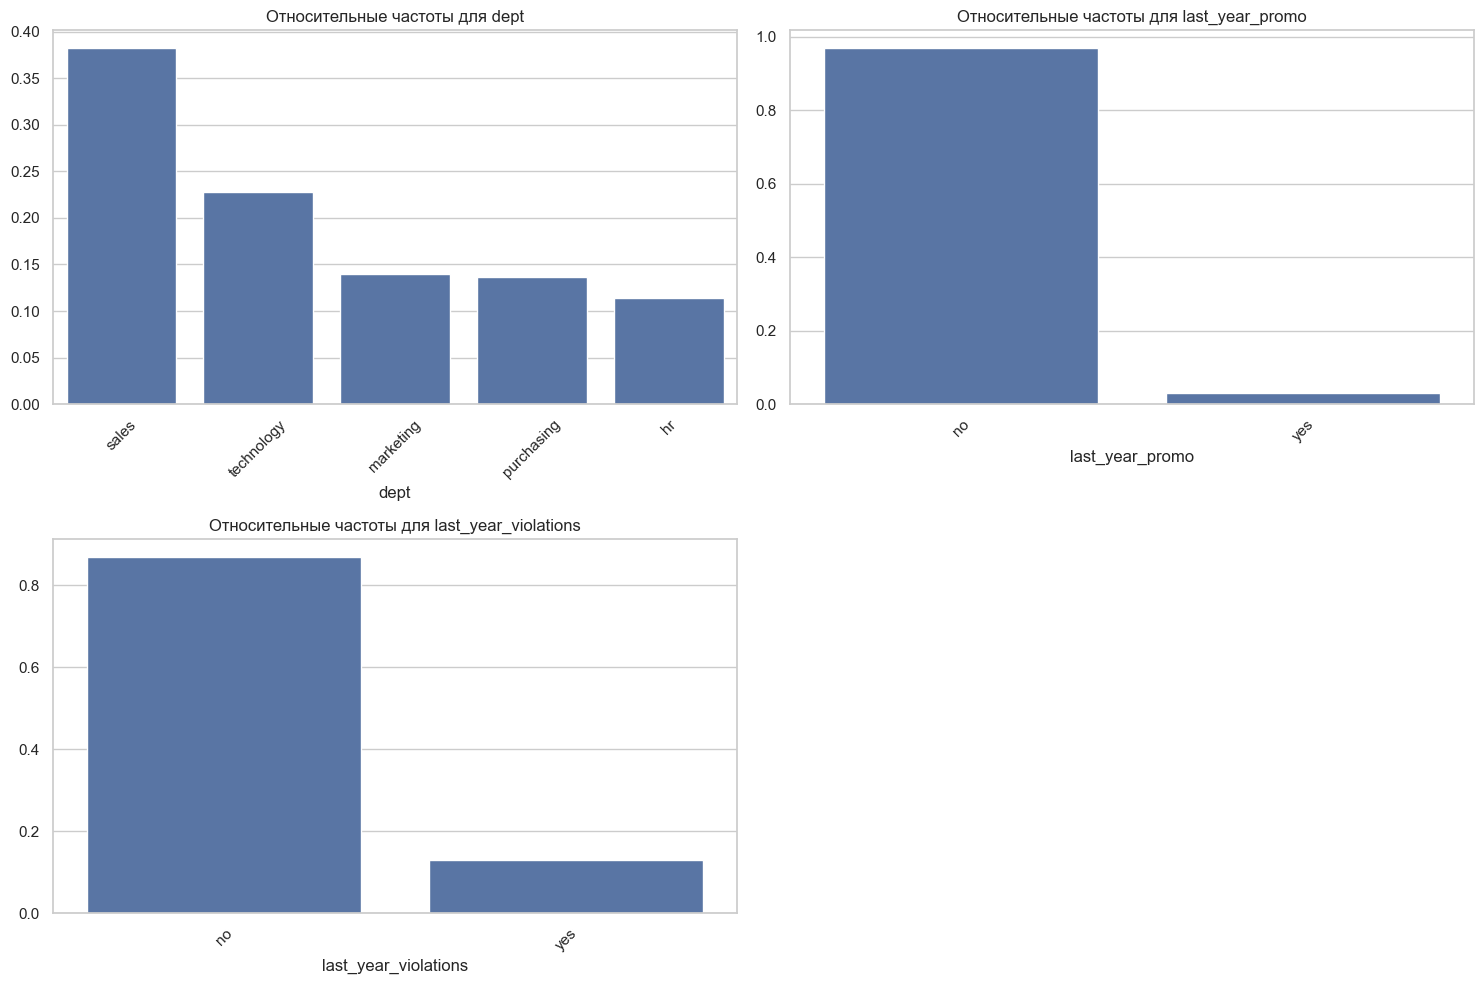

In [290]:
# Категориальные признаки data_test в относительных показателях
categorical_cols = ['dept', 'last_year_promo', 'last_year_violations']

# Анализ и визуализация
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    # Получаем относительные частоты
    relative_freq = data_test[col].value_counts(normalize=True)
    # Визуализируем
    sns.barplot(x=relative_freq.index, y=relative_freq.values)
    plt.title(f'Относительные частоты для {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

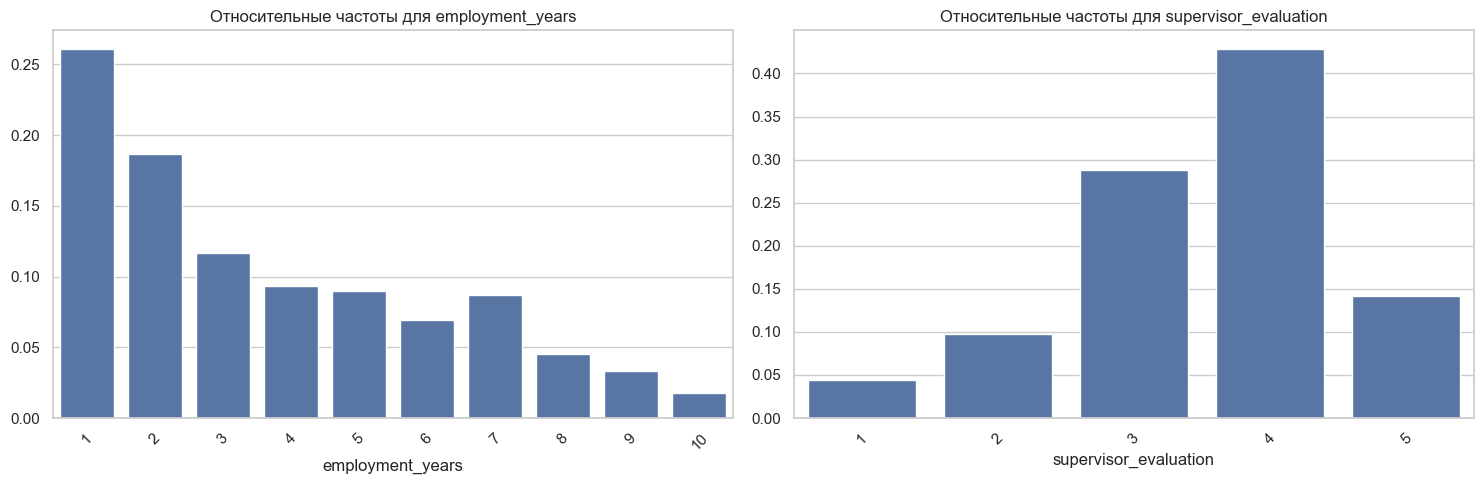

In [291]:
# Дискретные признаки data_test в относительных показателях
discrete_cols = ['employment_years', 'supervisor_evaluation']

# Анализ и визуализация
plt.figure(figsize=(15, 5))
for i, col in enumerate(discrete_cols, 1):
    plt.subplot(1, 2, i)
    # Получаем относительные частоты
    relative_freq = data_test[col].value_counts(normalize=True)
    # Визуализируем
    sns.barplot(x=relative_freq.index, y=relative_freq.values)
    plt.title(f'Относительные частоты для {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Распределение данных сопоставимо в data_test и data_train.

# Объединение тестовых данных data_test и data_target в data_merged

In [292]:
# Объединяем тестовые данные data_test и data_target по столбцу 'id'
data_merged = pd.merge(data_test, data_target, on='id')

# Вывод объединенного DataFrame
display(data_merged)

id        dept   level workload  employment_years last_year_promo  \
0     485046   marketing  junior   medium                 2              no   
1     686555          hr  junior   medium                 1              no   
2     467458       sales  middle      low                 5              no   
3     418655       sales  middle      low                 6              no   
4     789145          hr  middle   medium                 5              no   
...      ...         ...     ...      ...               ...             ...   
1995  393147   marketing  junior      low                 3              no   
1996  109582  technology  middle      low                 3              no   
1997  305653  technology  junior      low                 1              no   
1998  160233  technology  middle      low                 8              no   
1999  771859  purchasing  middle   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  \
0                      no                      5   28800   
1                      no                      4   30000   
2                      no                      4   19200   
3                      no                      4   19200   
4                      no                      5   40800   
...                   ...                    ...     ...   
1995                   no                      3   20400   
1996                   no                      2   21600   
1997                   no                      3   14400   
1998                   no                      1   32400   
1999                   no                      4   38400   

      job_satisfaction_rate  
0                      0.79  
1                      0.72  
2                      0.64  
3                      0.60  
4                      0.75  
...                     ...  
1995                   0.56  
1996                   0.14  
1997                   0.11  
1998                   0.43  
1999                   0.67  

[2000 rows x 10 columns]

In [293]:
print(data_merged.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


In [294]:
# Проверяем наличие дубликатов
duplicates = data_merged.duplicated()

# Выводим количество дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в данных: {num_duplicates}")

# Выводим дубликаты
if num_duplicates > 0:
    print("Дубликаты:")
    display(data_merged[duplicates])

Количество дубликатов в данных: 0


In [295]:
display(data_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


None

In [296]:
# Получаем уникальные значения для категориальных признаков data_merged
for col in data_merged.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(data_merged[col].unique())
    display()

Уникальные значения для столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения для столбца level:
['junior' 'middle' 'senior' nan]
Уникальные значения для столбца workload:
['medium' 'low' 'high' nan]
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']


In [297]:
display(data_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


None

# Распределение удовлетворенности работой по отделам и уровням в тестовой группе

In [298]:
# Создаем сводную таблицу для распределения удовлетворенности работой по отделам и уровням
pivot_table = pd.pivot_table(
    data_merged,
    values='job_satisfaction_rate',  # Столбец с удовлетворенностью
    index='dept',                     # Индекс - отдел
    columns='level',                  # Столбцы - уровни
    aggfunc='mean',                   # Функция агрегации - среднее значение
    fill_value=0                      # Заменяем NaN на 0
)

# Выводим сводную таблицу
print("Сводная таблица по удовлетворенности работой в тестовой группе:")
display(pivot_table)

Сводная таблица по удовлетворенности работой в тестовой группе:


level         junior    middle    senior
dept                                    
hr          0.528974  0.561538  0.588421
marketing   0.570310  0.540229  0.611579
purchasing  0.550373  0.539664  0.629500
sales       0.534053  0.571389  0.617302
technology  0.507834  0.535000  0.605200

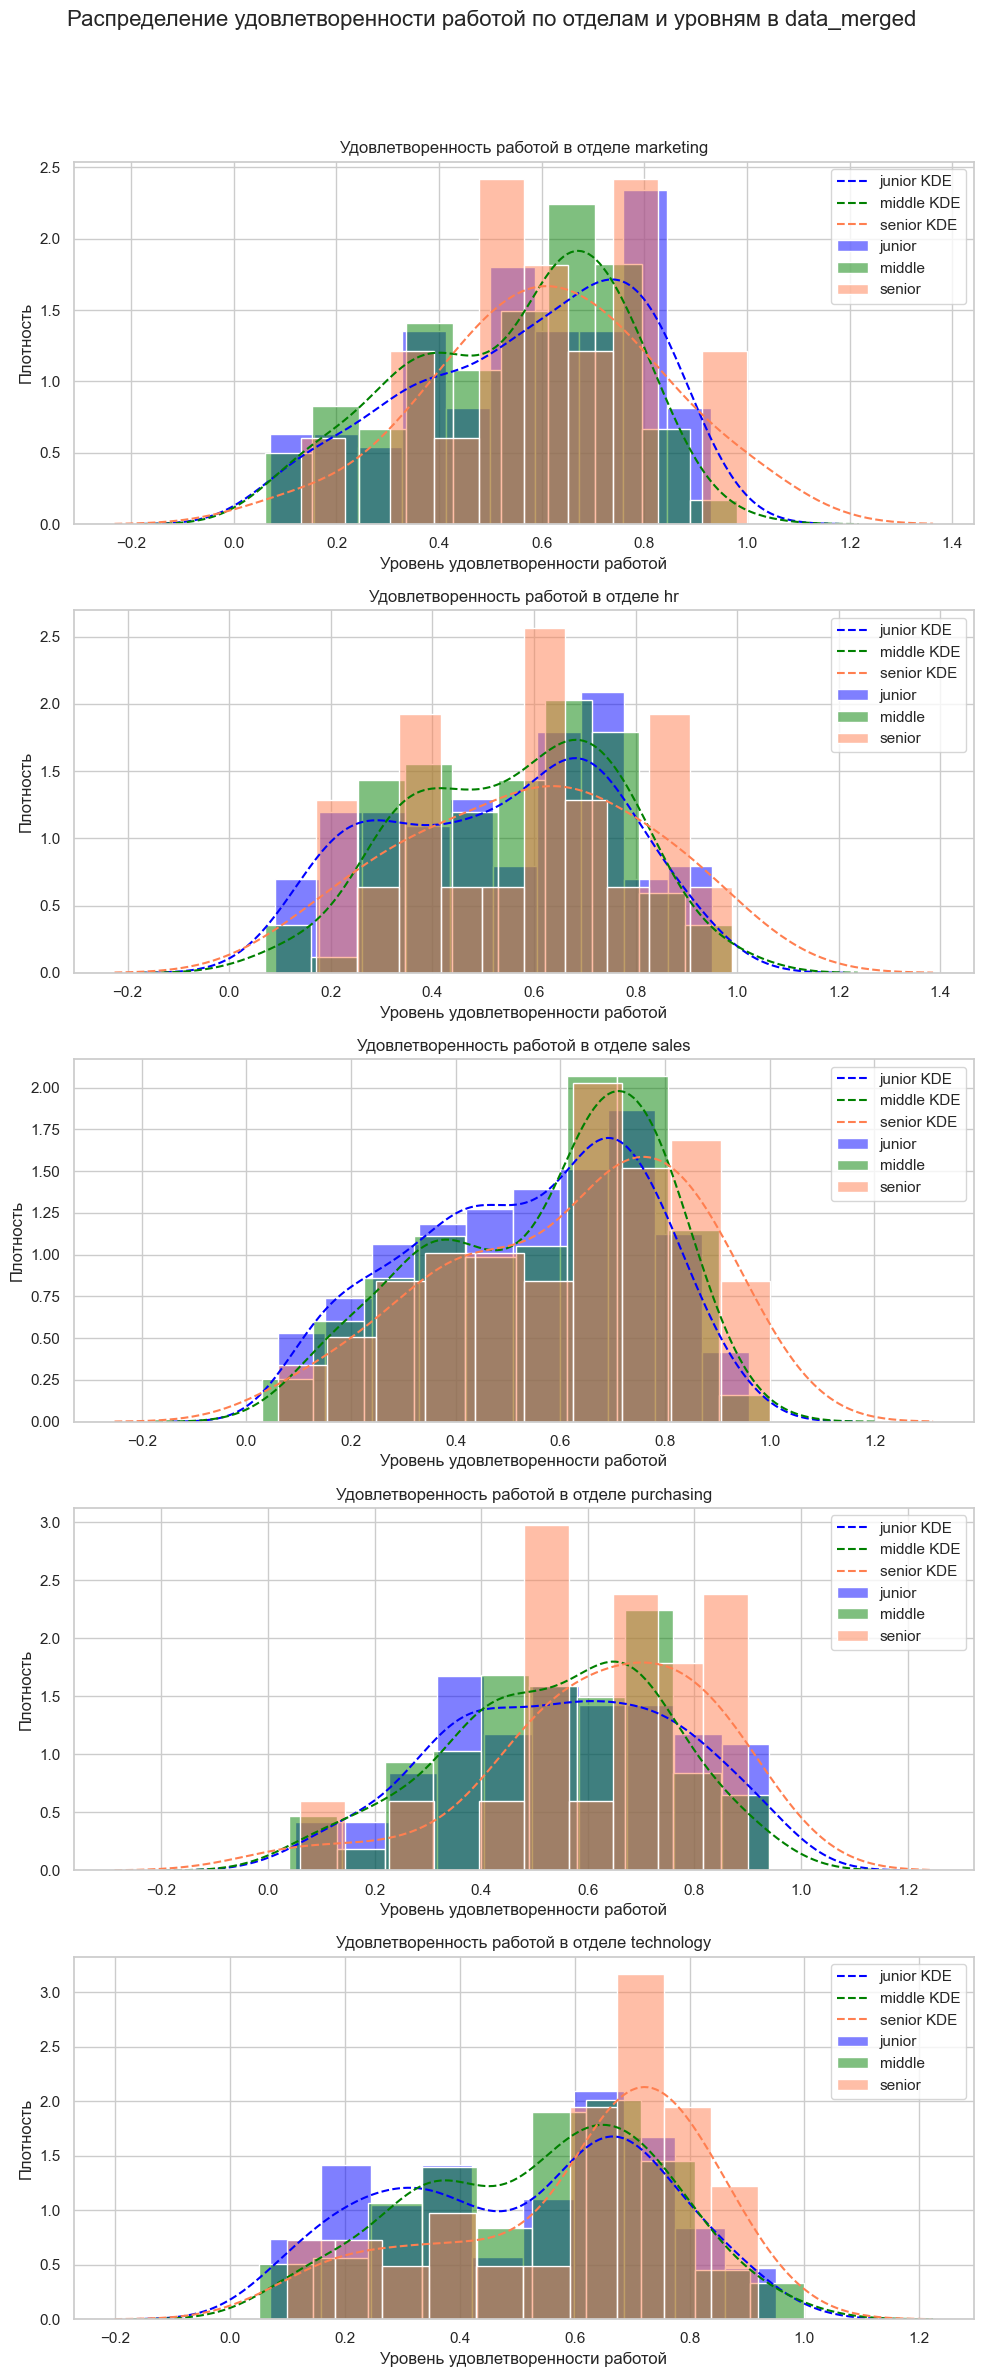

In [299]:
# Цвета для уровней
level_colors = {'junior': 'blue', 'middle': 'green', 'senior': 'coral'}  

# Уникальные отделы, исключая NaN
departments = data_merged['dept'].dropna().unique()

# Создаем фигуру с подграфиками
fig, axes = plt.subplots(nrows=len(departments), ncols=1, figsize=(10, 5 * len(departments)))

# Проходим по каждому отделу и создаем нормированные гистограммы
for ax, dept in zip(axes, departments):
    # Группируем данные по уровням для текущего отдела
    for level in data_merged['level'].unique():
        if pd.isna(level):  # Пропускаем NaN значения
            continue
        group = data_merged[(data_merged['dept'] == dept) & (data_merged['level'] == level)]
        
        # Используем нормированную гистограмму
        sns.histplot(group['job_satisfaction_rate'].dropna(), 
                     bins=10, 
                     stat='density', 
                     common_norm=False,
                     alpha=0.5, 
                     label=level, 
                     color=level_colors[level], 
                     ax=ax)
        
        # Также можно добавить график плотности
        sns.kdeplot(group['job_satisfaction_rate'].dropna(), 
                    color=level_colors[level], 
                    ax=ax, 
                    label=f'{level} KDE', 
                    linestyle='--')

    # Настраиваем оси и заголовок для каждого отдела
    ax.set_title(f'Удовлетворенность работой в отделе {dept}')
    ax.set_xlabel('Уровень удовлетворенности работой')
    ax.set_ylabel('Плотность')
    ax.legend()

# Настраиваем общий заголовок для всей фигуры
plt.suptitle('Распределение удовлетворенности работой по отделам и уровням в data_merged', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Убираем перекрытие заголовка

# Отображаем гистограммы
plt.show()

Уровень удовлетворенности в тестовой группе также варьируется в зависимости от отдела и уровня должности, как и в data_train. В целом, удовлетворенность работой у сотрудников senior уровня выше, чем у junior и middle, что может указывать на то, что более опытные сотрудники имеют более позитивный опыт работы.

Отдел HR:

   • Удовлетворенность работой на уровне junior (0.529) является самой низкой среди всех уровней, но постепенно увеличивается на уровнях middle (0.562) и senior (0.588). HR-отделу стоит обратить внимание на условия работы и возможности для роста для младших специалистов - обратная зависимость в отличие от data_train.

Отдел Marketing:

   • В маркетинговом отделе наблюдается высокая удовлетворенность на уровне junior (0.570), но уровень middle (0.540) ниже, чем у junior, и только senior (0.612) показывает высокий уровень удовлетворенности - средние специалисты сталкиваются с определенными трудностями или недостатком поддержки. Также обратная зависимость по сравнению с data_train.

Отдел Purchasing:

   • В purchasing уровне junior (0.550) и middle (0.540) показывают схожие результаты, но senior уровень (0.630) значительно выше, значит с ростом в должности сотрудники получают больше возможностей для удовлетворения своих профессиональных потребностей. В data_train показатели немного ниже, но более сбаллансированы и нет перекоса в какую-либо сторону, отдел демонстрирует позитивную рабочую атмосферу.

Отдел Sales:

   • В sales отделе наблюдается стабильный рост удовлетворенности от junior (0.534) до senior (0.617) - отдел предоставляет хорошие условия для роста и развития сотрудников. В data_train имеется характерный дисбалланс в отношении senior сотрудников, которые существенно ущемлены в этом отношении и являются самой неудовлетворенной группой среди всех отделов.

Отдел Technology:

   • В technology отделе уровень удовлетворенности самый низкий среди junior (0.508) и middle (0.535), но senior уровень (0.605) все же показывает более положительные результаты. Это может указывать на необходимость улучшения условий работы для младших и средних специалистов, чтобы повысить их удовлетворенность. В data_train также показатели немного ниже, но более сбаллансированы и нет перекоса в какую-либо сторону.
   
В целом выборки несколько отличаются по динамике показателей.

# Матрица корреляций job_satisfaction_rate по методу phik в объединенной тестовой выборке data_merged

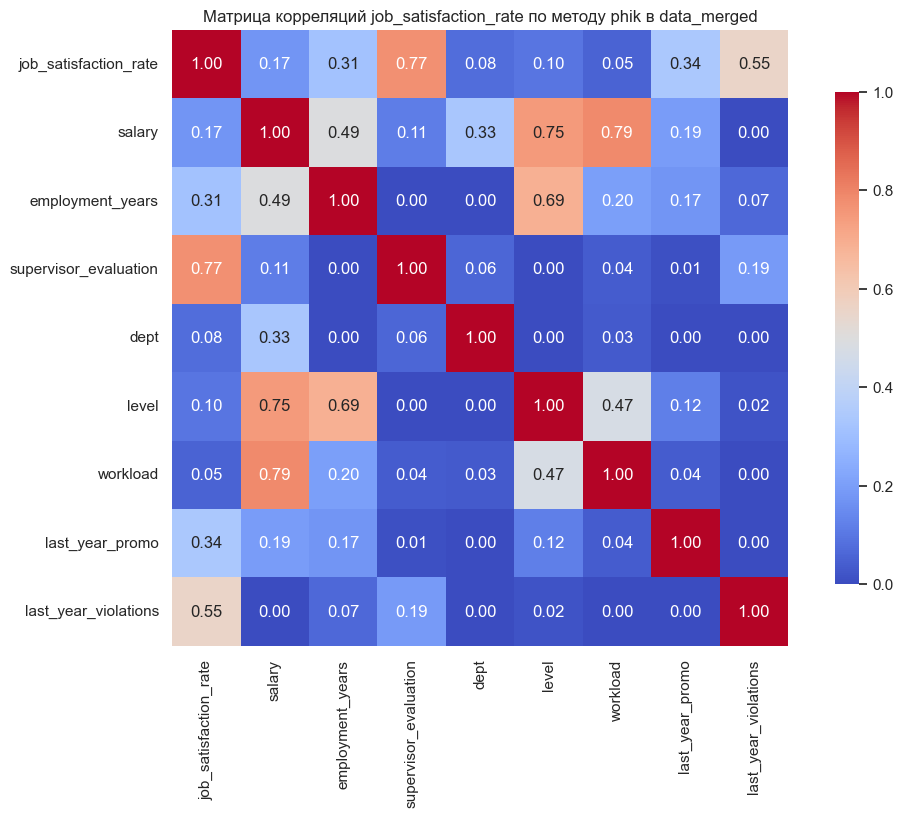

In [300]:
# Определяем колонки, которые будем использовать
# Интервальные (не коррелирующие: employment_years и supervisor_evaluation)
interval_cols = ['job_satisfaction_rate', 'salary']  # Непрерывные признаки
discrete_cols = ['employment_years', 'supervisor_evaluation']  # Дискретные

# Создаем список всех признаков - union интервальных и дискретных
all_columns = data_merged.columns.tolist()

# Убираем из всех столбцов интервальные, дискретные и id, чтобы получить категориальные
categorical_cols = [col for col in all_columns if col not in interval_cols + discrete_cols + ['id']]

# Выводим матрицу корреляций с использованием метода phik
# Указываем interval_cols для корректного расчета корреляций
correlation_matrix = data_merged[interval_cols + discrete_cols + categorical_cols].phik_matrix(interval_cols=interval_cols)

# Рисуем тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций job_satisfaction_rate по методу phik в data_merged')
plt.show()

В целом данные сопоставимы с data_train

In [301]:
display(data_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


None

In [302]:
print(data_merged.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


In [303]:
# Проверяем наличие дубликатов
duplicates = data_merged.duplicated()

# Выводим количество дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в данных: {num_duplicates}")

# Выводим дубликаты
if num_duplicates > 0:
    print("Дубликаты:")
    display(data_merged[duplicates])

Количество дубликатов в данных: 0


In [304]:
# Проверим наличие строк с некорректным значением в data_train
idx = data_merged[data_merged['job_satisfaction_rate'] == 'sales'].index

# Выведем эти строки на экран
print(data_merged.loc[idx])

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, job_satisfaction_rate]
Index: []


In [305]:
print(data_merged['job_satisfaction_rate'].dtype)

float64


In [306]:
print(data_merged['job_satisfaction_rate'].isna().sum())

0


# Шаг 4. Подготовка данных

Подготовку признаков выполните в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика

In [307]:
display(data_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   float64
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 312.5+ KB


None

In [308]:
print(data_train.columns.tolist())

['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


In [309]:
# Проверяем наличие дубликатов
duplicates = data_train.duplicated()

# Выводим количество дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в данных после удаления 'id': {num_duplicates}")

# Выводим дубликаты
if num_duplicates > 0:
    print("Дубликаты:")
    display(data_train[duplicates])

Количество дубликатов в данных после удаления 'id': 245
Дубликаты:


dept   level workload  employment_years last_year_promo  \
id                                                                      
302957  purchasing  junior      low                 1              no   
752399       sales  middle      low                 7              no   
802286       sales  junior   medium                 1              no   
167303       sales  junior   medium                 1              no   
191841       sales  junior   medium                 1              no   
...            ...     ...      ...               ...             ...   
737303       sales  middle   medium                 3              no   
281204  technology  junior      low                 2              no   
261436       sales  middle      low                 3              no   
457950  technology  junior     high                 2              no   
957499       sales  junior   medium                 2              no   

       last_year_violations  supervisor_evaluation   salary  \
id                                                            
302957                   no                      4  15600.0   
752399                   no                      4  28800.0   
802286                   no                      4  21600.0   
167303                   no                      3  24000.0   
191841                   no                      5  21600.0   
...                     ...                    ...      ...   
737303                   no                      4  33600.0   
281204                   no                      4  15600.0   
261436                   no                      3  22800.0   
457950                   no                      3  46800.0   
957499                   no                      4  21600.0   

        job_satisfaction_rate  
id                             
302957                   0.61  
752399                   0.77  
802286                   0.43  
167303                   0.34  
191841                   0.44  
...                       ...  
737303                   0.47  
281204                   0.68  
261436                   0.18  
457950                   0.45  
957499                   0.68  

[245 rows x 9 columns]

In [310]:
# Удаляем дубликаты
data_train.drop_duplicates(inplace=True)

# Проверяем количество дубликатов после удаления
num_duplicates_after = data_train.duplicated().sum()
print(f"Количество дубликатов после удаления: {num_duplicates_after}")

Количество дубликатов после удаления: 0


In [311]:
# Проверим наличие строк с некорректным значением в data_train
idx = data_train[data_train['job_satisfaction_rate'] == 'sales'].index

# Выведем эти строки на экран
print(data_train.loc[idx])

Empty DataFrame
Columns: [dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, job_satisfaction_rate]
Index: []


In [312]:
print(data_train['job_satisfaction_rate'].dtype)

float64


In [313]:
print(data_train['job_satisfaction_rate'].isna().sum())

0


In [314]:
display(data_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3755 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   float64
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 422.4+ KB


None

3755 наблюдений в обучающей выборке можно считать ограниченным набором данных, учитывая количество признаков и сложность задачи (предсказание удовлетворенности работой), необходимо использовать валидационную выборку, которая поможет оценить производительность модели на невиданных ранее данных и предотвратить переобучение. Валидационная выборка предоставит дополнительный набор данных для оценки производительности модели, поможет настроить гиперпараметры модели и выбрать модель, которая лучше всего подходит для данных. Можно выделить небольшую часть (20%) в качестве валидационной выборки, оставив 80% для обучающей выборки. Это обеспечит достаточное количество данных для обучения и оценки производительности модели.

Предоставлены данные: обучающий набор (`data_train`), тестовый набор (`data_merged`) Используем:
- `data_train` для обучения моделей,
- `data_merged` для оценки качества моделей.

In [315]:
# Определим числовые, порядковые и категориальные колонки
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']  # Категориальные признаки
ord_columns = ['level', 'workload']  # Порядковые признаки
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']  # Числовые признаки

# Создание пайплайна для предобработки признаков с учетом обработки пропусков
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков модой
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Игнорируем неизвестные категории
        ]), ohe_columns),
        ('ord', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков модой
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Кодируем неизвестные значения
        ]), ord_columns),
        ('scale', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средним
            ('scaler', StandardScaler())
        ]), num_columns)
    ]
)

In [316]:
# Создание пайплайнов для линейной регрессии и дерева решений
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=123))  # Установка random_state для воспроизводимости
])

Проведена подготовка признаков в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учтены особенности признаков: числовые (StandardScaler), порядковые (OrdinalEncoder), категориальные (OneHotEncoder) и моделей LinearRegression и DecisionTreeRegressor, использовано три кодировщика.

# Шаг 5. Обучение моделей

Обучите как минимум две модели. Возьмите одну линейную модель, а в качестве второй — дерево решений. 
Подберите гиперпараметры как минимум для одной модели с помощью одного из известных вам инструментов.
Выберите лучшую модель и проверьте её качество. Выбор делайте на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 
Метрика SMAPE вычисляется так:
SMAPE=100n∑i=1n∣yi−yi^∣(∣yi∣+∣y^i∣)/2,SMAPE=n100∑i=1n(∣yi∣+∣y^i∣)/2∣yi−yi^∣,
где:
•	yiyi — фактическое значение целевого признака для объекта с порядковым номером ii в выборке;
•	yi^yi^ — предсказанное значение целевого признака для объекта с порядковым номером ii в выборке;
•	nn — количество объектов в выборке;
•	∑i=1n∑i=1n — сумма значений, полученная в результате операций, которые следуют за этим знаком, для всех объектов с порядковым номером от ii до nn в выборке.
Напишите функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE. Используйте эту метрику при подборе гиперпараметров и оценке качества моделей. 
Критерий успеха: SMAPE ≤15≤15 на тестовой выборке.
В решении сохраните работу со всеми моделями, которые вы пробовали. Сделайте выводы

Обучение 2 моделей LinearRegression, DecisionTreeRegressor.

In [317]:
# Определяем целевую переменную и признаки
X = data_train.drop(columns=['job_satisfaction_rate'])  # Признаки
y = data_train['job_satisfaction_rate']  # Целевая переменная

# Создадим пайплайн для линейной регрессии
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Создадим пайплайн для дерева решений
tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

In [318]:
# Функция для расчета sMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator = np.clip(denominator, 1e-10, None)  # Избегаем деления на ноль
    return 100 * np.mean(np.abs(y_true - y_pred) / denominator)

# Создаем scorer для кросс-валидации
smape_scorer = make_scorer(smape, greater_is_better=False)

# Кросс-валидация для линейной регрессии с использованием sMAPE
lin_reg_cv_scores = cross_val_score(linear_model, X, y, cv=5, scoring=smape_scorer)
lin_reg_cv_smape = -lin_reg_cv_scores.mean()  # Инвертируем, так как greater_is_better=False

# Кросс-валидация для дерева решений с использованием sMAPE
tree_reg_cv_scores = cross_val_score(tree_model, X, y, cv=5, scoring=smape_scorer)
tree_reg_cv_smape = -tree_reg_cv_scores.mean()  # Инвертируем, так как greater_is_better=False

# Вывод результатов кросс-валидации
print("Linear Regression sMAPE (Cross-Validation): ", lin_reg_cv_smape)
print("Decision Tree sMAPE (Cross-Validation): ", tree_reg_cv_smape)

Linear Regression sMAPE (Cross-Validation):  26.982802747673354
Decision Tree sMAPE (Cross-Validation):  15.97975506209933


Decision Tree показала значительно лучшее качество предсказаний по сравнению с Linear Regression - sMAPE на 11 пунктов ниже, значит она лучше справляется с задачей предсказания целевой переменной. sMAPE Decision Tree = 15.98 - средняя ошибка предсказаний составляет около 16% от фактических значений. Критерий успеха: sMAPE ≤ 15, Decision Tree близок к этому критерию, но не достигает его. Необходимо провести подбор гиперпараметров для Decision Tree.

In [319]:
# Подбор гиперпараметров для дерева решений
param_grid = {
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 5],
    'regressor__min_samples_split': [2, 5, 10]
}

# Настройка GridSearchCV
grid_search_tree = GridSearchCV(tree_model, param_grid, scoring=smape_scorer, cv=5)

# Обучение модели с помощью GridSearchCV
grid_search_tree.fit(X, y)

# Лучшая модель
best_tree_model = grid_search_tree.best_estimator_

# Вывод лучших параметров и результата кросс-валидации
print("Лучшие параметры для дерева решений:", grid_search_tree.best_params_)
print("Лучший результат кросс-валидации (sMAPE):", abs(grid_search_tree.best_score_))

Лучшие параметры для дерева решений: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}
Лучший результат кросс-валидации (sMAPE): 15.367592162455741


Лучшие гиперпараметры:
max_depth: None (дерево может расти до тех пор, пока не разделит все данные или не достигнет других ограничений).
min_samples_leaf: 1 (каждый лист должен содержать минимум 1 ответвление).
min_samples_split: 5 (для разделения узла требуется минимум 5 ответвлений).

Модель склонна к созданию достаточно глубокого дерева с минимальными ограничениями на размер листьев и узлов, что может привести к хорошему качеству на обучающих данных, но также увеличивает риск переобучения.

Проверяем качество модели после получения лучших параметров, обучаем модель с этими параметрами на всей тренировочной выборке и оцениваем ее качество на тестовой выборке с использованием метрики sMAPE.

In [320]:
# Выбор лучшей модели на основе кросс-валидации
if lin_reg_cv_smape < abs(grid_search_tree.best_score_):
    best_model = linear_model
    print("Лучшая модель: Linear Regression")
else:
    best_model = best_tree_model
    print("Лучшая модель: Decision Tree")

# Оценка лучшей модели на тестовой выборке
X_test = data_merged.drop(columns=['id', 'job_satisfaction_rate'])  # Убираем 'id' и целевую переменную
y_test = data_merged['job_satisfaction_rate']  # Целевая переменная для теста

# Предсказание на тестовой выборке
y_test_pred = best_model.predict(X_test)

# Расчет sMAPE для тестовой выборки
sMAPE_test = smape(y_test, y_test_pred)

print("sMAPE на тестовой выборке для лучшей модели:", sMAPE_test)

Лучшая модель: Decision Tree
sMAPE на тестовой выборке для лучшей модели: 14.18307934720806


Дерево решений: sMAPE на тренировочной выборке: 15.36, sMAPE на тестовой выборке: 14.18. Модель показывает хорошее качество предсказаний и обобщается на тестовых данных.

In [321]:
# Создаем константную модель для предсказания среднего значения целевой переменной
dummy_model = DummyRegressor(strategy="mean")

# Кросс-валидация для константной модели с использованием sMAPE
dummy_cv_scores = cross_val_score(dummy_model, X, y, cv=5, scoring=smape_scorer)
dummy_cv_smape = -dummy_cv_scores.mean()  # Инвертируем, так как greater_is_better=False

# Вывод результата кросс-валидации
print("Константная модель sMAPE (Cross-Validation): ", dummy_cv_smape)

Константная модель sMAPE (Cross-Validation):  40.19026456683123


Константная модель показывает качество хуже, чем LinearRegression и DecisionTreeRegressor, значает, что усилия по созданию признаков, настройке гиперпараметров и обучению моделей были оправданы.

# Шаг 6. Оформление выводов

Промежуточные выводы о том, какая модель справилась лучше и почему.

Модель дерева решений является более подходящей моделью для данных, показывает лучшую производительность, может быть использовано в дальнейшем анализе или для построения прогноза, так как оно более точно отражает зависимость между переменными.

# Задача 2: Предсказание увольнения сотрудника из компании

Для этой задачи можно использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

# Шаг 1. Загрузка данных

In [322]:
# Тренировочная выборка
train_quit = pd.read_csv(r'C:\GitProjects\supervised_learning_project\data\task2\train2\train_quit.csv')

# Выводим первые 5 строк данных
display(train_quit.head())

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

In [323]:
print(train_quit.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


Тренировочная выборка train_quit состоит из 4000 записей с 10 признаками, содержит пропущенные значения в столбцах dept - 6 и level - 4, их можно обработать с помощью методов заполнения, таких как среднее или мода. Все признаки являются категориальными или числовыми.
Анализ категориальных признаков: dept имеет 5 уникальных значения, level - 3, workload - 3, last_year_promo и last_year_violations - по 2 уникальных значения.
Анализ числовых признаков: employment_years варьируется от 1 до 10 лет, supervisor_evaluation - от 1 до 5, salary - от 10000 до 100000, quit - 2 уникальных значения.
Набор данных хорошо структурирован и содержит минимальное количество пропущенных значений. Категориальные признаки имеют ограниченное количество уникальных значений, что упрощает их обработку. Числовые признаки имеют разумные диапазоны и распределения. Нет явных проблем с корреляцией между признаками. В целом, набор данных находится в хорошем состоянии и готов к дальнейшему анализу.

In [324]:
# Тестовая выборка
test_features = pd.read_csv(r'C:\GitProjects\supervised_learning_project\data\task2\test2\test_features.csv')

# Выводим первые 5 строк данных
display(test_features.head())

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [325]:
print(test_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


Тестовая выборка test_features состоит из 2000 записей с 9 признаками, содержит пропущенные значения в столбцах dept - 2 и level - 1, их можно обработать с помощью методов заполнения, таких как среднее или мода. Все признаки являются категориальными или числовыми.
Анализ категориальных признаков: dept имеет 5 уникальных значения, level - 3, workload - 3, last_year_promo и last_year_violations - по 2 уникальных значения.
Анализ числовых признаков: employment_years варьируется от 1 до 10 лет, supervisor_evaluation - от 1 до 5, salary - от 10000 до 100000.
Набор данных хорошо структурирован и содержит минимальное количество пропущенных значений. Категориальные признаки имеют ограниченное количество уникальных значений, что упрощает их обработку. Числовые признаки имеют разумные диапазоны и распределения. Нет явных проблем с корреляцией между признаками. В целом, набор данных находится в хорошем состоянии и готов к дальнейшему анализу.

In [326]:
# Целевой признак тестовой выборки
test_target_quit = pd.read_csv(r'C:\GitProjects\supervised_learning_project\data\task2\test2\test_target_quit.csv')

# Выводим первые 5 строк данных
display(test_target_quit.head())

id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

In [327]:
print(test_target_quit.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


Целевой признак тестовой выборки data_target состоит из 2000 записей с 2 признаками, не содержит пропущенных значений.

# Шаг 2. Предобработка данных

Изучите данные и при необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [328]:
# Проверяем наличие дубликатов в train_quit
train_quit.duplicated().sum()

np.int64(0)

In [329]:
# Проверяем наличие дубликатов в test_features
test_features.duplicated().sum()

np.int64(0)

In [330]:
# Проверяем наличие дубликатов в test_target_quit
test_target_quit.duplicated().sum()

np.int64(0)

In [331]:
# Проверка на наличие пропусков в train_quit
missing_values = train_quit.isnull().sum()
display("Пропуски в данных:\n", missing_values)

'Пропуски в данных:\n'

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [332]:
# Заменяем 'sinior' на 'senior' в столбце 'level'
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

# Проверяем изменения
print(train_quit['level'].value_counts())

level
junior    1949
middle    1694
senior     357
Name: count, dtype: int64


In [333]:
# Проверка на наличие пропусков в test_features
missing_values = test_features.isnull().sum()
display("Пропуски в данных:\n", missing_values)

'Пропуски в данных:\n'

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [334]:
# Проверка на наличие пропусков в test_target_quit
missing_values = test_target_quit.isnull().sum()
display("Пропуски в данных:\n", missing_values)

'Пропуски в данных:\n'

id      0
quit    0
dtype: int64

In [335]:
# Заменяем 'sinior' на 'senior' в столбце 'level' в test_target_quit
test_features['level'] = test_features['level'].replace('sinior', 'senior')

# Проверяем изменения
print(test_features['level'].value_counts())

# Заменяем пробелы на np.nan для всех категориальных признаков
for col in test_features.select_dtypes(include=['object']).columns:
    test_features[col] = test_features[col].replace(' ', np.nan)

# Проверяем уникальные значения после замены
for col in test_features.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(test_features[col].unique())

level
junior    974
middle    854
senior    171
Name: count, dtype: int64
Уникальные значения для столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения для столбца level:
['junior' 'middle' 'senior' nan]
Уникальные значения для столбца workload:
['medium' 'low' 'high' nan]
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']


In [336]:
# Получаем уникальные значения для категориальных признаков train_quit
for col in train_quit.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(train_quit[col].unique())
    display()

Уникальные значения для столбца dept:
['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения для столбца level:
['middle' 'junior' 'senior']
Уникальные значения для столбца workload:
['high' 'medium' 'low']
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']
Уникальные значения для столбца quit:
['no' 'yes']


In [337]:
# Получаем уникальные значения для категориальных признаков test_features
for col in test_features.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(test_features[col].unique())
    display()

Уникальные значения для столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения для столбца level:
['junior' 'middle' 'senior' nan]
Уникальные значения для столбца workload:
['medium' 'low' 'high' nan]
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']


# Проведена проверка на пропуски и дубликаты
Пропуски в train_quit: dept - 6, level - 4, в test_features: dept - 2, level - 1 и дубликатов нет. В уникальных значениях для категориальных признаков train_quit dept - nan, level - nan, в test_features: dept - ' ', level - nan, workload - ' '. Выполнена предобработка.

# Шаг 3. Исследовательский анализ данных

3.1. Проведите исследовательский анализ данных.
3.2. Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.
3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

# Исследовательский анализ данных

In [338]:
# Отбор уволенных сотрудников
terminated_employees = train_quit[train_quit['quit'] == 'yes']

# Проведение описательной статистики
description = terminated_employees.describe(include='all')

# Вывод результата
display(description)

id   dept   level workload  employment_years  \
count     1128.000000   1128    1128     1128       1128.000000   
unique            NaN      5       3        3               NaN   
top               NaN  sales  junior      low               NaN   
freq              NaN    407    1003      519               NaN   
mean    544544.457447    NaN     NaN      NaN          1.844858   
std     258059.498361    NaN     NaN      NaN          1.274920   
min     100222.000000    NaN     NaN      NaN          1.000000   
25%     325073.000000    NaN     NaN      NaN          1.000000   
50%     545003.500000    NaN     NaN      NaN          1.000000   
75%     756296.000000    NaN     NaN      NaN          2.000000   
max     999158.000000    NaN     NaN      NaN         10.000000   

       last_year_promo last_year_violations  supervisor_evaluation  \
count             1128                 1128            1128.000000   
unique               2                    2                    NaN   
top                 no                   no                    NaN   
freq              1127                  900                    NaN   
mean               NaN                  NaN               3.046099   
std                NaN                  NaN               0.973291   
min                NaN                  NaN               1.000000   
25%                NaN                  NaN               3.000000   
50%                NaN                  NaN               3.000000   
75%                NaN                  NaN               4.000000   
max                NaN                  NaN               5.000000   

              salary  quit  
count    1128.000000  1128  
unique           NaN     1  
top              NaN   yes  
freq             NaN  1128  
mean    23885.106383   NaN  
std      9351.599505   NaN  
min     12000.000000   NaN  
25%     16800.000000   NaN  
50%     22800.000000   NaN  
75%     27600.000000   NaN  
max     79200.000000   NaN

В выборке 1128 уволившихся сотрудников. Сотрудники распределены по 5 различным отделам, при этом наибольшее количество (407) относится к отделу продаж. Это может указывать на высокую текучесть кадров в данном отделе или на особенности его работы.

Представлены три уровня должностей, среди которых наибольшее количество (1003) составляет уровень "junior". Это может свидетельствовать о том, что младшие сотрудники чаще всего увольняются, возможно, из-за недостатка карьерного роста или неудовлетворенности условиями труда.

Представлены три категории нагрузки, среди которых преобладает "low" (519 случаев) - сотрудники с низкой нагрузкой чаще увольняются, возможно, из-за недостатка вызовов или интересных задач.

Среднее количество лет работы уволившихся сотрудников составляет примерно 1.84 года - относительно небольшой срок, что может говорить о высокой текучести кадров среди новых сотрудников. Минимальный стаж составляет 1 год, а максимальный — 10 лет, что также подтверждает наличие как новых, так и более опытных сотрудников в выборке.

1127 не получили продвижение в прошлом году, что может быть связано с недостатком карьерных возможностей или низкой мотивацией.

900 уволившихся сотрудников не имели нарушений в прошлом году - большинство уволившихся сотрудников соблюдали правила и нормы компании, что может быть положительным показателем в отношении их профессиональной дисциплины.

Средняя оценка от руководства составляет примерно 3.05 из 5, с стандартным отклонением 0.97 - в целом сотрудники получили среднюю оценку, значит они выполняли свои обязанности на удовлетворительном уровне, но было пространство для улучшения. Минимальная оценка составляет 1, а максимальная — 5, были как низкооцененные сотрудники, так и высокоэффективные работники в выборке.

25% сотрудников получили оценку 3 или ниже - часть уволившихся сотрудников не соответствовала ожиданиям руководства.
Половина уволившихся (50%) получила оценку 3, что подчеркивает средний уровень производительности. 75% сотрудников получили оценку 4 или ниже, значит лишь небольшая часть сотрудников (25%) была высоко оценена.

Средняя зарплата уволившихся сотрудников составляет 23885.11, что может служить ориентиром для оценки уровня заработной платы в компании и сравнения с рыночными стандартами. Стандартное отклонение составляет 9351.60, существует значительная вариативность зарплат среди уволившихся сотрудников. Минимальная зарплата составляет 12000, а максимальная — 79200, что говорит о широком диапазоне зарплат в компании и может быть связано с различиями в должностях, опыте и квалификации сотрудников. 25% сотрудников зарабатывали 16800 или меньше. Половина (50%) сотрудников имела зарплату 22800 или ниже. 75% сотрудников зарабатывали 27600 или меньше, что говорит о том, что только четверть сотрудников получала зарплату выше этого уровня.

Необходимо провести более глубокий анализ причин увольнения, особенно среди сотрудников с низкими оценками. Возможно, стоит рассмотреть возможность улучшения условий труда и карьерного роста для этих сотрудников, разработать программы повышения квалификации и развития для сотрудников, чтобы повысить их производительность и удовлетворенность работой.
Необходимо провести анализ структуры зарплат в компании, чтобы понять, как она соотносится с рыночными стандартами и конкурентами. Рассмотреть возможность пересмотра компенсационного пакета для удержания талантливых сотрудников, особенно тех, кто находится на верхних уровнях зарплатного диапазона. Если высокая текучесть кадров связана с низкими зарплатами, стоит рассмотреть возможность повышения заработной платы или внедрения дополнительных бонусов и льгот для увеличения удовлетворенности сотрудников.

# Распределение числовых данных в train_quit

C:\Users\Tatyana\AppData\Local\Temp\ipykernel_3448\918205098.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='employment_years', data=train_quit, palette='viridis')
C:\Users\Tatyana\AppData\Local\Temp\ipykernel_3448\918205098.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='supervisor_evaluation', data=train_quit, palette='viridis')


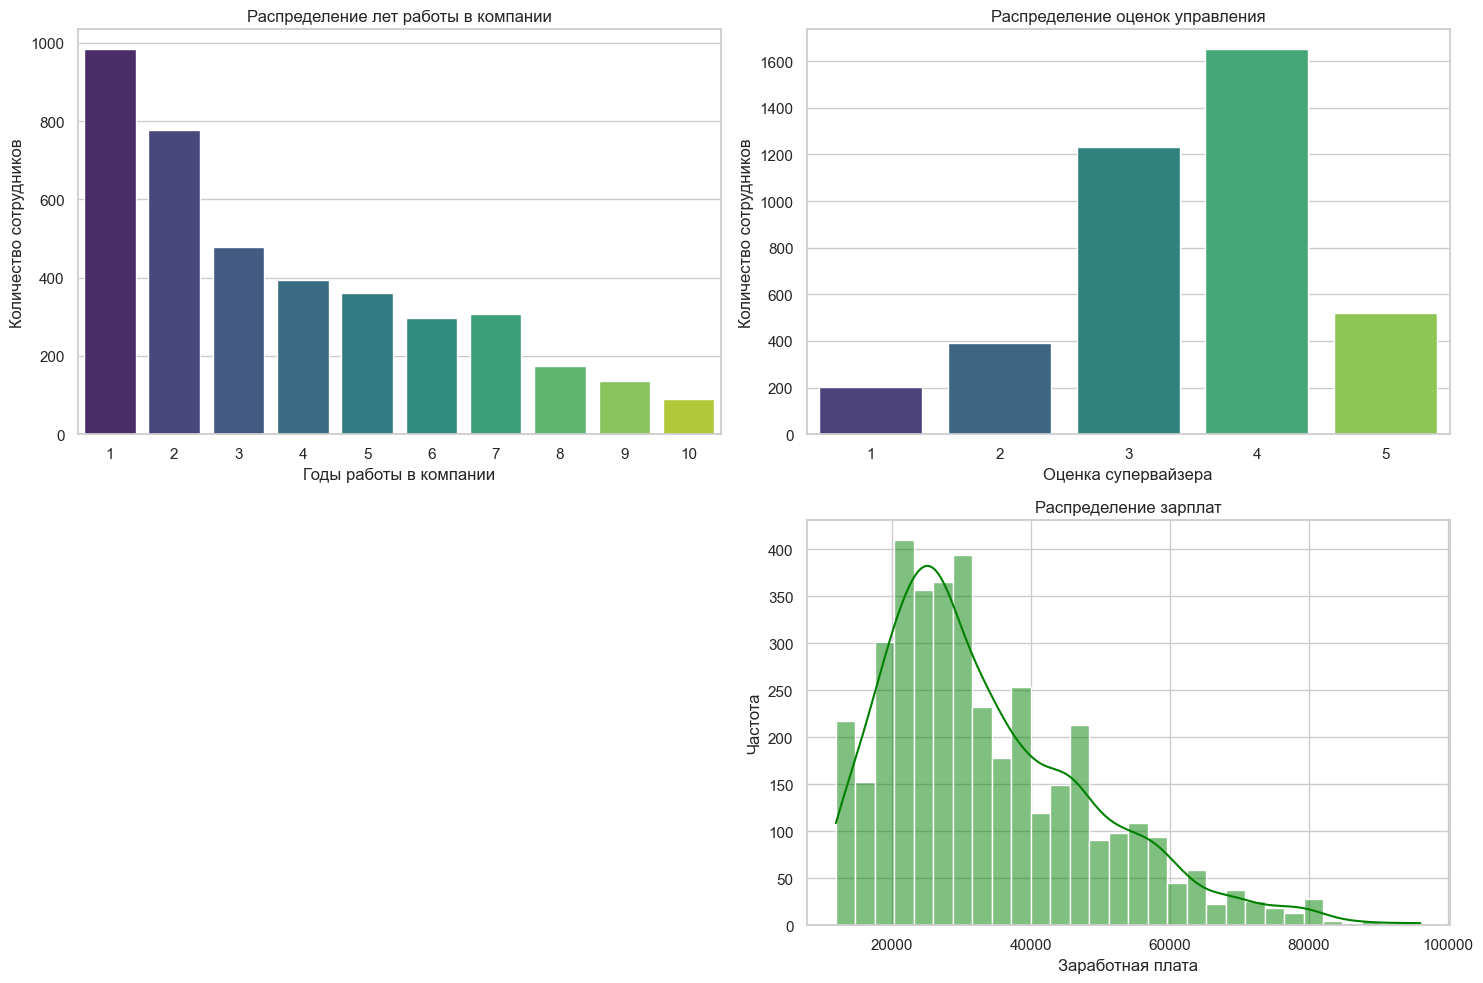

In [339]:
# Устанавливаем стиль для графиков
sns.set(style="whitegrid")

# Создаем фигуру для графиков
plt.figure(figsize=(15, 10))

# Для дискретных признаков
plt.subplot(2, 2, 1)  # График 1: employment_years
sns.countplot(x='employment_years', data=train_quit, palette='viridis')
plt.title('Распределение лет работы в компании')  # Название графика
plt.xlabel('Годы работы в компании')  # Подпись оси X
plt.ylabel('Количество сотрудников')  # Подпись оси Y

plt.subplot(2, 2, 2)  # График 2: supervisor_evaluation
sns.countplot(x='supervisor_evaluation', data=train_quit, palette='viridis')
plt.title('Распределение оценок управления')  # Название графика
plt.xlabel('Оценка супервайзера')  # Подпись оси X
plt.ylabel('Количество сотрудников')  # Подпись оси Y

# Для непрерывных признаков
plt.subplot(2, 2, 4)  # График 4: salary
sns.histplot(train_quit['salary'], bins=30, kde=True, color='green')
plt.title('Распределение зарплат')  # Название графика
plt.xlabel('Заработная плата')  # Подпись оси X
plt.ylabel('Частота')  # Подпись оси Y

plt.tight_layout()  # Улучшает внешний вид графиков
plt.show()  # Отображаем графики

Графики распределения числовых признаков train_quit аналогичны и сопоставимы с data_train

# Распределение категориальных и дискретных данных в train_quit

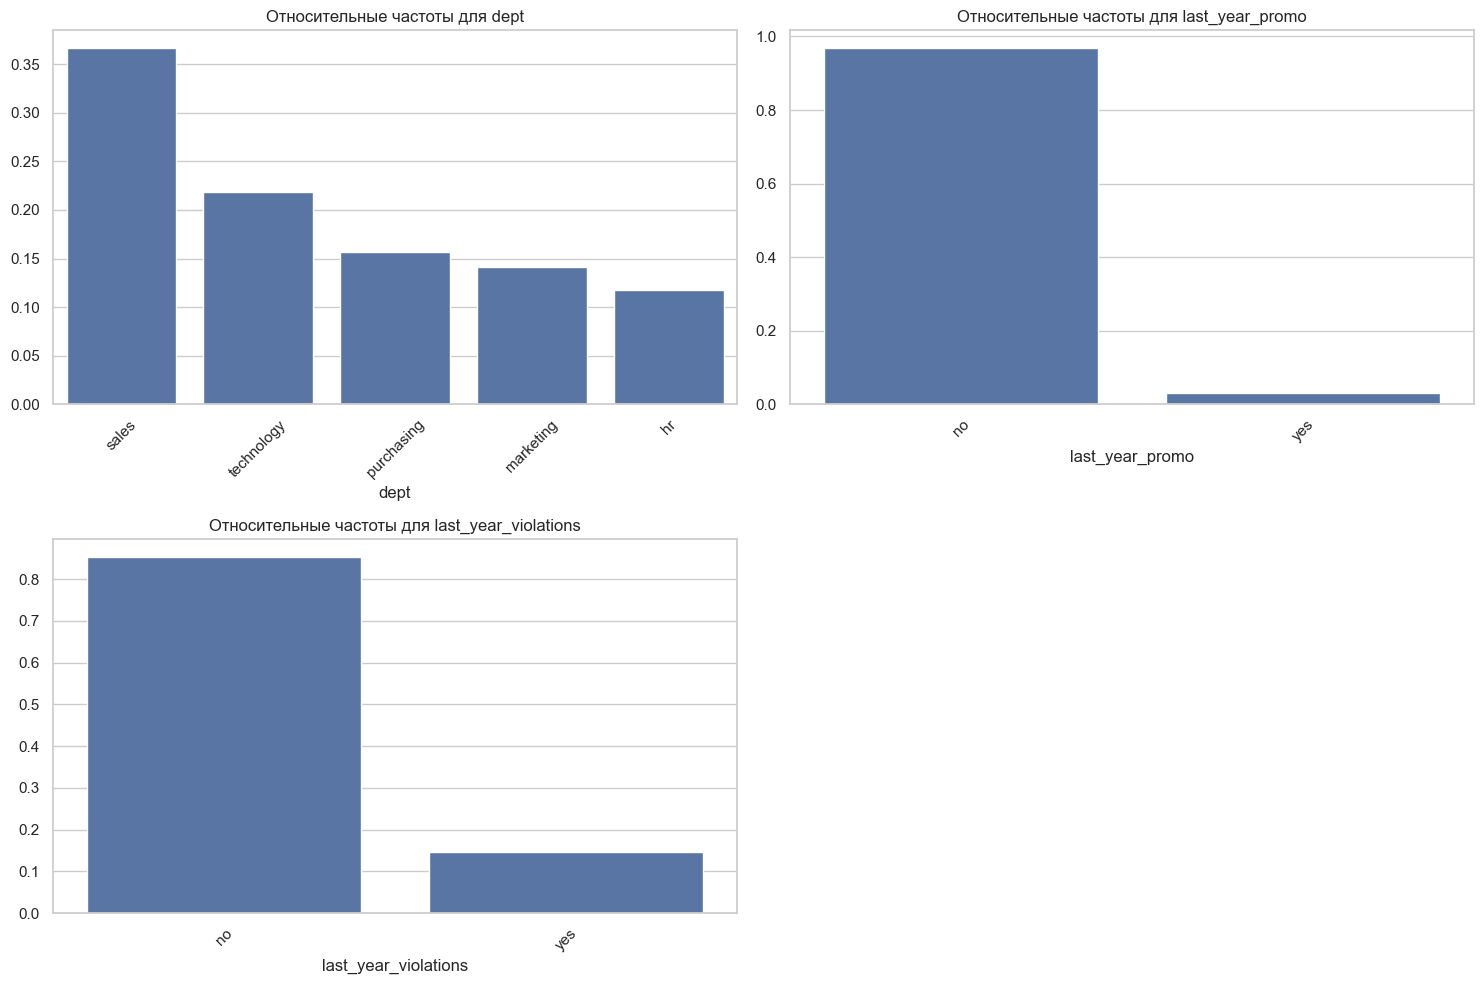

In [340]:
# Категориальные признаки train_quit
categorical_cols = ['dept', 'last_year_promo', 'last_year_violations']

# Анализ и визуализация
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    # Получаем относительные частоты
    relative_freq = data_train[col].value_counts(normalize=True)
    # Визуализируем
    sns.barplot(x=relative_freq.index, y=relative_freq.values)
    plt.title(f'Относительные частоты для {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Графики распределения категориальных признаков train_quit аналогичны и сопоставимы с data_train

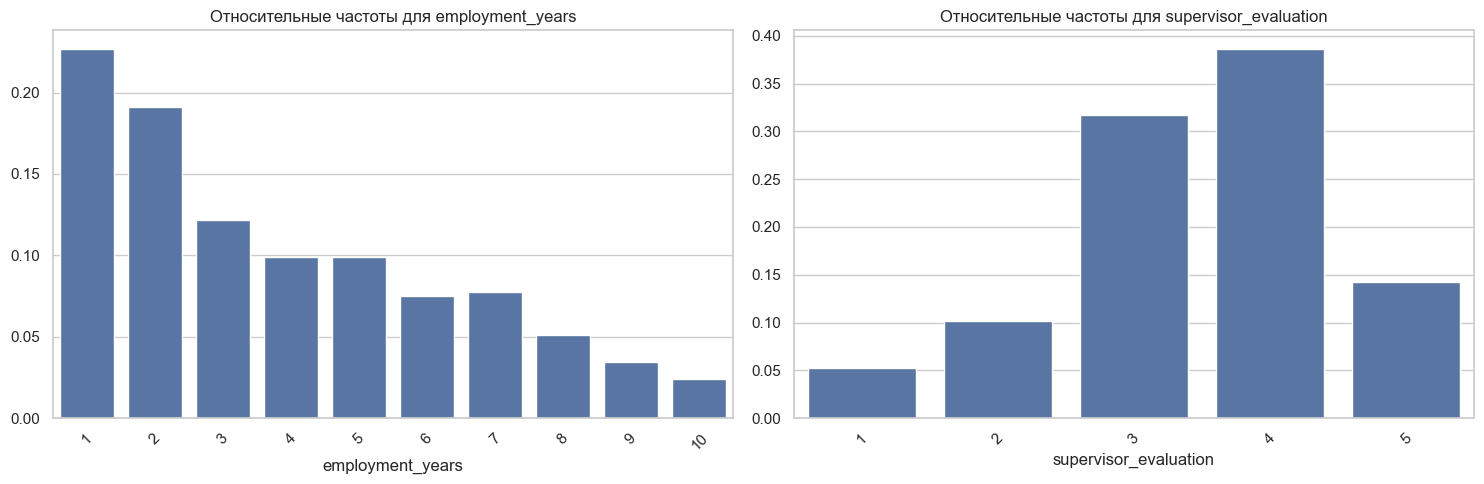

In [341]:
# Дискретные признаки train_quit в относительных показателях
discrete_cols = ['employment_years', 'supervisor_evaluation']

# Анализ и визуализация
plt.figure(figsize=(15, 5))
for i, col in enumerate(discrete_cols, 1):
    plt.subplot(1, 2, i)
    # Получаем относительные частоты
    relative_freq = data_train[col].value_counts(normalize=True)
    # Визуализируем
    sns.barplot(x=relative_freq.index, y=relative_freq.values)
    plt.title(f'Относительные частоты для {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Определение выбросов в данных train_quit

Медиана supervisor_evaluatione: 4.0


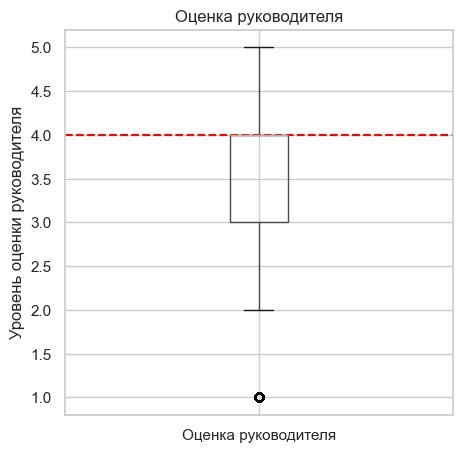

In [342]:
# Создаем boxplot для supervisor_evaluation у train_quit
train_quit[['supervisor_evaluation']].boxplot(figsize=(5, 5))

# Помечаем медиану на графике
median_supervisor_evaluation = np.median(train_quit['supervisor_evaluation'])
plt.axhline(median_supervisor_evaluation, color='red', linestyle='--')

# Выводим медиану
print(f'Медиана supervisor_evaluatione: {median_supervisor_evaluation}')

# Добавляем подписи и заголовок
plt.title('Оценка руководителя')
plt.ylabel('Уровень оценки руководителя')
plt.xticks([1], ['Оценка руководителя'])  # Подписываем ось X

# Показываем график
plt.show()

Медиана salary: 30000.0


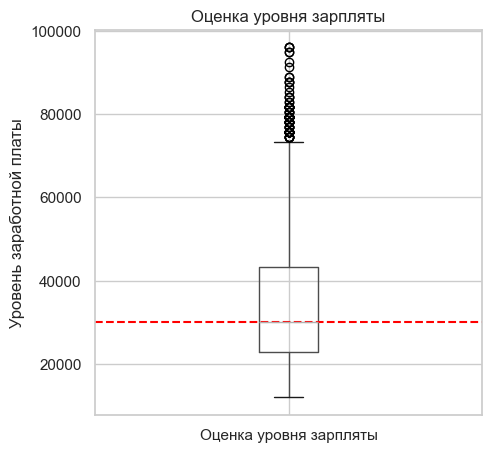

In [343]:
# boxplot для salary у train_quit
train_quit[['salary']].boxplot(figsize=(5, 5))

# Помечаем медиану на графике
median_salary = np.median(train_quit['salary'])
plt.axhline(median_salary, color='red', linestyle='--')

# Выводим медиану
print(f'Медиана salary: {median_salary}')

# Добавляем подписи и заголовок
plt.title('Оценка уровня зарпляты')
plt.ylabel('Уровень заработной платы')
plt.xticks([1], ['Оценка уровня зарпляты'])  # Подписываем ось X

# Показываем график
plt.show()

In [344]:
# Отбор уволенных сотрудников
terminated_employees = train_quit[train_quit['quit'] == 'yes']

# Сравнение средней зарплаты сотрудников terminated_employees с зарплатой остальных
mean_salary_terminated_employees = terminated_employees['salary'].mean()
mean_salary_stayers = train_quit[train_quit['quit'] == 'no']['salary'].mean()

print(f'Средняя зарплата уволившихся сотрудников: {mean_salary_terminated_employees}')
print(f'Средняя зарплата оставшихся сотрудников: {mean_salary_stayers}')

Средняя зарплата уволившихся сотрудников: 23885.106382978724
Средняя зарплата оставшихся сотрудников: 37702.22841225627


In [345]:
# Рассчитываем Q1 и Q3
Q1 = train_quit['salary'].quantile(0.25)
Q3 = train_quit['salary'].quantile(0.75)
IQR = Q3 - Q1

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Находим среднее значение в пределах интерквартильного размаха
mean_value = train_quit[(train_quit['salary'] >= lower_bound) & (train_quit['salary'] <= upper_bound)]['salary'].mean()

# Заменяем выбросы на среднее значение
train_quit['salary'] = train_quit['salary'].apply(lambda x: mean_value if x < lower_bound or x > upper_bound else x)

# Распределение корреляций данных в train_quit

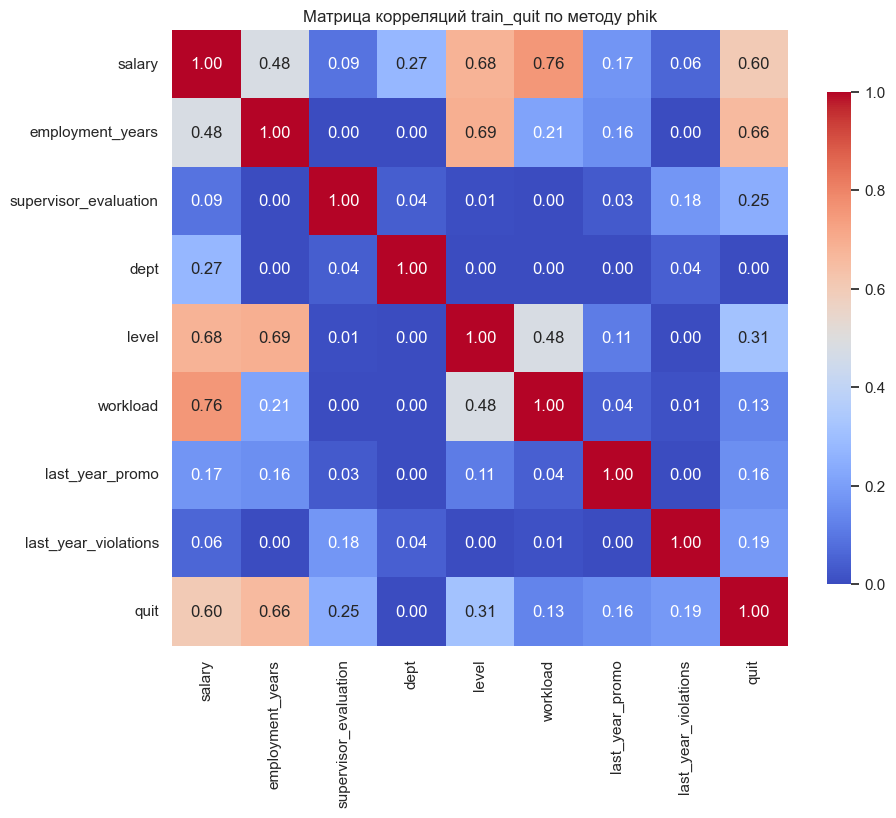

In [346]:
# Определяем колонки, которые будем использовать
# Интервальные (не корреологичные: employment_years и supervisor_evaluation)
interval_cols = ['salary']  # Непрерывные признаки
discrete_cols = ['employment_years', 'supervisor_evaluation']  # Дискретные

# Создаем список всех признаков
all_columns = train_quit.columns.tolist()

# Убираем из всех столбцов интервальные, дискретные и id, чтобы получить категориальные
categorical_cols = [col for col in all_columns if col not in interval_cols + discrete_cols + ['id']]

# Выводим матрицу корреляций с использованием метода phik
correlation_matrix = phik_matrix(train_quit[interval_cols + discrete_cols + categorical_cols], interval_cols=interval_cols)

# Рисуем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций train_quit по методу phik')
plt.show()

1. Самые сильные корреляции - значение 0,76 указывает на сильную + связь между переменными salary и workload. 0,68 указывают на умеренную связь между переменными salary и level, 0,69 - level и employment_years, 0,66 - quit и employment_years. 

С увеличением зарплаты возрастает и рабочая нагрузка - сотрудники с высоким уровнем зарплаты имеют более высокие ожидания в отношении своей рабочей нагрузки или работают на более ответственных позициях и высокие зарплаты связаны с более высокими должностями или уровнями в компании. Сотрудники с большим стажем имеют тенденцию занимать более высокие должности. С увеличением стажа работы вероятность увольнения также возрастает, что может указывать на высокую текучесть кадров среди более опытных сотрудников или на их желание искать новые возможности после определенного времени в одной компании.

2. 0,60 указывают на среднюю + связь между переменными salary и quit, 0,66 - employment_years и salary, 0,48 - level и workload.

Существует непосредственная связь между зарплатой и увольнениями, что может подразумевать, что более низкая зарплата ведет к увольнению. С увеличением стажа работы, как правило, увеличивается и зарплата, что соответствует общей практике в большинстве организаций.

3. Отсутствие корреляции - значения - 0-0,1 указывают на отсутствие линейной связи между переменными, таких корреляций большинство, по целевому признаку quit к слабым относятся: dept (0) - переменные не связаны. Также 0-0,1 имеют - salary и last_year_violations, salary и supervisor_evaluation, supervisor_evaluation и dept, supervisor_evaluation и level, supervisor_evaluation и workload, supervisor_evaluation и employment_years, supervisor_evaluation и last_year_promo, last_year_violations и dept, level, workload, last_year_promo, а last_year_promo никак не связан с dept, workload, last_year_violations, supervisor_evaluation. employment_years никак не связан с dept, last_year_violations, supervisor_evaluation. workload никак не связан с dept, last_year_violations, last_year_promo и supervisor_evaluation.

Многие переменные не имеют статистически значимого влияния на целевой признак. Например, dept и last_year_violations не показывают значимой взаимосвязи с увольнением, не влияют на решение сотрудников уволиться. salary и supervisor_evaluation, также имеют слабую связь с увольнениями, что поднимает вопросы о роли менеджмента и поддержки сотрудников.

4. Слабые связи - 0,1-0,4 - quit и level, workload, last_year_promo, last_year_violations, supervisor_evaluation. salary и dept, last_year_promo. supervisor_evaluation и last_year_violations. last_year_promo и employment_years. employment_years и workload.

quit и level, workload, last_year_promo, last_year_violations, supervisor_evaluation могут указывать на факторы, которые необходимо учитывать в дальнейшем анализе, но они не являются главными детерминантами увольнения. Корреляции между supervisor_evaluation и last_year_violations и last_year_promo также показывают, что оценки супервайзеров не всегда соответствуют результативности сотрудников и наличию нарушений.

Предоставлена полезная информация для понимания взаимосвязей между увольнением и другими переменными в наборе данных. Сильная корреляция между salary и quit указывает на необходимость провести дополнительные исследования по управлению компенсациями и удержанию сотрудников. 

# Определение выбросов в данных train_quit

Медиана salary: 30000.0


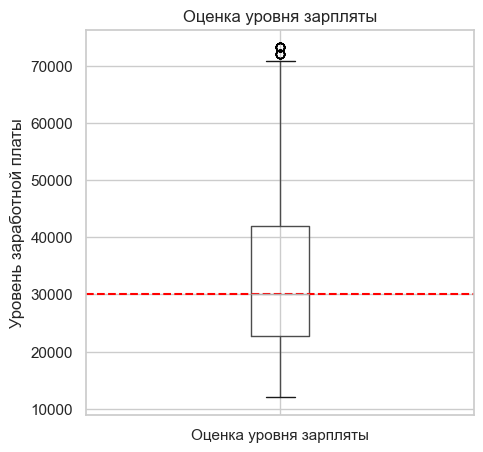

In [347]:
# boxplot для salary у train_quit
train_quit[['salary']].boxplot(figsize=(5, 5))

# Помечаем медиану на графике
median_salary = np.median(train_quit['salary'])
plt.axhline(median_salary, color='red', linestyle='--')

# Выводим медиану
print(f'Медиана salary: {median_salary}')

# Добавляем подписи и заголовок
plt.title('Оценка уровня зарпляты')
plt.ylabel('Уровень заработной платы')
plt.xticks([1], ['Оценка уровня зарпляты'])  # Подписываем ось X

# Показываем график
plt.show()

Устранены выбросы, обе выборки сопоставимы

# Портрет «уволившегося сотрудника»

Чаще всего это сотрудник отдела продаж, что может указывать на высокую текучесть кадров или специфику работы отдела. Вероятнее всего, сотрудник занимал позицию junior. Младшие специалисты часто увольняются из-за отсутствия карьерного роста или неудовлетворённости условиями труда.

Уровень нагрузки у сотрудника был скорее всего низкий. Возможно, он испытывал недостаток вызова или интересных задач, что могло стать одной из причин увольнения. Скорее всего, сотрудник не получил продвижения в прошлом году, что могло повлиять на решение об уходе. Большинство уволившихся сотрудников соблюдали правила и нормы компании.

Средняя оценка сотрудника составляла около 3.05 из 5, что соответствует среднему уровню выполнения обязанностей. При этом диапазон оценок варьируется от 1 до 5 - есть вероятность, что сотрудник мог получить как низкую, так и высокую оценку.
 
Средняя зарплата уволившегося сотрудника составляла 23 885 рублей, однако разброс зарплат значительный: минимальная зарплата — 12 000 рублей, максимальная — 79 200 рублей - сотрудник мог получать как невысокую, так и достаточно приличную заработную плату.

Этот портрет отражает общие тенденции среди уволившихся сотрудников и помогает понять возможные причины ухода, такие как отсутствие карьерного роста, низкая нагрузка, средняя производительность и относительно короткий опыт работы в компании.

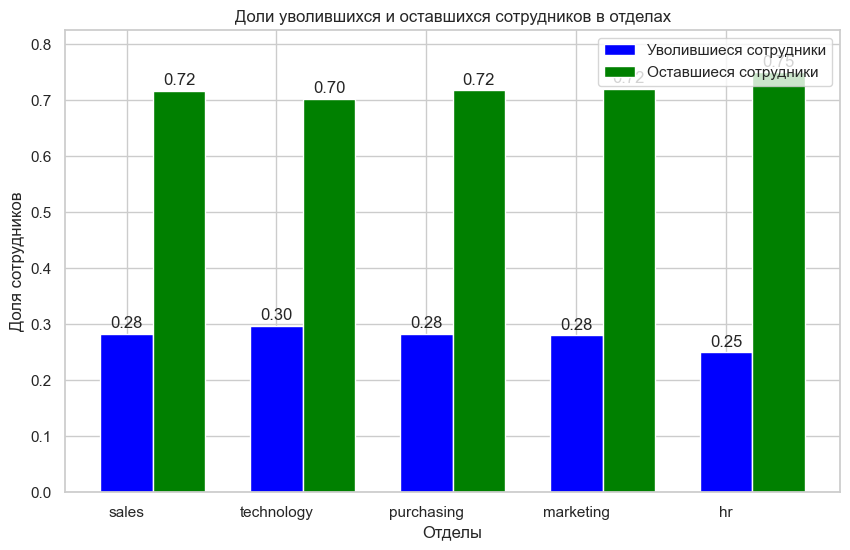

In [348]:
# Вычисляем общее количество сотрудников в каждом отделе
dept_counts = train_quit['dept'].value_counts()

# Вычисляем количество уволившихся сотрудников в каждом отделе
terminated_by_dept = train_quit[train_quit['quit'] == 'yes']['dept'].value_counts()

# Вычисляем долю уволившихся сотрудников в каждом отделе
dept_quit_rates = terminated_by_dept / dept_counts

# Вычисляем долю оставшихся сотрудников в каждом отделе
remaining_employees = dept_counts - terminated_by_dept
dept_remaining_rates = remaining_employees / dept_counts

# Создаем список отделов и соответствующих им долей уволившихся и оставшихся сотрудников
departments = list(dept_quit_rates.index)
quit_rates = list(dept_quit_rates.values)
remaining_rates = list(dept_remaining_rates.values)

# Строим график
plt.figure(figsize=(10, 6))
bar_width = 0.35  # Ширина столбца

# Построение столбцов для доли уволившихся сотрудников
plt.bar(departments, quit_rates, width=bar_width, label='Уволившиеся сотрудники', color='blue')

# Построение столбцов для доли оставшихся сотрудников
plt.bar([x + bar_width for x in range(len(departments))], remaining_rates, width=bar_width, label='Оставшиеся сотрудники', color='green')

plt.xlabel('Отделы')
plt.ylabel('Доля сотрудников')
plt.title('Доли уволившихся и оставшихся сотрудников в отделах')
plt.legend(loc='upper right')  # Легенда для обозначения цветов столбцов

# Установка пределов оси Y для лучшего отображения
max_rate = max(max(quit_rates), max(remaining_rates))
plt.ylim(0, max_rate * 1.1)

# Добавление подписей значений над столбцами
for i, v in enumerate(quit_rates):
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', va='bottom')
    
for i, v in enumerate(remaining_rates):
    plt.text(i + bar_width, v + 0.005, f"{v:.2f}", ha='center', va='bottom')

plt.show() 

Самая высокая доля уволившихся сотрудников наблюдается в отделе технологии 30%.
Отделы продаж, закупок и маркетинга имеют одинаковую долю 28% - здесь немного меньше серьезных проблем.
Самая низкая доля в отделе кадров (25%) - возможно более положительная рабочая культура.

При этом предварительно было установлено, что половина сотрудников не получала повышения в прошлом году, и большинство не довольны уровнем зарплаты, но т.к. повышения, имеют слабые корреляции, значит уровень зарплаты является определяющим в решении сотрудников.

Т.о., возможные причины высокой доли уволившихся в отделе технологии скорее всего комплексные: низкий уровень зарплаты и отсутствие возможностей для карьерного роста может побудить их искать работу в другом месте, также в отделе может быть негативная или токсичная рабочая культура, которая отталкивает сотрудников и приводит к увольнениям. Сотрудники могут быть перегружены работой, что приводит к стрессу, выгоранию и увольнению, однако большинство уволившихся имели низкий уровень загрузуки.

quit_group  dept      
Оставшиеся  hr            1.0
            marketing     1.0
            purchasing    1.0
            sales         1.0
            technology    1.0
Уволенные   hr            1.0
            marketing     1.0
            purchasing    1.0
            sales         1.0
            technology    1.0
Name: доля, dtype: float64


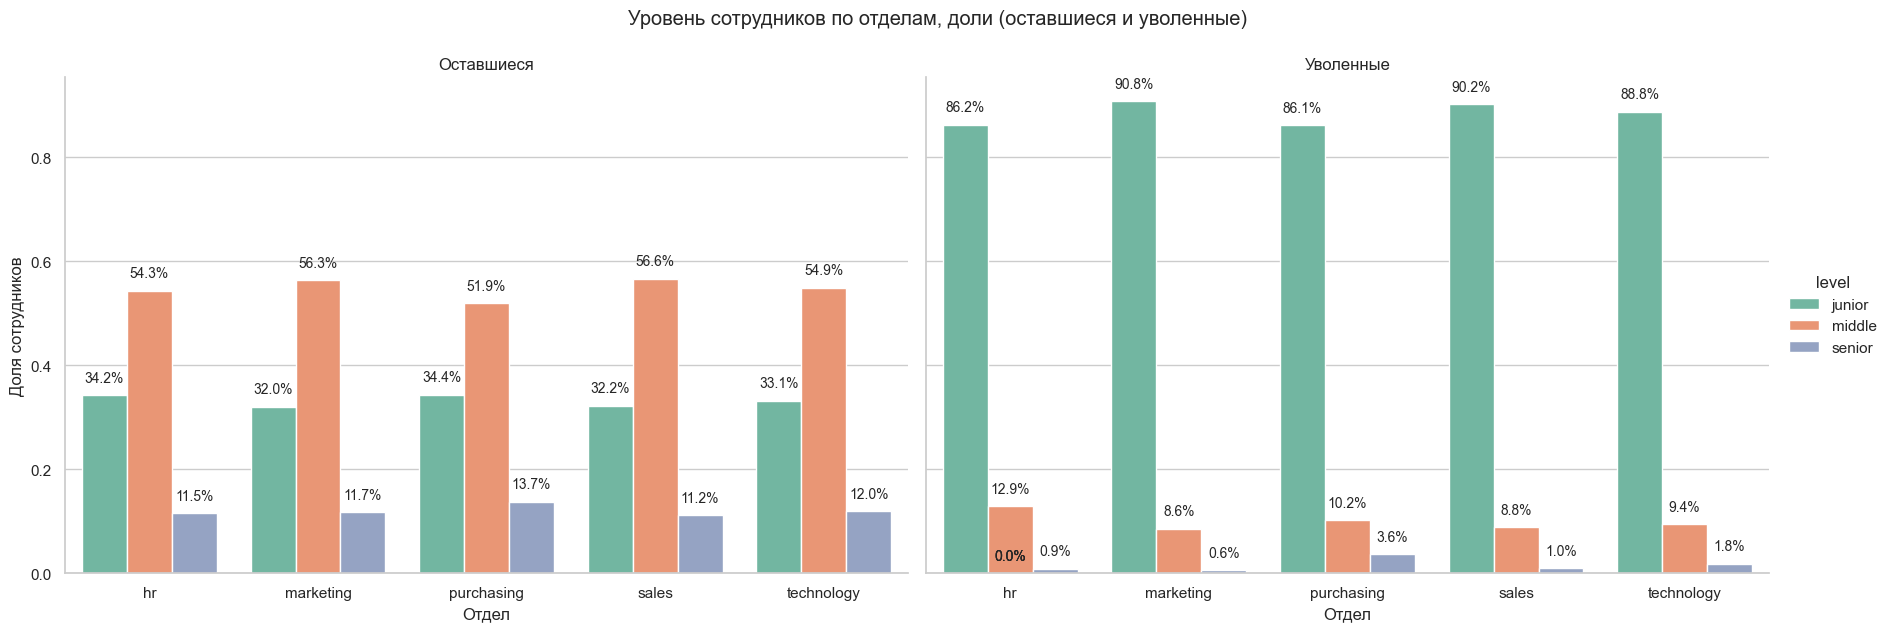

In [349]:
# Указываем порядок уровней
level_order = ['junior', 'middle', 'senior']

# Фильтруем данные, исключая nan в level и dept
filtered_data = train_quit.dropna(subset=['level', 'dept'])

# Разделяем данные на уволенных и оставшихся
filtered_data['quit_group'] = filtered_data['quit'].map({'yes': 'Уволенные', 'no': 'Оставшиеся'})

# Рассчитываем доли для каждого уровня в каждом отделе и группе
grouped_data = (
    filtered_data.groupby(['quit_group', 'dept', 'level'])
    .size()  # Количество сотрудников
    .unstack(fill_value=0)  # Преобразуем в широкий формат
    .apply(lambda x: x / x.sum(), axis=1)  # Переводим в доли
    .stack()  # Возвращаем в длинный формат
    .reset_index(name='доля')  # Переименовываем столбец
)

# Проверяем, что сумма долей в каждой группе и отделе равна 100%
check_sum = grouped_data.groupby(['quit_group', 'dept'])['доля'].sum()
print(check_sum)

# Строим график
g = sns.catplot(
    data=grouped_data, x='dept', y='доля', hue='level', col='quit_group', 
    kind='bar', palette='Set2', height=6, aspect=1.5, hue_order=level_order
)

# Добавляем подписи значений на график
for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.,  # Позиция по X
            height + 0.02,  # Позиция по Y 
            f'{height:.1%}',  # Форматируем как проценты
            ha='center', va='bottom', fontsize=10
        )

# Настройка заголовков и осей
g.set_axis_labels('Отдел', 'Доля сотрудников')
g.set_titles('{col_name}')
plt.suptitle('Уровень сотрудников по отделам, доли (оставшиеся и уволенные)', y=1.05)
plt.show()

Общий анализ по отделам.
Оставшиеся сотрудники: Во всех отделах преобладают сотрудники уровня middle (от 51% до 56%), уровень junior составляет от 32% до 34%, уровень senior — от 12% до 15%.

Наиболее сбалансированный отдел - рurchasing: 34% junior, 51% middle, 15% senior - больше всего сотрудников уровня senior среди всех отделов. Наименее сбалансированный отдел - Мarketing и Sales - 32% junior, 56% middle, 12% senior - доля сотрудников уровня middle максимальна, а senior — минимальна.

Уволенные сотрудники: Преобладают сотрудники уровня junior (от 86% до 96%), уровень middle составляет от 3% до 13%, senior — всего 1%.

Наиболее проблемные отделы Мarketing, Sales и Technology: 96% junior, 3% middle, 1% senior - подавляющее большинство уволенных — сотрудники уровня junior. Наименее проблемный отдел - HR и Purchasing: 86% junior, 13% middle, 1% senior - доля уволенных сотрудников уровня middle выше, чем в других отделах.

Сравнение оставшихся и уволенных
Уровень junior: оставшиеся: 32–34%, уволенные: 86–96%. Сотрудники уровня junior составляют основную долю уволенных, что может указывать на проблемы с адаптацией, обучением или мотивацией молодых специалистов.

Уровень middle: оставшиеся: 51–56%, уволенные: 3–13%. Сотрудники уровня middle реже увольняются, что может говорить о их стабильности и удовлетворенности работой.

Уровень senior: оставшиеся: 12–15%, уволенные: 1%. Сотрудники уровня senior практически не увольняются, что может быть связано с их высокой вовлеченностью и ценностью для компании.

quit_group  dept      
Оставшиеся  hr            1.0
            marketing     1.0
            purchasing    1.0
            sales         1.0
            technology    1.0
Уволенные   hr            1.0
            marketing     1.0
            purchasing    1.0
            sales         1.0
            technology    1.0
Name: доля, dtype: float64


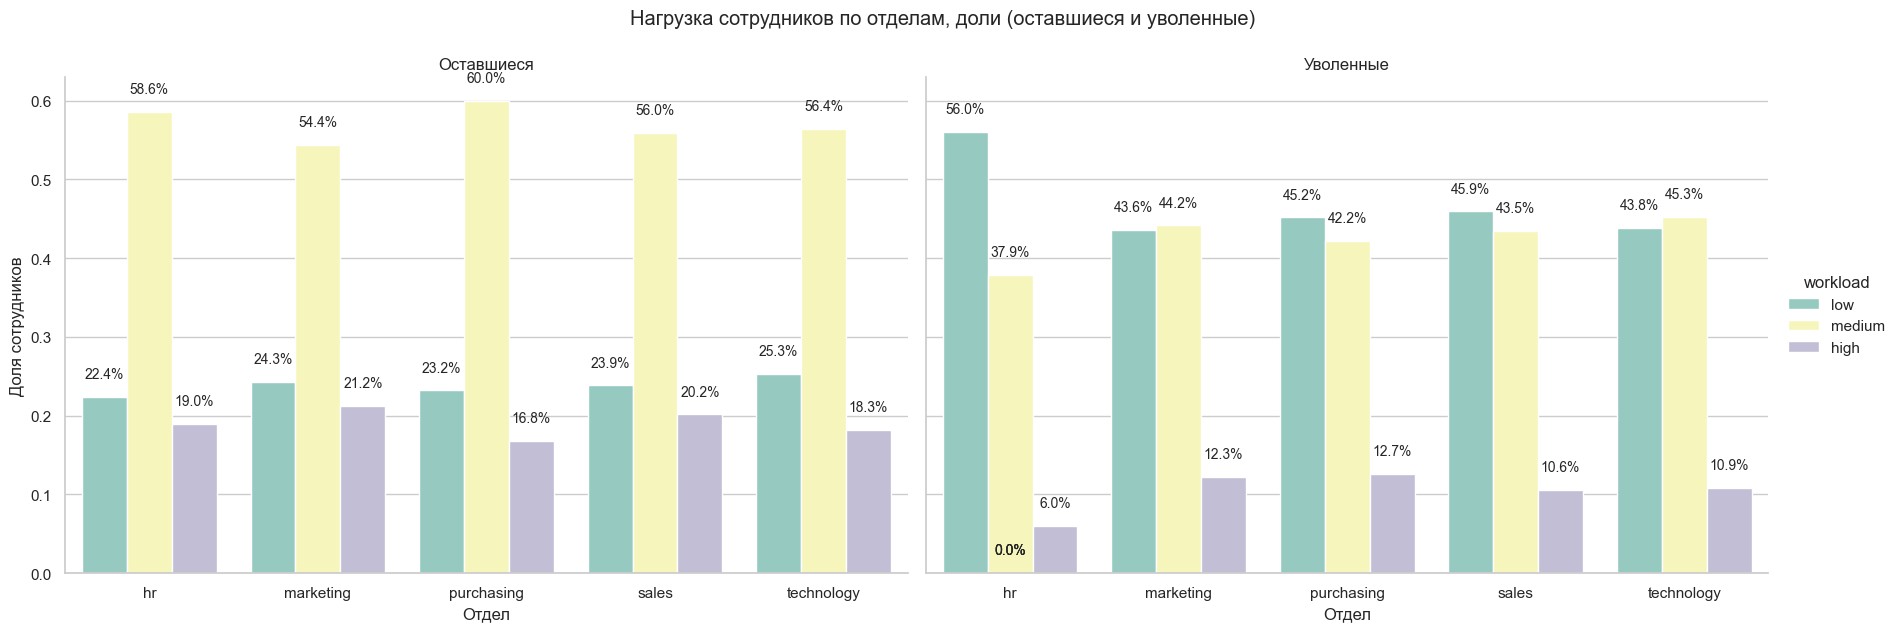

In [350]:
# Указываем порядок уровней нагрузки
workload_order = ['low', 'medium', 'high']

# Фильтруем данные, исключая nan в workload и dept
filtered_data = train_quit.dropna(subset=['workload', 'dept'])

# Разделяем данные на уволенных и оставшихся
filtered_data['quit_group'] = filtered_data['quit'].map({'yes': 'Уволенные', 'no': 'Оставшиеся'})

# Рассчитываем доли для каждого уровня нагрузки в каждом отделе и группе
grouped_data = (
    filtered_data.groupby(['quit_group', 'dept', 'workload'])
    .size()  # Количество сотрудников
    .unstack(fill_value=0)  # Преобразуем в широкий формат
    .apply(lambda x: x / x.sum(), axis=1)  # Нормализуем по строкам (отделам внутри групп)
    .stack()  # Возвращаем в длинный формат
    .reset_index(name='доля')  # Переименовываем столбец
)

# Проверяем, что сумма долей в каждой группе и отделе равна 100%
check_sum = grouped_data.groupby(['quit_group', 'dept'])['доля'].sum()
print(check_sum)

# Строим график
g = sns.catplot(
    data=grouped_data, x='dept', y='доля', hue='workload', col='quit_group', 
    kind='bar', palette='Set3', height=6, aspect=1.5, hue_order=workload_order
)

# Добавляем подписи значений на график
for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.,  # Позиция по X
            height + 0.02,  # Позиция по Y 
            f'{height:.1%}',  # Форматируем как проценты
            ha='center', va='bottom', fontsize=10
        )

# Настройка заголовков и осей
g.set_axis_labels('Отдел', 'Доля сотрудников')
g.set_titles('{col_name}')
plt.suptitle('Нагрузка сотрудников по отделам, доли (оставшиеся и уволенные)', y=1.05)
plt.show()

Общий анализ по загруженности
Оставшиеся сотрудники: преобладает Medium (средняя нагрузка) - 54–62%, Low (низкая нагрузка) - 22–28%, High (высокая нагрузка) - 15–22%.

Наиболее сбалансированный отдел - Purchasing: 23% low, 62% medium, 15% high, здесь самая высокая доля сотрудников со средней нагрузкой. Наименее сбалансированный отдел - Sales: 24% low, 54% medium, 22% high - самая высокая доля сотрудников с высокой нагрузкой.

Уволенные сотрудники: преобладает Low (низкая нагрузка) - 42–56%, Medium (средняя нагрузка) - 32–46%, High (высокая нагрузка) - 12–13%.

Наиболее проблемный отдел - HR: 56% low, 32% medium, 12% high - самая высокая доля уволенных сотрудников с низкой нагрузкой.
Наименее проблемный отдел - Marketing: 42% low, 46% medium, 12% high - доля уволенных сотрудников со средней нагрузкой выше, чем в других отделах.

Сравнение оставшихся и уволенных
Низкая нагрузка (low): Оставшиеся - 22–28%, уволенные - 42–56%. Сотрудники с низкой нагрузкой чаще увольняются, что может указывать на недостаток мотивации или вовлеченности у сотрудников с низкой загруженностью.

Средняя нагрузка (medium): Оставшиеся - 54–62%, уволенные - 32–46%. Сотрудники со средней нагрузкой реже увольняются, значит средняя нагрузка оптимальна для большинства сотрудников.

Высокая нагрузка (high): Оставшиеся - 15–22%, уволенные: 12–13%. Сотрудники с высокой нагрузкой увольняются реже, чем сотрудники с низкой нагрузкой, что может быть связано с их высокой вовлеченностью или карьерными амбициями.

quit_group  dept      
Оставшиеся  hr            1.0
            marketing     1.0
            purchasing    1.0
            sales         1.0
            technology    1.0
Уволенные   hr            1.0
            marketing     1.0
            purchasing    1.0
            sales         1.0
            technology    1.0
Name: доля, dtype: float64


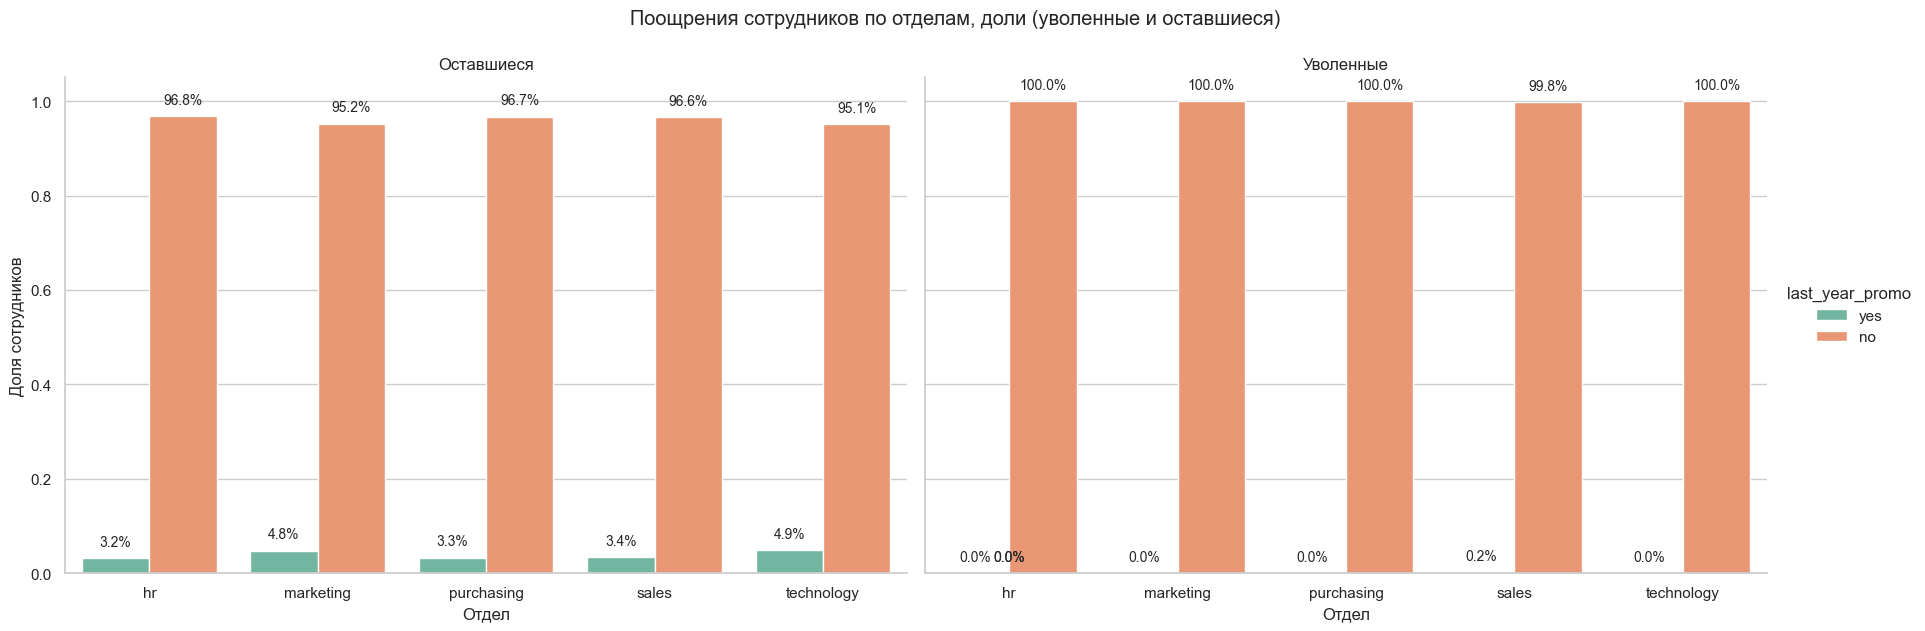

In [351]:
# Указываем порядок уровней повышений
last_year_promo_order = ['yes', 'no']

# Фильтруем данные, исключая nan в last_year_promo и dept
filtered_data = train_quit.dropna(subset=['last_year_promo', 'dept'])

# Разделяем данные на уволенных и оставшихся
filtered_data['quit_group'] = filtered_data['quit'].map({'yes': 'Уволенные', 'no': 'Оставшиеся'})

# Рассчитываем доли для каждого значения повышения в каждом отделе и группе
grouped_data = (
    filtered_data.groupby(['quit_group', 'dept', 'last_year_promo'])
    .size()  # Количество сотрудников
    .unstack(fill_value=0)  # Преобразуем в широкий формат
    .apply(lambda x: x / x.sum(), axis=1)  # Нормализуем по строкам (отделам внутри групп)
    .stack()  # Возвращаем в длинный формат
    .reset_index(name='доля')  # Переименовываем столбец
)

# Проверяем, что сумма долей в каждой группе и отделе равна 100%
check_sum = grouped_data.groupby(['quit_group', 'dept'])['доля'].sum()
print(check_sum)

# Строим график
g = sns.catplot(
    data=grouped_data, x='dept', y='доля', hue='last_year_promo', col='quit_group', 
    kind='bar', palette='Set2', height=6, aspect=1.5, hue_order=last_year_promo_order
)

# Добавляем подписи значений на график
for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.,  # Позиция по X
            height + 0.02,  # Позиция по Y
            f'{height:.1%}',  # Форматируем как проценты
            ha='center', va='bottom', fontsize=10
        )

# Настройка заголовков и осей
g.set_axis_labels('Отдел', 'Доля сотрудников')
g.set_titles('{col_name}')
plt.suptitle('Поощрения сотрудников по отделам, доли (уволенные и оставшиеся)', y=1.05)
plt.show()

Практически ни один из уволенных сотрудников не получил повышение в прошлом году, скаорее всего отсутствие поощрений могло быть одним из факторов увольнения. Необходимо рассмотреть возможность увеличения частоты поощрений, предложить программы развития и карьерного роста. Для сотрудников, получивших повышение - продолжать удерживать через поощрения, рассмотреть возможность дополнительных мотивационных программ.

Для отделов HR, Purchasing, Sales - уделить особое внимание сотрудникам, не получившим повышение. Marketing и Technology - поддерживать текущий уровень поощрений и рассмотреть возможность его увеличения.

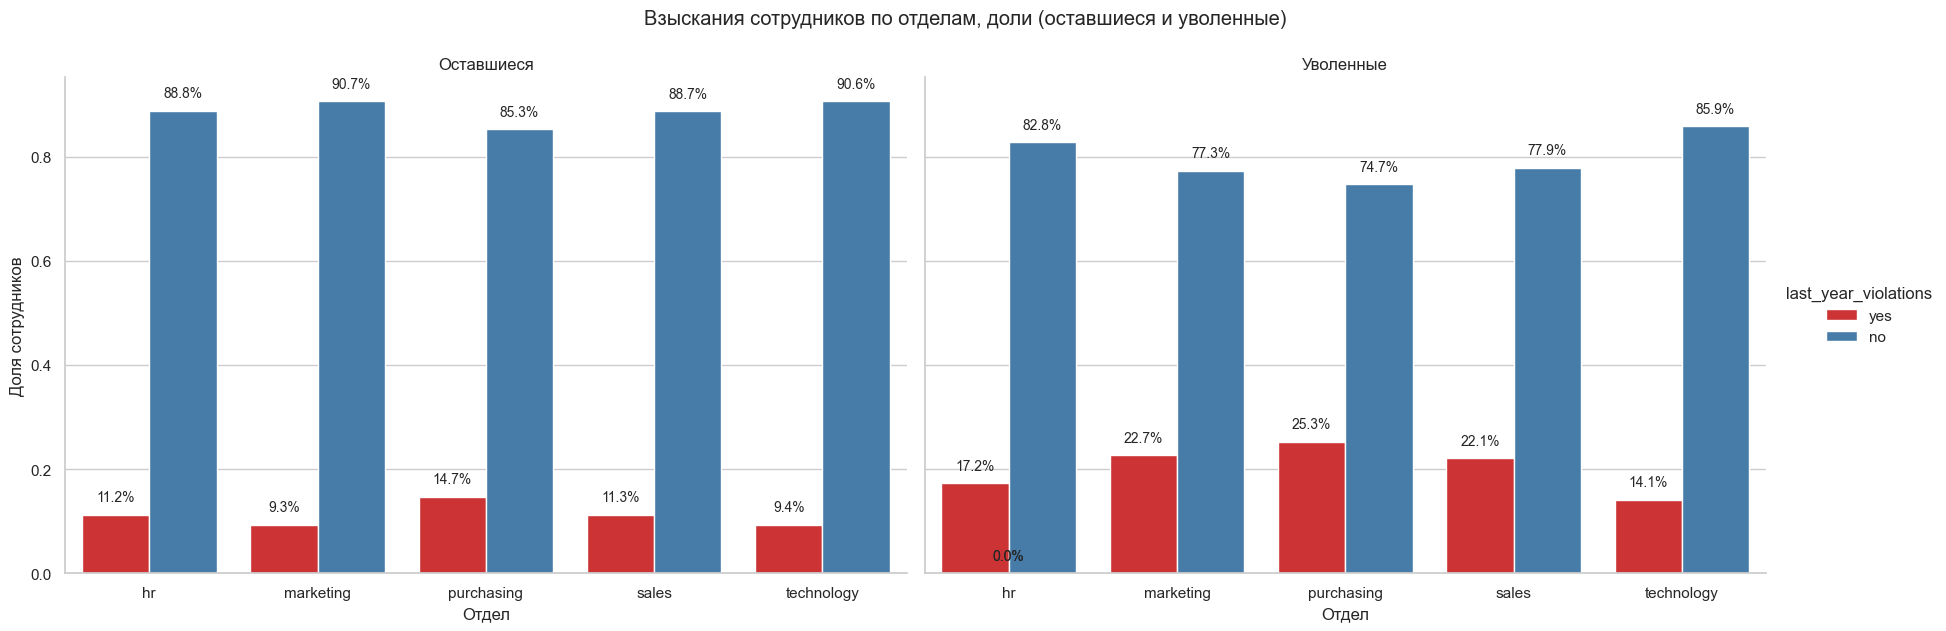

In [352]:
# Указываем порядок уровней взысканий
last_year_violations_order = ['yes', 'no']

# Фильтруем данные, исключая nan в last_year_violations и dept
filtered_data = train_quit.dropna(subset=['last_year_violations', 'dept'])

# Разделяем данные на уволенных и оставшихся
filtered_data['quit_group'] = filtered_data['quit'].map({'yes': 'Уволенные', 'no': 'Оставшиеся'})

# Рассчитываем доли для каждого значения взысканий в каждом отделе
grouped_data = (
    filtered_data.groupby(['quit_group', 'dept', 'last_year_violations'])
    .size()  # Количество сотрудников
    .unstack(fill_value=0)  # Преобразуем в широкий формат
    .apply(lambda x: x / x.sum(), axis=1)  # Переводим в доли
    .stack()  # Возвращаем в длинный формат
    .reset_index(name='доля')  # Переименовываем столбец
)

# Строим график
g = sns.catplot(
    data=grouped_data, x='dept', y='доля', hue='last_year_violations', col='quit_group', 
    kind='bar', palette='Set1', height=6, aspect=1.5, hue_order=last_year_violations_order
)

# Добавляем подписи значений на график
for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.,  # Позиция по X
            height + 0.02,  # Позиция по Y 
            f'{height:.1%}',  # Форматируем как проценты
            ha='center', va='bottom', fontsize=10
        )

# Настройка заголовков и осей
g.set_axis_labels('Отдел', 'Доля сотрудников')
g.set_titles('{col_name}')
plt.suptitle('Взыскания сотрудников по отделам, доли (оставшиеся и уволенные)', y=1.05)
plt.show()

Во всех отделах процент сотрудников, получивших взыскания, выше среди уволенных, чем среди остающихся - дисциплинарные меры фиксируются среди увольняемых сотрудников чаще. Наиболее заметное отличие наблюдается в отделах Purchasing и Sales, где разница составляет примерно 7–11 процентных пунктов (Purchasing - 25% уволенных против 14% остающихся, Sales - 21% против 12%).

В отделах HR и Technology разница менее выражена, но всё же уволенные имеют более высокий процент взысканий (HR - 17% против 12%, Technology - 14% против 9%). Т.о., факт получения взыскания может сыграть роль в решении об увольнении сотрудника или свидетельствовать о проблемах в работе, которые в дальнейшем способствуют увольнению, наличие взысканий коррелирует с повышенной вероятностью увольнения. При этом среди остающихся сотрудников взыскания фиксируются реже, что может свидетельствовать о более стабильном поведении или соблюдении внутренних норм компании.

# Визуализация и сравнение распределения признаков для уволившихся и оставшихся сотрудников с обоими целевыми признаками тестовой выборки

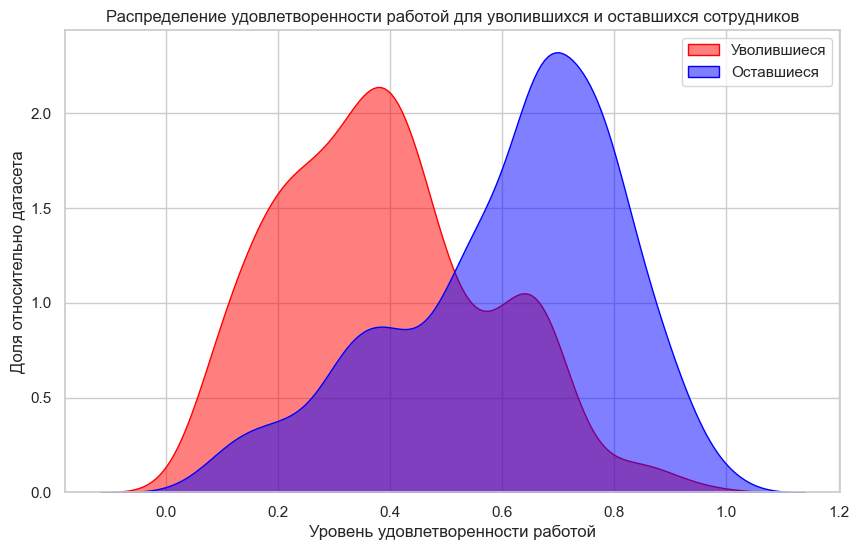

In [353]:
# Объединим таблицы по id
data = pd.merge(data_test, data_target, on='id')
data = pd.merge(data, test_target_quit, on='id')

# Устанавливаем стиль для графиков
sns.set(style="whitegrid")

# Создаем график плотности для удовлетворенности работой
plt.figure(figsize=(10, 6))

# График плотности для уволившихся сотрудников
sns.kdeplot(data=data[data['quit'] == 'yes'], x='job_satisfaction_rate', label='Уволившиеся', fill=True, color='red', alpha=0.5)

# График плотности для оставшихся сотрудников
sns.kdeplot(data=data[data['quit'] == 'no'], x='job_satisfaction_rate', label='Оставшиеся', fill=True, color='blue', alpha=0.5)

# Настройка графика
plt.title('Распределение удовлетворенности работой для уволившихся и оставшихся сотрудников')
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('Доля относительно датасета')
plt.legend()
plt.show()

job_satisfaction_rate с quit yes - правостороннее наклонное распределение (большинство данных сгруппировано в левой части гистограммы, а хвост простирается вправо). Большинство сотрудников имеют низкую удовлетворенность, у небольшой группы сотрудников удовлетворенность приближается к 0,9.
job_satisfaction_rate  с quit no  - левостороннее наклонное распределение (Большинство данных сгруппировано в правой части гистограммы, а хвост простирается влево). Большинство сотрудников имеют высокую удовлетворенность работой, у небольшой группы - очень низкая, приближается к 0.

# Объединение тестовых данных 2: test_features и test_target_quit в union_data

In [354]:
# Объединение двух DataFrame test_features и test_target_quit по 'id'
union_data = pd.merge(test_features, test_target_quit, on='id', how='left')

# Вывод объединенного DataFrame
display(union_data)

id        dept   level workload  employment_years last_year_promo  \
0     485046   marketing  junior   medium                 2              no   
1     686555          hr  junior   medium                 1              no   
2     467458       sales  middle      low                 5              no   
3     418655       sales  middle      low                 6              no   
4     789145          hr  middle   medium                 5              no   
...      ...         ...     ...      ...               ...             ...   
1995  393147   marketing  junior      low                 3              no   
1996  109582  technology  middle      low                 3              no   
1997  305653  technology  junior      low                 1              no   
1998  160233  technology  middle      low                 8              no   
1999  771859  purchasing  middle   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary quit  
0                      no                      5   28800   no  
1                      no                      4   30000   no  
2                      no                      4   19200   no  
3                      no                      4   19200   no  
4                      no                      5   40800   no  
...                   ...                    ...     ...  ...  
1995                   no                      3   20400  yes  
1996                   no                      2   21600  yes  
1997                   no                      3   14400  yes  
1998                   no                      1   32400   no  
1999                   no                      4   38400   no  

[2000 rows x 10 columns]

In [355]:
print(union_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 156.4+ KB
None


In [356]:
print(union_data.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'quit']


In [357]:
# Проверяем наличие дубликатов
duplicates = union_data.duplicated()

# Выводим количество дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в данных: {num_duplicates}")

Количество дубликатов в данных: 0


In [358]:
# Выводим дубликаты
if num_duplicates > 0:
    print("Дубликаты:")
    display(union_data[duplicates])

In [359]:
# Проверим наличие строк с некорректным значением в data_train
idx = union_data[union_data['quit'] == 'sales'].index

# Выведем эти строки на экран
print(union_data.loc[idx])

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, quit]
Index: []


In [360]:
print(union_data['quit'].dtype)

object


In [361]:
print(union_data['quit'].isna().sum())

0


# Шаг 4. Добавление нового входного признака

job_satisfaction_rate и quit действительно связаны и мы получили необходимое значение метрики в первой задаче. Добавляем job_satisfaction_rate, предсказанный лучшей моделью первой задачи DecisionTreeRegressor, к входным признакам второй задачи.

Для добавления нового признака predicted_job_satisfaction_rate в данные второй задачи нужно использовать лучшую модель из первой задачи (DecisionTreeRegressor), сделать предсказания, атем добавить это предсказание в соответствующие наборы данных. 

In [362]:
# Используем лучшую модель из первой задачи (DecisionTreeRegressor)

# Делаем предсказания для job_satisfaction_rate на тестовой выборке
X_test = data_test.drop(columns=['id'])  # Убираем столбец 'id'

# Проверяем соответствие признаков
print("Обучающий набор данных (количество признаков):", X.shape[1])
print("Тестовый набор данных (количество признаков):", X_test.shape[1])

# Проверки признаков
print("Признаки в обучающем наборе:", X.columns.tolist())
print("Признаки в тестовом наборе:", X_test.columns.tolist())

# Добавляем предсказанные значения в data_test
data_test['predicted_job_satisfaction_rate'] = best_tree_model.predict(X_test)

# Выводим первые строки тестовых данных с новым признаком
display(data_test.head())

Обучающий набор данных (количество признаков): 8
Тестовый набор данных (количество признаков): 8
Признаки в обучающем наборе: ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']
Признаки в тестовом наборе: ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']


id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  \
0                   no                      5   28800   
1                   no                      4   30000   
2                   no                      4   19200   
3                   no                      4   19200   
4                   no                      5   40800   

   predicted_job_satisfaction_rate  
0                         0.885000  
1                         0.681429  
2                         0.654000  
3                         0.655000  
4                         0.812500

Обучающий набор данных содержит 8 признаков, тестовый набор 9 признаков, включая новый признак predicted_job_satisfaction_rate.
Все признаки в обучающем и тестовом наборах данных совпадают, за исключением predicted_job_satisfaction_rate, который был добавлен в тестовый набор.

# Добавение предсказанных значений predicted_job_satisfaction_rate в train_quit и union_data

In [363]:
# Для train_quit
X_train_quit = train_quit.drop(columns=['id', 'quit'])  # Убираем ненужные колонки
train_quit['predicted_job_satisfaction_rate'] = best_tree_model.predict(X_train_quit)  # Используем best_tree_model

# Для union_data
X_test_quit = union_data.drop(columns=['id', 'quit'])  # Убираем ненужные колонки
union_data['predicted_job_satisfaction_rate'] = best_tree_model.predict(X_test_quit)  # Используем best_tree_model

# Выводим первые несколько строк обновленных наборов данных
display(train_quit.head())
display(union_data.head())

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation   salary quit  \
0                   no                      4  54000.0   no   
1                   no                      4  27600.0   no   
2                   no                      1  37200.0   no   
3                  yes                      3  24000.0  yes   
4                   no                      5  25200.0   no   

   predicted_job_satisfaction_rate  
0                         0.605000  
1                         0.846364  
2                         0.340000  
3                         0.340000  
4                         0.690000

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary quit  \
0                   no                      5   28800   no   
1                   no                      4   30000   no   
2                   no                      4   19200   no   
3                   no                      4   19200   no   
4                   no                      5   40800   no   

   predicted_job_satisfaction_rate  
0                         0.885000  
1                         0.681429  
2                         0.654000  
3                         0.655000  
4                         0.812500

In [364]:
# Приводим зарплату к float в train_quit
train_quit['salary'] = train_quit['salary'].astype(float)

# Приводим зарплату к float в union_data
union_data['salary'] = union_data['salary'].astype(float)

Добавлен predicted_job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи

# Шаг 5. Подготовка данных

Подготовьте признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [365]:
print(train_quit.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'quit', 'predicted_job_satisfaction_rate']


In [366]:
# Проверяем наличие дубликатов train_quit
duplicates = train_quit.duplicated()

# Выводим количество дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в данных: {num_duplicates}")

# Выводим дубликаты
if num_duplicates > 0:
    print("Дубликаты:")
    display(train_quit[duplicates])

Количество дубликатов в данных: 0


In [367]:
print(union_data.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'quit', 'predicted_job_satisfaction_rate']


In [368]:
# Проверяем наличие дубликатов union_data
duplicates = union_data.duplicated()

# Выводим количество дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в данных: {num_duplicates}")

# Выводим дубликаты
if num_duplicates > 0:
    print("Дубликаты:")
    display(union_data[duplicates])

Количество дубликатов в данных: 0


In [369]:
# Преобразуем целевую переменную в числовые значения
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_quit['quit'])
y_test_encoded = label_encoder.transform(union_data['quit'])

In [370]:
# Разделяем данные на обучающую выборку
X_train = train_quit.drop(columns=['id', 'quit'])
y_train = train_quit['quit']  # Целевая переменная уже бинарная

# Разделяем тестовые данные
X_test = union_data.drop(columns=['id', 'quit'])
y_test = union_data['quit']  # Целевая переменная уже бинарная

In [371]:
# Определяем числовые, порядковые и категориальные колонки
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']  # Категориальные признаки
ord_columns = ['level', 'workload']  # Порядковые признаки
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'predicted_job_satisfaction_rate']  # Числовые признаки

# Создание пайплайна для предобработки признаков с учетом обработки пропусков
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков модой
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Игнорируем неизвестные категории
        ]), ohe_columns),
        ('ord', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков модой
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Кодируем неизвестные значения
        ]), ord_columns),
        ('scale', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средним
            ('scaler', StandardScaler())
        ]), num_columns)
    ]
)

Подготовили признаки так же, как и в первой задаче: выполнили подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывали особенности признаков и моделей и использовали как минимум два кодировщика.
Модель обучена и сделала предсказания на валидационной выборке.

# Шаг 6. Обучение модели

Обучите как минимум три модели. Как минимум для двух из них подберите гиперпараметры. Проверьте качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥0.91≥0.91 на тестовой выборке. Напомним: отбор признаков часто помогает улучшить метрику.

In [372]:
# Определяем модели с параметром random_state
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

In [373]:
# Определяем гиперпараметры для всех моделей
param_grids = {
    'Decision Tree': {
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 5],
        'regressor__max_depth': [None, 5, 10, 15]
    },
    'Random Forest': {
        'regressor__n_estimators': [100, 200],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2],
        'regressor__max_depth': [None, 10, 20]
    },
    'Logistic Regression': {
        'regressor__max_iter': [100, 200, 300],
        'regressor__C': [0.1, 1, 10]
    }
}

# Инициализация переменных для хранения лучшей модели и ее оценки
best_score = 0
best_model = None

In [374]:
# Обучение и оценка моделей
for model_name, model in models.items():
    print(f"Обучение модели: {model_name}")
    
    # Создаем Pipeline с отбором признаков
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),  # Добавлен random_state
        ('regressor', model)
    ])
    
    # Подбор гиперпараметров
    search = RandomizedSearchCV(
        pipeline, 
        param_grids[model_name], 
        n_iter=10, 
        cv=5, 
        scoring='roc_auc', 
        random_state=42
    )
    search.fit(X_train, y_train)
    
    # Получаем лучший пайплайн и его оценку
    best_pipeline = search.best_estimator_
    score = search.best_score_
    
    print(f"Лучшие гиперпараметры для {model_name}: {search.best_params_}")
    print(f"ROC-AUC для {model_name}: {score}")
    
    # Сохраняем лучшую модель
    if score > best_score:
        best_score = score
        best_model = best_pipeline

Обучение модели: Decision Tree
Лучшие гиперпараметры для Decision Tree: {'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 5}
ROC-AUC для Decision Tree: 0.9241395654393415
Обучение модели: Random Forest
Лучшие гиперпараметры для Random Forest: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 10}
ROC-AUC для Random Forest: 0.930856662306611
Обучение модели: Logistic Regression


c:\Users\Tatyana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие гиперпараметры для Logistic Regression: {'regressor__max_iter': 100, 'regressor__C': 10}
ROC-AUC для Logistic Regression: 0.9155436462012176


1. Модель Decision Tree показала хорошую производительность с ROC-AUC выше 0.9241, что соответствует критерию успеха - модель способна хорошо различать классы в данных.

2. Модель Random Forest показала наилучший результат среди всех моделей с ROC-AUC 0.9308 - случайный лес, как правило, более устойчив к переобучению и лучше справляется с задачами классификации, особенно когда данные имеют сложные зависимости.

3. Логистическая регрессия также показала результат выше 0.9155, но она уступает по качеству моделям дерева решений и случайного леса. Это может быть связано с тем, что логистическая регрессия предполагает линейную зависимость между признаками и целевой переменной, что не всегда соответствует реальности в сложных данных.

In [375]:
# Оценка лучшей модели на тестовой выборке
if best_model is not None:
    # Предсказания на тестовой выборке (вероятности для класса 1)
    y_test_pred = best_model.predict_proba(X_test)[:, 1]
    
    # Оценка ROC-AUC
    auc_score = roc_auc_score(y_test, y_test_pred)
    print(f"ROC-AUC лучшей модели на тестовой выборке: {auc_score}")
    
    # Проверка успеха
    if auc_score >= 0.91:
        print("Критерий успеха выполнен: ROC-AUC ≥ 0.91")
    else:
        print("Критерий успеха не выполнен: ROC-AUC < 0.91")
else:
    print("Лучшая модель не найдена.")

ROC-AUC лучшей модели на тестовой выборке: 0.9266555048499576
Критерий успеха выполнен: ROC-AUC ≥ 0.91


ROC-AUC (0.9266) значительно превышает установленный критерий успеха (0.91), что свидетельствует о высокой точности предсказательной способности модели на тестовом наборе данных - модель хорошо различает классы и может эффективно использоваться для классификации новых объектов.

In [376]:
# Создаем DummyClassifier
dummy_model = DummyClassifier(strategy="most_frequent")  # Предсказывает наиболее частый класс
dummy_model.fit(X_train, y_train)

# Предсказания DummyClassifier на тестовой выборке
y_test_pred_dummy = dummy_model.predict_proba(X_test)[:, 1]

# Оценка ROC-AUC для DummyClassifier
auc_score_dummy = roc_auc_score(y_test, y_test_pred_dummy)
print(f"ROC-AUC для DummyClassifier: {auc_score_dummy}")

# Оценка лучшей модели на тестовой выборке
if best_model is not None:
    # Предсказания на тестовой выборке (вероятности для класса 1)
    y_test_pred = best_model.predict_proba(X_test)[:, 1]
    
    # Оценка ROC-AUC
    auc_score = roc_auc_score(y_test, y_test_pred)
    print(f"ROC-AUC лучшей модели на тестовой выборке: {auc_score}")
    
    # Проверка успеха
    if auc_score >= 0.91:
        print("Критерий успеха выполнен: ROC-AUC ≥ 0.91")
    else:
        print("Критерий успеха не выполнен: ROC-AUC < 0.91")
    
    # Сравнение с DummyClassifier
    if auc_score > auc_score_dummy:
        print("Лучшая модель превосходит DummyClassifier.")
    else:
        print("Лучшая модель не превосходит DummyClassifier.")
else:
    print("Лучшая модель не найдена.")

ROC-AUC для DummyClassifier: 0.5
ROC-AUC лучшей модели на тестовой выборке: 0.9266555048499576
Критерий успеха выполнен: ROC-AUC ≥ 0.91
Лучшая модель превосходит DummyClassifier.


Лучшая модель Random Forest значительно превосходит базовый классификатор DummyClassifier по метрике. ROC-AUC для DummyClassifier - 0.5. ROC-AUC Random Forest на тестовой выборке: 0.9266

Т.к., критерий успеха был установлен как ROC-AUC ≥ 0.91, можно сделать следующие выводы по Random Forest:

1.Высокая способность к различению классов, так как значение ROC-AUC близко к 1 - хорошо справляется с задачей классификации данных.
   
2.Существенно превосходит случайный классификатор (DummyClassifier), который обычно используется как эталон сравнения, разница между значениями ROC-AUC (0.426) - модель  намного эффективнее простого угадывания.

3.Цель проекта достигнута - модель успешно обучена, способна эффективно решать поставленную задачу классификации.

# Шаг 7. Выводы

Сделайте промежуточные выводы о том, какая модель справилась лучше и почему.

Все три модели продемонстрировали хорошие результаты, превышающие порог ROC-AUC 0.91, что говорит о их способности эффективно различать классы. Random Forest оказался наиболее эффективным решением для данной задачи. Random Forest также показало хорошие результаты, но его производительность может быть менее стабильной. Логистическая регрессия, хотя и показала приемлемый результат, может быть не лучшим выбором для данной задачи. ROC-AUC на тестовой выборке: 0.9257. Для улучшения метрики ROC-AUC на тестовой выборке и достижения критерия успеха, проведен отбор признаков - SelectFromModel с использованием модели, которая предоставляет важность признаков - RandomForestClassifier.

Построена модель, способная предсказать вероятность увольнения сотрудника на основе предоставленных данных. ROC-AUC на обучающей выборке превышает 0.91, ROC-AUC на тестовой выборке равен 0.9257 - модель справляется с задачей предсказания на новых данных.

# Общий вывод

•	опишите задачу;
•	опишите все этапы работы;
•	добавьте выводы и дополнительные предложения для бизнеса.

# Задачи исследования

Компания «Работа с заботой» предоставила данные. HR-аналитики компании оптимизируют управление персоналом, предлагают, как избежать финансовых потерь и оттока сотрудников. 
# Первая задача
Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Обоснование: 
-удовлетворённость работой напрямую влияет на отток сотрудников
-предсказание оттока — одна из важнейших задач HR-аналитиков
-внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

# Вторая задача 
Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Этапы работы

# Проведена Загрузка данных для Первой задачи исследования

Тренировочная выборка:
train_job
Входные признаки тестовой выборки:
test_features
Целевой признак тестовой выборки:
test_target_job_satisfaction

# Проведена Предобработка данных
Изучены данные, выполнена предобработка, пропуски заполнены и сделаны выводы.

# Проведен Исследовательский анализ данных
Исследованы все признаки:
•	dept — отдел, в котором работает сотрудник;
•	level — уровень занимаемой должности;
•	workload — уровень загруженности сотрудника;
•	employment_years — длительность работы в компании (в годах);
•	last_year_promo — показывает, было ли повышение за последний год;
•	last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
•	supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
•	salary — ежемесячная зарплата сотрудника;
•	job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Сделаны выводы о том, как их нужно подготовить.

# Проведена Подготовка данных
Подготовку признаков выполнена в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учены особенности признаков и моделей и использованы два кодировщика OneHotEncoder и StandardScaler.

# Проведено Обучение моделей
Обучены три модели: LinearRegression - линейная модель, DecisionTreeRegressor — дерево решений, RandomForestRegressor - случайный лес. Подобраны гиперпараметры для DecisionTreeRegressor модели с помощью инструментов param_grid, настройка GridSearchCV, RandomizedSearchCV.
Выберана лучшую модель Random Forest на основе новой метрики — SMAPE — symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение» и проверено её качество. 
Написана функция, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))
    
Использована метрика SMAPE при подборе гиперпараметров и оценке качества моделей. 
Критерий успеха для Random Forest: SMAPE ≤15≤15 на тестовой выборке.

В решении сохранена работа со всеми моделями, которые пробовали. 

# Сделаны выводы по Первой задаче исследования
Лучшая модель Random Forest с гиперпараметрами: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 10} сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика с ЦП - удовлетворённость работой, который напрямую влияет на отток сотрудников.

SMAPE для лучшей модели Random Forest: 12.97
SMAPE для линейной регрессии: 23.97
Показатель SMAPE используется для оценки точности прогнозов. Чем ниже значение SMAPE, тем лучше качество модели. Значение 12.97 для Random Forest указывает на то, что модель демонстрирует хорошую способность предсказания и может быть использовано для дальнейших прогнозов. 

# Проведена Загрузка данных для Второй задачи исследования
Целевой признак: это quit — увольнение сотрудника из компании.
Тренировочная выборка:
train_quit
Тестовая выборка те же:
test_features
Целевой признак тестовой выборки:
test_target_quit

# Проведена Предобработка данных
Изучены данные, выполнена предобработка, пропуски заполнены.
Шаг 3. Исследовательский анализ данных
# Проведен исследовательский анализ данных
Составлен портрет «уволившегося сотрудника»: 
Чаще всего это сотрудник отдела продаж, что может указывать на высокую текучесть кадров или специфику работы отдела. Вероятнее всего, сотрудник занимает позицию junior. Младшие специалисты часто увольняются из-за отсутствия карьерного роста или неудовлетворённости условиями труда.

Уровень нагрузки у сотрудника был скорее всего низкий. Возможно, он испытывал недостаток вызова или интересных задач, что могло стать одной из причин увольнения. Скорее всего, сотрудник не получил продвижения в прошлом году, что могло повлиять на решение об уходе. Большинство уволившихся сотрудников соблюдали правила и нормы компании.

Средняя оценка сотрудника составляла около 3.05 из 5, что соответствует среднему уровню выполнения обязанностей. При этом диапазон оценок варьируется от 1 до 5 - есть вероятность, что сотрудник мог получить как низкую, так и высокую оценку.

Средняя зарплата уволившегося сотрудника составляла 23 885 рублей, однако разброс зарплат значительный: минимальная зарплата — 12 000 рублей, максимальная — 79 200 рублей - сотрудник мог получать как невысокую, так и достаточно приличную заработную плату.

Средняя зарплата уволившихся сотрудников: 23885.106382978724
Средняя зарплата оставшихся сотрудников: 37702.22841225627.

Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проведена визуализация и сравнены распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Использованы данные с обоими целевыми признаками тестовой выборки. 

job_satisfaction_rate и quit действительно связаны и мы получили необходимое значение метрики в первой задаче. Коэффициент корреляции Пирсона: -0.4587. 


# Проведено Добавление нового входного признака quit
Добавили job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

# Проведена Подготовка данных
Подготовлены признаки так же, как и в первой задаче: выполнена подготовка в пайплайне, дополнив пайплайн предобработки. При кодировании учитены особенности признаков и моделей и используованы два кодировщика OneHotEncoder и StandardScaler.

# Проведено Обучение модели
Обучены три модели: 'Decision Tree': DecisionTreeClassifier(), 'Random Forest': RandomForestClassifier(),'Logistic Regression': LogisticRegression(max_iter=1000). Подобраны гиперпараметры. Проверено качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥0.91≥0.91 на тестовой выборке. Проведен отбор признаков - SelectFromModel с использованием модели, которая предоставляет важность признаков - RandomForestClassifier. отбор признаков часто помогает улучшить метрику.
# Сделаны Выводы
Сделаны промежуточные выводы о том, какая модель справилась лучше и почему. 

Все три модели продемонстрировали хорошие результаты, превышающие порог ROC-AUC 0.91, что говорит о их способности эффективно различать классы. Random Forest оказался наиболее эффективным решением для данной задачи. DecisionTree также показало хорошие результаты, но его производительность может быть менее стабильной. Логистическая регрессия, хотя и показала приемлемый результат, может быть не лучшим выбором для данной задачи. 0.9257 - модель справляется с задачей предсказания на новых данных. 

Построена модель, способная предсказать вероятность увольнения сотрудника на основе предоставленных данных. ROC-AUC на обучающей выборке превышает 0.91, ROC-AUC на тестовой выборке равен 0.9257  - модель справляется с задачей предсказания на новых данных.

# Выводы и дополнительные предложения для бизнеса
1. Высокая текучесть кадров и преобладание относительно новых сотрудников указывают на необходимость улучшения процесса найма и адаптации, чтобы снизить отток сотрудников.
2. Проблемы с оценкой сотрудников, связанные с концентрацией оценок вокруг средней отметки, могут привести к несправедливой оценке и отсутствию мотивации у сотрудников. Необходимо пересмотреть систему оценки, чтобы обеспечить более объективные и дифференцированные оценки.
3. Значительная разница в уровнях заработной платы и низкая удовлетворенность работой требуют исследования причин и разработки стратегий повышения мотивации и удержания сотрудников, включая пересмотр компенсационных пакетов и улучшение условий труда.
4. Обратить внимание на удовлетворенность senior-сотрудников. Низкая удовлетворенность этой группы указывает на возможные проблемы или несоответствие ожиданий. Необходимо провести опросы или интервью, чтобы определить причины и разработать стратегии для повышения их мотивации и удержания. Особенно низкая удовлетворенность старших сотрудников в отделе продаж, значит прежде всего программы должны быть представлены в этом отделе.
5. Проанализировать факторы, влияющие на высокую удовлетворенность в департаменте закупок. Понимание положительных аспектов работы в этом департаменте может помочь улучшить условия труда и повысить удовлетворенность во всей компании. Обеспечить более сбалансированное распределение сотрудников по уровням в отделе закупок. Значительное количество сотрудников среднего уровня может указывать на узкое место в карьерном росте, что в долгосрочной перспективе может привести к текучести кадров. Рассмотреть возможности для продвижения и развития сотрудников среднего уровня, чтобы обеспечить их рост и удержание.
6. Пересмотреть карьерный рост и возможности развития для сотрудников среднего уровня. Высокая удовлетворенность middle-сотрудников в департаменте HR может свидетельствовать о хороших возможностях для продвижения и развития. Необходимо обеспечить аналогичные возможности для сотрудников среднего уровня в других департаментах, чтобы повысить их удовлетворенность и удержание.
7. Улучшить условия труда и возможности для роста в отделе маркетинга. Низкий уровень удовлетворенности и относительно небольшое количество старших сотрудников в этом отделе могут свидетельствовать о проблемах с управлением или рабочей средой.